In [1]:
#  4th order Runge-Kutta
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as interpol
import matplotlib.pyplot as plt
import time as time
import scipy.ndimage as scimage
import math
from sympy.parsing.mathematica import mathematica
from numpy import cos, sin, tan, roll

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['text.usetex'] = True


def sec(var):
    return 1.0 / cos(var);

def cot(var):
    return 1.0 / tan(var);

def myroll(myarray, index, axis):
    returnarray = np.roll(myarray, index, axis)
    if index == 1:
        returnarray[0] = myarray[1]
    if index == 2:
        returnarray[0] = myarray[2]
        returnarray[1] = myarray[3]
    if index == -1:
        returnarray[-1] = myarray[-2]
    if index == -2:
        returnarray[-1] = myarray[-3]
        returnarray[-2] = myarray[-4]
    return returnarray;

def myrollext(myarray, index, axis):
    returnarray = np.roll(myarray, index, axis)
    if index == 1:
        returnarray[0] = 2*myarray[1] - myarray[0]
        #returnarray[-1] = myarray[-1]
    if index == -1:
        returnarray[0] = myarray[0]
        #returnarray[-1] = myarray[-1]
    return returnarray;

absapprox = 0.0
def myabs(cosa):
    return pow(cosa**2 + absapprox, 0.5);

potoffset = np.sqrt(1.0 + absapprox)

# CONSTANTS IN GeV
Msun      = 1.989*10**30
GN        = 6.67*10**(-11)
G         = 1
clight    = 2.99792458*10**8
eV2joules = 1.60218*10**(-19);
GeV2joules= 1.60218*10**(-10);
mN        = 0.939563
hbarGeV   = 6.582119569*10**(-25)
hbarJ     = 1.05457*10**(-34)
hbarGeo   = hbarJ * (GN / clight**4) * clight
sigmaN   = 0.059
rkm       = 10**3 / (hbarGeV*clight)
rm        = 1/(hbarGeV*clight)
mpi       = 0.134977
fpi       = 0.130;
mu        = 0.0017;
md        = 0.0041;
RSTART    = 10**(-8);
RHOFRAC   = 10**(-12);
Ntot      = 95
E         = np.e
Pi        = np.pi

MeVperfm3_2_Jperm3 = (10**(-3) * GeV2joules) * (10**(-15))**(-3);
Jperm3_2_m2        = GN / clight**4;
GeV2m              = GeV2joules * GN / clight**4;

myscales  = np.array([10**4, 10**(-10), 1])
rscale = myscales[0]

epsilon   = 0.001;
fa     = 10**16;
#mafasubs  = np.array([np.sqrt(fpi**2 * mpi**2 * epsilon / (2 * fa**2)), fa])*GeV2m;

ALIMITCUT = 1.0e-10

In [425]:
# LOAD THE INITIAL CONDITION METRIC AND DENSITY FUNCTIONS FROM TOV SOLUTIONS
directory = "/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/"

central_densities = np.loadtxt(directory + "central-density-vals.csv", delimiter=",")

myindex = 60

# IMPORT THE EOS FUNCTION 
#EOSdata = np.loadtxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/EOS-MR/input_stable_eos_files_p_of_nb_fixed/EOS-1-m2.csv", dtype=float, delimiter=",")
EOSdata = np.loadtxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/EOS-MR/input_stable_eos_files_p_of_nb_fixed/EOS-1-m2.csv", dtype=float, delimiter=",")
density_low_domain = EOSdata[0, 0]
domainvals = np.append(EOSdata[:, 0], 1.0e-6)
rangevals  = np.append(EOSdata[:, 1], 9.350925465e-7)
drhovals = 12.0 * (np.roll(domainvals, -1, 0) - domainvals)
dpvals = -np.roll(rangevals, -2, 0) + 8.0 * np.roll(rangevals, -1, 0) - 8.0 * np.roll(rangevals, 1, 0) + np.roll(rangevals, 2, 0)
dpdrhovals = dpvals / drhovals

#EOS_int = interpol.PchipInterpolator(domainvals, rangevals)
EOS_int = interpol.PchipInterpolator(domainvals, rangevals)
dEOSdata = np.loadtxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/EOS-MR/input_stable_eos_files_p_of_nb_fixed/dEOSdrho-1-m2.csv", dtype=float, delimiter=",")
dEOSdrho_int = interpol.interp1d(dEOSdata[:, 0], dEOSdata[:, 1], kind='slinear')
#dEOSdrho_int = interpol.PchipInterpolator(dEOSdata[:, 0], dEOSdata[:, 1])
#dEOSdrho_int = interpol.PchipInterpolator(domainvals, dpdrhovals) #EOS_int.derivative()

EOS_slope = (rangevals[1] - rangevals[0]) / (domainvals[1] - domainvals[0])

# def EOS(rho):
#     return np.piecewise(rho, [rho > density_low_domain, rho <= density_low_domain], [lambda var: EOS_int(var), lambda var: EOS_slope * var])
def EOS(rho):
    return np.piecewise(rho, [rho > density_low_domain, rho <= density_low_domain], [lambda var: EOS_int(var), 0.0])

# def dEOSdrho(rho):
#     return np.piecewise(rho, [rho > density_low_domain, rho <= density_low_domain], [lambda var: dEOSdrho_int(var), EOS_slope])
def dEOSdrho(rho):
    return np.piecewise(rho, [rho > density_low_domain, rho <= density_low_domain], [lambda var: dEOSdrho_int(var), 0.0])

In [426]:
EOS_slope

0.0010116197853076013

<ipython-input-429-521ee8b4274a>:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(domainvalsnew), np.log(EOS(domainvalsnew)))


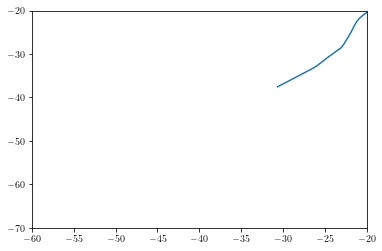

<ipython-input-429-521ee8b4274a>:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(densitydomainnew), np.log(dEOSdrho(densitydomainnew)))


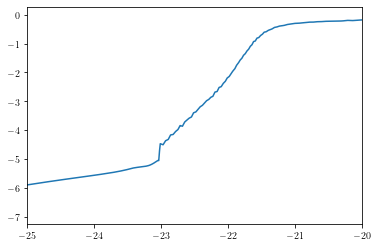

In [429]:
#print(domainvals)

domainvalsnew = np.concatenate((np.array([1e-60]),domainvals))
plt.plot(np.log(domainvalsnew), np.log(EOS(domainvalsnew)))
plt.xlim(-60, -20)
plt.ylim(-70, -20)
plt.show()

densitydomainnew = np.concatenate((np.array([1e-60]), dEOSdata[:, 0]))

plt.plot(np.log(densitydomainnew), np.log(dEOSdrho(densitydomainnew)))
plt.xlim(-25, -20)
plt.show()

In [430]:
# import density vals and define an interpolating function
density_vals = np.loadtxt(directory + "density-vals-rhoc-" + str(myindex) + ".csv", delimiter=",")
# densityfnc = interpol.interp1d(density_vals[:, 0], density_vals[:, 1], kind='quadratic')
densityfnc = interpol.PchipInterpolator(density_vals[:, 0], density_vals[:, 1])
print("done with most important one, errors after this don't matter")

#pressure_vals = np.loadtxt(directory + "pressure-vals-rhoc-" + str(myindex) + ".csv", delimiter=",")
pressure_valsy = EOS(np.array(density_vals[:,1]))
pressure_valsx = np.array(density_vals[:,0])
pressure_vals = np.zeros(np.shape(density_vals))
pressure_vals[:,0] = pressure_valsx
pressure_vals[:,1] = pressure_valsy
# pressurefnc = interpol.interp1d(pressure_vals[:, 0], pressure_vals[:, 1], kind='quadratic')
pressurefnc = interpol.PchipInterpolator(pressure_vals[:, 0], pressure_vals[:, 1])

mass_vals = np.loadtxt(directory + "mass-vals-rhoc-" + str(myindex) + ".csv", delimiter=",")
# massfnc = interpol.interp1d(mass_vals[:, 0], mass_vals[:, 1], kind='quadratic')
massfnc = interpol.PchipInterpolator(mass_vals[:, 0], mass_vals[:, 1])

nu_vals = np.loadtxt(directory + "nu-vals-rhoc-" + str(myindex) + ".csv", delimiter=",")
# nufnc = interpol.interp1d(nu_vals[:, 0], nu_vals[:, 1], kind='quadratic')
nufnc = interpol.PchipInterpolator(nu_vals[:, 0], nu_vals[:, 1])

done with most important one, errors after this don't matter


/Users/wentmich/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_cubic.py:288: RuntimeWarning: overflow encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/Users/wentmich/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_cubic.py:288: RuntimeWarning: overflow encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/Users/wentmich/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_cubic.py:288: RuntimeWarning: invalid value encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


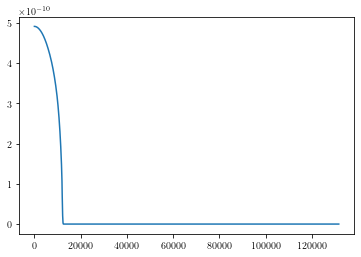

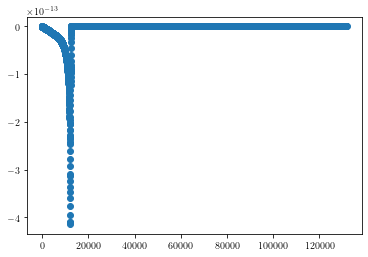

In [431]:
density_vals_dr = density_vals[1,0] - density_vals[0,0]
drho_vals_dr = (-np.roll(density_vals[:,1], -2, 0) + 8.0 * np.roll(density_vals[:,1], -1, 0) - 8.0 * np.roll(density_vals[:,1], 1, 0) + np.roll(density_vals[:,1], 2, 0)) / (12.0 * density_vals_dr)

drho_vals_dr[0] = 0.0
drho_vals_dr[1] = (-density_vals[1,1] + 8.0 * density_vals[0,1] - 8.0 * density_vals[2,1] + density_vals[3,1]) / (12.0 * density_vals_dr)
drho_vals_dr[-1] = drho_vals_dr[-3]
drho_vals_dr[-2] = drho_vals_dr[-3]

plt.plot(density_vals[:,0], density_vals[:,1])
plt.show()

plt.plot(density_vals[:,0], drho_vals_dr, 'o')
plt.show()

In [432]:
# GLOBALS
tinit, tfin = 0, 40000.0
rinit, rfin = density_vals[0, 0], density_vals[-1, 0]*1

Nt, Nr = 16000, 10000
dt, dr = (tfin - tinit) / Nt, (rfin - rinit) / Nr

rvals = np.linspace(rinit, rfin, Nr)
tvals = np.linspace(tinit, tfin, Nt)

NS_mass_radius = np.loadtxt(directory + "MR-vals.csv", delimiter=",")
#rNS = NS_mass_radius[myindex, 0]
#centraldensity = central_densities[myindex]

In [433]:
print(dr)
print(dt)
print(density_vals)

13.168799327010502
2.5
[[1.00000000e-03 4.91546656e-10]
 [1.31711163e+01 4.91546382e-10]
 [2.63412327e+01 4.91545563e-10]
 ...
 [1.31661654e+05 0.00000000e+00]
 [1.31674824e+05 0.00000000e+00]
 [1.31687994e+05 0.00000000e+00]]


In [434]:
# spatial derivative function with boundary conditions
def first_r_derivative(farray):
#     first_deriv = (np.roll(farray, -1, 0) - farray) / dr
#     first_deriv[0] = 0
#     first_deriv[-1] = first_deriv[-2]
    first_deriv = (-np.roll(farray, -2, 0) + 8.0 * np.roll(farray, -1, 0) - 8.0 * np.roll(farray, 1, 0) + np.roll(farray, 2, 0)) / (12.0 * dr)
    first_deriv[0] = 0.0
    first_deriv[1] = (-farray[1] + 8.0 * farray[0] - 8.0 * farray[2] + farray[3]) / (12.0 * dr)
    first_deriv[-1] = first_deriv[-3]
    first_deriv[-2] = first_deriv[-3]
    return first_deriv;

def second_r_derivative(farray):
#     second_deriv = (np.roll(farray, -1, 0) - 2*farray + np.roll(farray, 1, 0)) / dr**2
#     second_deriv[0] = (2*farray[1] - 2*farray[0]) / dr**2
#     second_deriv[-1] = 0
#     second_deriv[-2] = second_deriv[-3]
    second_deriv = (-np.roll(farray, -2, 0) + 16.0 * np.roll(farray, -1, 0) - 30.0 * farray + 16.0 * np.roll(farray, 1, 0) - np.roll(farray, 2, 0)) / (12.0 * dr**2)
    second_deriv[0] = (-farray[2] + 16.0 * farray[1] - 30.0 * farray[0] + 16.0 * farray[1] - farray[2]) / (12.0 * dr**2)
    second_deriv[1] = (-farray[1] + 16.0 * farray[0] - 30.0 * farray[1] + 16.0 * farray[2] - farray[3]) / (12.0 * dr**2)
    second_deriv[-1] = 0.0
    second_deriv[-2] = 0.0
    #second_deriv = first_r_derivative(first_r_derivative(farray))
    return second_deriv;

How would this step-up procedure work? We'd start with some system that solves the constraint equations which should simply be the TOV equation with the axion fields set to zero. Then we would solve for the time derivatives and step up all functions that have explicit time derivatives solved for.

After that, we'd go back to the constraints equations. The constraint equations have already been solved but not have some perturbation to them so that we know what most of the variables in them look like. So we'd want to find a solution to the implicit functions using what as an initial condition?

Potentially, the $tt$ component gives us the metric function $G(t,r)$ by integrating the $tt$ component of the stress-energy tensor. Could we get something similar from the $rr$ component? I think we might be able to if we parametrize the metric function correctly. But I'm not sure that this holds in the general case.

In [435]:
# density profile takes in r in meters and spits out density in m^-2
def density_profile(r):
    return np.piecewise(r, [r < density_vals[-1, 0], r >= density_vals[-1, 0]], [lambda var: densityfnc(var), lambda var: densityfnc(density_vals[-1, 0])*np.exp(-var + density_vals[-1, 0])])

def pressure_profile(r):
    return np.piecewise(r, [r < density_vals[-1, 0], r >= density_vals[-1, 0]], [lambda var: pressurefnc(var), lambda var: var])

def mass_profile(r):
    return np.piecewise(r, [r < density_vals[-1, 0], r >= density_vals[-1, 0]], [lambda var: massfnc(var), massfnc(density_vals[-2, 0])])

def lambda_profile(r):
    return np.piecewise(r, [r == 0.0, r > 0.0], [0.0, lambda var: -np.log(1 - 2*mass_profile(var)/var)]);

def nu_profile(r):
    return np.piecewise(r, [r < density_vals[-1, 0], r >= density_vals[-1, 0]], [lambda var: nufnc(var), lambda var: np.log(1 - 2*mass_profile(var)/(var))])

In [436]:
###################### Initial Values ########################
initialRvals = density_profile(rvals)
initialAvals = rvals*0.0 #np.exp(-(rvals / 5000)) * (rvals / 5000)**2 / 2 #np.zeros(np.shape(rvals))
initialPvals = np.zeros(np.shape(rvals))
initialUvals = rvals*0.0

[4.91546656e-10 4.91546382e-10 4.91545563e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


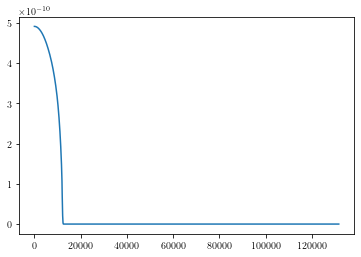

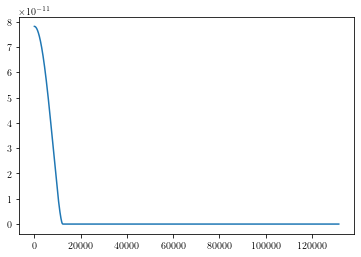

In [437]:
print(initialRvals)
plt.plot(rvals, initialRvals)
plt.show()

plt.plot(rvals, EOS(initialRvals))
#plt.ylim(0, 1e-200)
plt.show()

In [438]:
####################### Runge-Kutta for Spatial Integration #######################
def inside_density(r, G0, U0, R0, A0, P0, dAdr):
    return R0 + epsilon*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2) + myabs(cos(A0/2.))*(R0*sigmaN*pow(mN,-1) - epsilon*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2)) + (pow(G0,-2)*pow(GeV2m,2)*pow(hbarGeo,-1)*(pow(dAdr,2)*pow(fa,2) + pow(fa,2)*pow(P0,2)))/2. + (R0 + EOS(R0))*pow(G0,2)*pow(U0,2)

def get_total_inside_mass(rvals, G0array, U0array, R0array, A0array, P0array, dAdrarray):
    integral = 0
    for i in range(len(rvals)-1):
        integral += (dr/2) * 4 * np.pi * (rvals[i]**2 * inside_density(rvals[i], G0array[i], U0array[i], R0array[i], A0array[i], P0array[i], dAdrarray[i]) + rvals[i+1]**2 * inside_density(rvals[i+1], G0array[i+1], U0array[i+1], R0array[i+1], A0array[i+1], P0array[i+1], dAdrarray[i+1]))
    return integral;

def get_total_inside_mass_fast(rvals, G0array, U0array, R0array, A0array, P0array, dAdrarray):
    integral = (dr/2) * 4 * np.pi * (rvals**2 * inside_density(rvals, G0array, U0array, R0array, A0array, P0array, dAdrarray) + np.roll(rvals, -1, 0)**2 * inside_density(np.roll(rvals, -1, 0), np.roll(G0array, -1, 0), np.roll(U0array, -1, 0), np.roll(R0array, -1, 0), np.roll(A0array, -1, 0), np.roll(P0array, -1, 0), np.roll(dAdrarray, -1, 0)))
    integral = np.sum(integral) - integral[-1]
    return integral;

def k1Gr_fnc(r, G0, U0, R0, A0, P0, dAdr):
    return 12.566370614359172*G0*pow(r,-1)*(0.039788735772973836 - 3.352274113084859e-39*pow(dAdr,2)*pow(fa,2)*pow(r,2) - 3.352274113084859e-39*pow(fa,2)*pow(P0,2)*pow(r,2) + pow(G0,2)*(-0.039788735772973836 - 5.3015901118033394e-11*epsilon*potoffset*pow(r,2) + (1. + 0.06279515051146117*potoffset)*R0*pow(r,2) + (5.3015901118033394e-11*epsilon - 0.06279515051146117*R0)*myabs(cos(A0/2.))*pow(r,2)) + (1.*R0 + 1.*EOS(R0))*pow(G0,4)*pow(r,2)*pow(U0,2))

def k1Gr_G1(r, U0, R0, A0, P0, dAdr):
    return 4.212591890594653e-38*r*pow(dAdr,2)*pow(fa,2) + 4.212591890594653e-38*r*pow(fa,2)*pow(P0,2) + pow(r,-1)/2.

def k1Gr_G3(r, U0, R0, A0, P0, dAdr):
    return 6.662174619034264e-10*epsilon*r + 11.777263480247685*r*R0 + r*(-6.662174619034264e-10*epsilon + 0.7891071341114869*R0)*myabs(cos(A0/2.)) - 0.5*pow(r,-1)

def k1Gr_G5(r, U0, R0, A0, P0, dAdr):
    return 4*Pi*r*(R0 + EOS(R0))*pow(U0,2)

def k1Ur_fnc(r, G0, U0, R0, A0, P0, dAdr, dRdr):
    k1Urnum = (G0*U0*(dRdr*r*(1.*dEOSdrho(R0) - 0.06279515051146117*myabs(cos(A0/2.))) + R0*(-2.5 - 4.2125918905946527e-38*pow(dAdr,2)*pow(fa,2)*pow(r,2) - 4.2125918905946527e-38*pow(fa,2)*pow(P0,2)*pow(r,2)) + EOS(R0)*(-2.5 - 4.2125918905946527e-38*pow(dAdr,2)*pow(fa,2)*pow(r,2) - 4.2125918905946527e-38*pow(fa,2)*pow(P0,2)*pow(r,2))) + U0*pow(G0,3)*(R0*(0.5 - 6.662174619034264e-10*epsilon*pow(r,2) + (6.662174619034264e-10*epsilon - 0.789107134111487*R0)*myabs(cos(A0/2.))*pow(r,2) - 2.*pow(U0,2)) + EOS(R0)*(0.5 - 6.662174619034264e-10*epsilon*pow(r,2) + 12.566370614359174*R0*pow(r,2) + (6.662174619034264e-10*epsilon - 0.789107134111487*R0)*myabs(cos(A0/2.))*pow(r,2) - 2.*pow(U0,2)) + 12.566370614359174*pow(r,2)*pow(EOS(R0),2)) + dAdr*P0*(8.425183781189305e-38*R0 + 8.425183781189305e-38*EOS(R0))*pow(fa,2)*pow(r,2)*pow(1 + pow(G0,2)*pow(U0,2),0.5)) / r 
    k1Urden = G0*(R0 + EOS(R0))
    return piecewise_division_by_zero(k1Urnum, k1Urden);

def k1Fr_fnc(r, G0, F0, U0, R0, A0, P0, dAdr):
    return F0*pow(r,-1)*(-0.5 - 4.212591890594653e-38*pow(dAdr,2)*pow(fa,2)*pow(r,2) - 4.212591890594653e-38*pow(fa,2)*pow(P0,2)*pow(r,2) + pow(G0,2)*(0.5 + 6.662174619034264e-10*epsilon*potoffset*pow(r,2) - 0.789107134111487*potoffset*R0*pow(r,2) + 12.566370614359172*EOS(R0)*pow(r,2) + (-6.662174619034264e-10*epsilon + 0.789107134111487*R0)*myabs(cos(A0/2.))*pow(r,2)) + (12.566370614359172*R0 + 12.566370614359172*EOS(R0))*pow(G0,4)*pow(r,2)*pow(U0,2))

def k1Fr_F1(r, G0, U0, R0, A0, P0, dAdr):
    return pow(r,-1)*(-0.5 + 4.212591890594653e-38*pow(dAdr,2)*pow(fa,2)*pow(r,2) + 4.212591890594653e-38*pow(fa,2)*pow(P0,2)*pow(r,2) + pow(G0,2)*(0.5 - 6.662174619034264e-10*epsilon*pow(r,2) + 12.566370614359172*EOS(R0)*pow(r,2) + (6.662174619034264e-10*epsilon - 0.789107134111487*R0)*myabs(cos(A0/2.))*pow(r,2)) + (12.566370614359172*R0 + 12.566370614359172*EOS(R0))*pow(G0,4)*pow(r,2)*pow(U0,2))

def solve_for_G_next_step(r, G0, U0, R0, A0, P0, dAdr, dRdr):
    k1Gr = k1Gr_fnc(r, G0, U0, R0, A0, P0, dAdr)
    k2Gr = k1Gr_fnc(r + dr/2, G0 + k1Gr*dr/2, U0, R0, A0, P0, dAdr)
    k3Gr = k1Gr_fnc(r + dr/2, G0 + k2Gr*dr/2, U0, R0, A0, P0, dAdr)
    k4Gr = k1Gr_fnc(r + dr, G0 + k3Gr*dr, U0, R0, A0, P0, dAdr)
    return G0 + (k1Gr/6 + k2Gr/3 + k3Gr/3 + k4Gr/6) * dr;

def solve_for_G_next_step_fast(r, G0, G1c1, G3c1, G5c1, G1c2, G3c2, G5c2, G1c3, G3c3, G5c3, G1c4, G3c4, G5c4):
    k1Gr = G1c1 * G0 + G3c1 * G0**3 + G5c1 * G0**5
    k2Gr = G1c2 * (G0 + k1Gr*dr/2) + G3c2 * (G0 + k1Gr*dr/2)**3 + G5c2 * (G0 + k1Gr*dr/2)**5
    k3Gr = G1c3 * (G0 + k2Gr*dr/2) + G3c3 * (G0 + k2Gr*dr/2)**3 + G5c3 * (G0 + k2Gr*dr/2)**5
    k4Gr = G1c4 * (G0 + k3Gr*dr) + G3c4 * (G0 + k3Gr*dr)**3 + G5c4 * (G0 + k3Gr*dr)**5
    return G0 + (k1Gr/6 + k2Gr/3 + k3Gr/3 + k4Gr/6) * dr;

def solve_for_G_and_U_next_step(r, G0, U0, R0, A0, P0, dAdr, dRdr):
    k1Gr = k1Gr_fnc(r, G0, U0, R0, A0, P0, dAdr)
    k1Ur = k1Ur_fnc(r, G0, U0, R0, A0, P0, dAdr, dRdr)
    # get k2 arrays
    k2Gr = k1Gr_fnc(r + dr/2, G0 + k1Gr*dr/2, U0 + k1Ur*dr/2, R0, A0, P0, dAdr)
    k2Ur = k1Ur_fnc(r + dr/2, G0 + k1Gr*dr/2, U0 + k1Ur*dr/2, R0, A0, P0, dAdr, dRdr)
    # get k3 arrays
    k3Gr = k1Gr_fnc(r + dr/2, G0 + k2Gr*dr/2, U0 + k2Ur*dr/2, R0, A0, P0, dAdr)
    k3Ur = k1Ur_fnc(r + dr/2, G0 + k2Gr*dr/2, U0 + k2Ur*dr/2, R0, A0, P0, dAdr, dRdr)
    # get k4 arrays
    k4Gr = k1Gr_fnc(r + dr, G0 + k3Gr*dr, U0 + k3Ur*dr, R0, A0, P0, dAdr)
    k4Ur = k1Ur_fnc(r + dr, G0 + k3Gr*dr, U0 + k3Ur*dr, R0, A0, P0, dAdr, dRdr)
    # update with Runge-Kutta
    G1 = G0 + (1/6)*k1Gr*dr + (1/3)*k1Gr*dr + (1/3)*k1Gr*dr + (1/6)*k1Gr*dr
    U1 = U0 + (1/6)*k1Ur*dr + (1/3)*k1Ur*dr + (1/3)*k1Ur*dr + (1/6)*k1Ur*dr
    return np.array([G1, U1]).astype(np.float64);
    

def solve_for_F_next_step(r, G0, F0, U0, R0, A0, P0, dAdr):
    k1Fr = k1Fr_fnc(r, G0, F0, U0, R0, A0, P0, dAdr)
    k2Fr = k1Fr_fnc(r + dr/2, G0, F0 + k1Fr*dr/2, U0, R0, A0, P0, dAdr)
    k3Fr = k1Fr_fnc(r + dr/2, G0, F0 + k2Fr*dr/2, U0, R0, A0, P0, dAdr)
    k4Fr = k1Fr_fnc(r + dr, G0, F0 + k3Fr*dr, U0, R0, A0, P0, dAdr)
    return F0 - (k1Fr/6 + k2Fr/3 + k3Fr/3 + k4Fr/6) * dr;

def solve_for_F_next_step_fast(r, F0, F1c1, F1c2, F1c3, F1c4):
    k1Fr = F1c1 * F0
    k2Fr = F1c2 * (F0 - k1Fr*dr/2) 
    k3Fr = F1c3 * (F0 - k2Fr*dr/2)
    k4Fr = F1c4 * (F0 - k3Fr*dr)
    return F0 - (k1Fr/6 + k2Fr/3 + k3Fr/3 + k4Fr/6) * dr;

#def solve_for_F_next_step(r, G0, F0, U0, R0, A0, P0, dAdr):
#    k1Fr = (F0*r*(8*Pi*(potoffset - myabs(cos(A0/2.)))*pow(G0,2)*pow(hbarGeo,-3)*pow(mN,-1)*(-(R0*sigmaN*pow(hbarGeo,3)) + epsilon*mN*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)) - 4*Pi*pow(GeV2m,2)*pow(hbarGeo,-1)*(pow(dAdr,2) + pow(fa,2)*pow(P0,2)) - pow(r,-2) + pow(G0,2)*pow(r,-2) + 8*Pi*pow(G0,2)*(R0*pow(U0,2) + EOS(R0)*(1 + pow(U0,2)))))/2.
#    return F0 - k1Fr * dr;

def solve_for_G(G0point, U0array, R0array, A0array, P0array, dAdrarray, dRdrarray):
    G1vals = np.zeros(np.shape(rvals))
    G1vals[0] = G0point
    for i in range(1, Nr):
        G1vals[i] = solve_for_G_next_step(rvals[i-1], G1vals[i-1], U0array[i-1], R0array[i-1], A0array[i-1], P0array[i-1], dAdrarray[i-1], dRdrarray[i-1])
    
    #print(G1vals)
    
    return G1vals;

def solve_for_G_fast(G0point, U0array, R0array, A0array, P0array, dAdrarray, dRdrarray):
    U0array2 = (np.roll(U0array, -1, 0) + U0array)/2.0
    U0array2[-1] = U0array[-1]
    R0array2 = (np.roll(R0array, -1, 0) + R0array)/2.0
    R0array2[-1] = R0array[-1]
    A0array2 = (np.roll(A0array, -1, 0) + A0array)/2.0
    A0array2[-1] = A0array[-1]
    P0array2 = (np.roll(P0array, -1, 0) + P0array)/2.0
    P0array2[-1] = P0array[-1]
    dAdrarray2 = (np.roll(dAdrarray, -1, 0) + dAdrarray)/2.0
    dAdrarray2[-1] = dAdrarray[-1]
    
    U0array4 = np.roll(U0array, -1, 0)
    U0array4[-1] = U0array[-1]
    R0array4 = np.roll(R0array, -1, 0)
    R0array4[-1] = R0array[-1]
    A0array4 = np.roll(A0array, -1, 0)
    A0array4[-1] = A0array[-1]
    P0array4 = np.roll(P0array, -1, 0)
    P0array4[-1] = P0array[-1]
    dAdrarray4 = np.roll(dAdrarray, -1, 0)
    dAdrarray4[-1] = dAdrarray[-1]
    
    G1c1 = k1Gr_G1(rvals, U0array, R0array, A0array, P0array, dAdrarray)
    G3c1 = k1Gr_G3(rvals, U0array, R0array, A0array, P0array, dAdrarray)
    G5c1 = k1Gr_G5(rvals, U0array, R0array, A0array, P0array, dAdrarray)
    
    G1c2 = k1Gr_G1(rvals + np.ones(np.shape(rvals))*dr/2, U0array2, R0array2, A0array2, P0array2, dAdrarray2)
    G3c2 = k1Gr_G3(rvals + np.ones(np.shape(rvals))*dr/2, U0array2, R0array2, A0array2, P0array2, dAdrarray2)
    G5c2 = k1Gr_G5(rvals + np.ones(np.shape(rvals))*dr/2, U0array2, R0array2, A0array2, P0array2, dAdrarray2)
    
    G1c4 = k1Gr_G1(rvals + np.ones(np.shape(rvals))*dr, U0array4, R0array4, A0array4, P0array4, dAdrarray4)
    G3c4 = k1Gr_G3(rvals + np.ones(np.shape(rvals))*dr, U0array4, R0array4, A0array4, P0array4, dAdrarray4)
    G5c4 = k1Gr_G5(rvals + np.ones(np.shape(rvals))*dr, U0array4, R0array4, A0array4, P0array4, dAdrarray4)
    
    G1vals = np.zeros(np.shape(rvals))
    G1vals[0] = G0point
    for i in range(1, Nr):
        G1vals[i] = solve_for_G_next_step_fast(rvals[i-1], G1vals[i-1], G1c1[i-1], G3c1[i-1], G5c1[i-1], G1c2[i-1], G3c2[i-1], G5c2[i-1], G1c2[i-1], G3c2[i-1], G5c2[i-1], G1c4[i-1], G3c4[i-1], G5c4[i-1])
        #G1vals[i] = solve_for_G_next_step_fast(rvals[i-1], G1vals[i-1], U0array[i-1], R0array[i-1], A0array[i-1], P0array[i-1], dAdrarray[i-1], dRdrarray[i-1])
    
    #print(G1vals)
    
    return G1vals;

def solve_for_G_and_U(G0point, U0point, R0array, A0array, P0array, dAdrarray, dRdrarray):
    G1vals = np.zeros(np.shape(rvals))
    U1vals = np.zeros(np.shape(rvals))
    G1vals[0] = G0point
    U1vals[0] = U0point
    for i in range(1, Nr):
        newvals = solve_for_G_and_U_next_step(rvals[i-1], G1vals[i-1], U1vals[i-1], R0array[i-1], A0array[i-1], P0array[i-1], dAdrarray[i-1], dRdrarray[i-1])
        G1vals[i] = newvals[0]
        U1vals[i] = newvals[1]
        
    return np.concatenate((G1vals, U1vals)).astype(np.float64);

def solve_for_F(G0array, U0array, R0array, A0array, P0array, dAdrarray):
    F1vals = np.zeros(np.shape(rvals))
    F1vals[-1] = np.sqrt(1 - 2*get_total_inside_mass(rvals, G0array, U0array, R0array, A0array, P0array, dAdrarray) / rvals[-1])
    for i in range(2, Nr+1):
        F1vals[-i] = solve_for_F_next_step(rvals[-i+1], G0array[-i+1], F1vals[-i+1], U0array[-i+1], R0array[-i+1], A0array[-i+1], P0array[-i+1], dAdrarray[-i+1])
    
    return F1vals;

def solve_for_F_fast(G0array, U0array, R0array, A0array, P0array, dAdrarray):
    G0array2 = (np.roll(G0array, 1, 0) + G0array) / 2.0
    G0array2[0] = G0array[0]
    U0array2 = (np.roll(U0array, 1, 0) + U0array) / 2.0
    U0array2[0] = U0array[0]
    R0array2 = (np.roll(R0array, 1, 0) + R0array) / 2.0
    R0array2[0] = R0array[0]
    A0array2 = (np.roll(A0array, 1, 0) + A0array) / 2.0
    A0array2[0] = A0array[0]
    P0array2 = (np.roll(P0array, 1, 0) + P0array) / 2.0
    P0array2[0] = P0array[0]
    dAdrarray2 = (np.roll(dAdrarray, 1, 0) + dAdrarray) / 2.0
    dAdrarray2[0] = dAdrarray[0]
    
    G0array4 = np.roll(G0array, 1, 0)
    G0array4[0] = G0array[0]
    U0array4 = np.roll(U0array, 1, 0)
    U0array4[0] = U0array[0]
    R0array4 = np.roll(R0array, 1, 0)
    R0array4[0] = R0array[0]
    A0array4 = np.roll(A0array, 1, 0)
    A0array4[0] = A0array[0]
    P0array4 = np.roll(P0array, 1, 0)
    P0array4[0] = P0array[0]
    dAdrarray4 = np.roll(dAdrarray, 1, 0)
    dAdrarray4[0] = dAdrarray[0]
    
    F1c1 = k1Fr_F1(rvals, G0array, U0array, R0array, A0array, P0array, dAdrarray)
    
    F1c2 = k1Fr_F1(rvals - np.ones(np.shape(rvals))*dr/2, G0array2, U0array2, R0array2, A0array2, P0array2, dAdrarray2)
    
    F1c4 = k1Fr_F1(rvals - np.ones(np.shape(rvals))*dr, G0array4, U0array4, R0array4, A0array4, P0array4, dAdrarray4)
    
    F1vals = np.zeros(np.shape(rvals))
    integraltime = time.time()
    F1vals[-1] = np.sqrt(1 - 2*get_total_inside_mass_fast(rvals, G0array, U0array, R0array, A0array, P0array, dAdrarray) / rvals[-1])
    integraltotaltime = time.time() - integraltime
    #print(integraltotaltime)
    
    for i in range(2, Nr+1):
        F1vals[-i] = solve_for_F_next_step_fast(rvals[-i+1], F1vals[-i+1], F1c1[-i+1], F1c2[-i+1], F1c2[-i+1], F1c4[-i+1])
        #G1vals[i] = solve_for_G_next_step_fast(rvals[i-1], G1vals[i-1], U0array[i-1], R0array[i-1], A0array[i-1], P0array[i-1], dAdrarray[i-1], dRdrarray[i-1])
    
    #print(G1vals)
    
    return F1vals;

# def metric_and_4vel_integrator(R0array, A0array, P0array):
#     dAdrarray = first_r_derivative(A0array)
#     dRdrarray = first_r_derivative(R0array)
#     G1andU1vals = solve_for_G_and_U(1, 0, R0array, A0array, P0array, dAdrarray, dRdrarray)
#     G1vals, U1vals = G1andU1vals[0:Nr], G1andU1vals[Nr:2*Nr]
#     F1vals = solve_for_F(G1vals, U1vals, R0array, A0array, P0array, dAdrarray)
#     #print(G1vals)
#     #print(F1vals)
#     return np.concatenate((F1vals, G1vals, U1vals)).astype(np.float64);

def metric_integrator(U0array, R0array, A0array, P0array):
    dAdrarray = first_r_derivative(A0array)
    dRdrarray = first_r_derivative(R0array)
    G1vals = solve_for_G_fast(1, U0array, R0array, A0array, P0array, dAdrarray, dRdrarray)
    F1vals = solve_for_F_fast(G1vals, U0array, R0array, A0array, P0array, dAdrarray)
    #print(G1vals)
    #print(F1vals)
    return np.concatenate((F1vals, G1vals)).astype(np.float64);

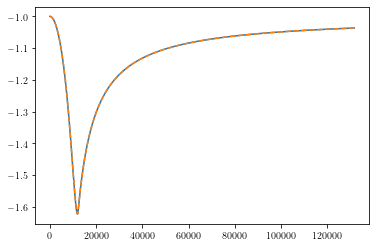

0.14788198471069336


In [439]:
Gtimestart = time.time()
initialdAdrvals = first_r_derivative(initialAvals)
initialdRdrvals = first_r_derivative(initialRvals)
initialGvals = solve_for_G_fast(1, initialUvals, initialRvals, initialAvals, initialPvals, initialdAdrvals, initialdRdrvals)
#initialGvals = solve_for_G(1, initialUvals, initialRvals, initialAvals, initialPvals, initialdAdrvals)
initialGvals = initialGvals
Gtimeend = time.time()
Gtimetotal = Gtimeend - Gtimestart
initialdGdrvals = first_r_derivative(initialGvals)
metricvalstest = -initialGvals**2
correctanswer = -1/(1 - 2*mass_profile(rvals)/rvals)

plt.plot(rvals, metricvalstest)
plt.plot(rvals, correctanswer, '--')
plt.show()

print(Gtimetotal)
# plt.plot(rvals, initialUvals)
# plt.show()

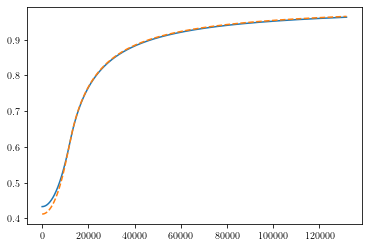

0.07886886596679688


In [440]:
Ftimestart = time.time()
initialFvals = solve_for_F_fast(initialGvals, initialUvals, initialRvals, initialAvals, initialPvals, initialdAdrvals)
Ftimeend = time.time()
Ftimetotal = Ftimeend - Ftimestart
metricFvalstest = initialFvals**2
correctFanswer = np.exp(nu_profile(rvals))
plt.plot(rvals, metricFvalstest)
#plt.plot(rvals, initialdFdrvals)
plt.plot(rvals, correctFanswer, '--')
plt.show()

print(Ftimetotal)

Note that now the inside energy density is slightly larger when the axion potential is included but no axion is sourced.

In [447]:
###################### Runge-Kutta Integrator ########################
# the runge-kutta integrator will take initial conditions for the following six functions:
# U - radial 4 velocity scaled by G, U = G*ur
# R - baryon density
# A - axion field scaled by fa, A = a*fa
# P - axion velocity scaled by metric components, P = (G/F)*ak1
# it then steps them up using a 4th order Runge-Kutta
# for the spatial derivatives it uses a 4th order finite difference

def zero_below(myarrary, epsilon):
    result = myarrary.copy()
    result[result < epsilon] = 0.0
    return result;

def piecewise_division_by_zero(a, b):
    #a = np.asarray(a).astype(np.float64)
    #b = np.asarray(b).astype(np.float64)
    result = np.zeros(np.shape(a))
    np.divide(a, b, out=result, where=(abs(b) >= 1.0e-200))
    #result = zero_below(result, 1e-5)
    return result;

def custom_sign(myarray):
    return np.where(myarray == 0, -1, np.sign(myarray));


def kiG_function(r, F0, G0, U0, R0, A0, P0):
    dAdr  = first_r_derivative(A0)
    k1G = 4*F0*Pi*r*pow(hbarGeo,-1)*(dAdr*P0*pow(fa,2)*pow(GeV2m,2) + hbarGeo*U0*(R0 + EOS(R0))*pow(G0,3)*pow(1 + pow(G0,2)*pow(U0,2),0.5))
    return k1G.astype(np.float64);
"""
def kiU_function(r, F0, G0, U0, R0, A0, P0):
    dFdr  = first_r_derivative(F0)
    dGdr  = first_r_derivative(G0)
    dUdr  = first_r_derivative(U0)
    dRdr  = first_r_derivative(R0)
    dAdr  = first_r_derivative(A0)
    dAdr2 = second_r_derivative(A0)
    
    #k1UNonZero = 0.0*r
    
    k1UZeronum = F0*(-0.3945535670557435*myabs(cos(A0/2.))*(15.924796610169494 + 1.*myabs(cos(A0/2.)))*pow(G0,2)*pow(r,2)*pow(R0,2)*pow(1 + pow(G0,2)*pow(U0,2),0.5) + 6.283185307179586*(15.924796610169494 + 1.*myabs(cos(A0/2.)))*pow(G0,2)*pow(r,2)*pow(EOS(R0),2)*pow(1 + pow(G0,2)*pow(U0,2),0.5) + dRdr*r*(7.962398305084746*dEOSdrho(R0) + (-0.5 + 0.5*dEOSdrho(R0))*myabs(cos(A0/2.)) - 0.031397575255730586*pow(myabs(cos(A0/2.)),2))*pow(1 + pow(G0,2)*pow(U0,2),0.5) + R0*(dAdr*G0*P0*U0*(-1.3416933811873845e-36 + 6.7084669059369225e-37*dEOSdrho(R0) - 1.2637775671783959e-37*myabs(cos(A0/2.)))*pow(fa,2)*pow(r,2) + dAdr*P0*(-1.341693381187385e-36 + 1.341693381187385e-36*dEOSdrho(R0) - 1.685036756237861e-37*myabs(cos(A0/2.)))*pow(fa,2)*pow(G0,3)*pow(r,2)*pow(U0,3) + (-3.9811991525423727 + 3.354233452968461e-37*pow(dAdr,2)*pow(fa,2)*pow(r,2) + 3.354233452968461e-37*pow(fa,2)*pow(P0,2)*pow(r,2) + myabs(cos(A0/2.))*(-0.25 + 2.106295945297326e-38*pow(dAdr,2)*pow(fa,2)*pow(r,2) + 2.106295945297326e-38*pow(fa,2)*pow(P0,2)*pow(r,2)))*pow(1 + pow(G0,2)*pow(U0,2),0.5) + pow(G0,2)*(3.9811991525423727 + dUdr*r*U0*(7.962398305084746 - 7.962398305084746*dEOSdrho(R0)) - 5.304688789477704e-9*epsilon*pow(r,2) + (6.7084669059369225e-37*pow(dAdr,2)*pow(fa,2)*pow(r,2) + (6.7084669059369225e-37 - 6.7084669059369225e-37*dEOSdrho(R0))*pow(fa,2)*pow(P0,2)*pow(r,2) + dEOSdrho(R0)*(-15.924796610169492 - 6.7084669059369225e-37*pow(dAdr,2)*pow(fa,2)*pow(r,2)))*pow(U0,2) + myabs(cos(A0/2.))*(0.25 + 1.*dUdr*r*U0 + 4.9715800585259896e-9*epsilon*pow(r,2) + (1. + 8.425183781189304e-38*pow(dAdr,2)*pow(fa,2)*pow(r,2) + 8.425183781189304e-38*pow(fa,2)*pow(P0,2)*pow(r,2))*pow(U0,2)) + 3.3310873095171315e-10*epsilon*pow(r,2)*pow(myabs(cos(A0/2.)),2))*pow(1 + pow(G0,2)*pow(U0,2),0.5)) + EOS(R0)*(dAdr*G0*P0*U0*(-1.3416933811873845e-36 + 6.7084669059369225e-37*dEOSdrho(R0) - 1.2637775671783959e-37*myabs(cos(A0/2.)))*pow(fa,2)*pow(r,2) + dAdr*P0*(-1.341693381187385e-36 + 1.341693381187385e-36*dEOSdrho(R0) - 1.685036756237861e-37*myabs(cos(A0/2.)))*pow(fa,2)*pow(G0,3)*pow(r,2)*pow(U0,3) + (-3.981199152542372 + 3.354233452968461e-37*pow(dAdr,2)*pow(fa,2)*pow(r,2) + 3.354233452968461e-37*pow(fa,2)*pow(P0,2)*pow(r,2) + myabs(cos(A0/2.))*(-0.24999999999999997 + 2.106295945297326e-38*pow(dAdr,2)*pow(fa,2)*pow(r,2) + 2.106295945297326e-38*pow(fa,2)*pow(P0,2)*pow(r,2)))*pow(1 + pow(G0,2)*pow(U0,2),0.5) + pow(G0,2)*(3.9811991525423727 + dUdr*r*U0*(7.962398305084746 - 7.962398305084746*dEOSdrho(R0)) - 5.304688789477704e-9*epsilon*pow(r,2) + 100.05844808084025*R0*pow(r,2) + (6.708466905936922e-37*pow(dAdr,2)*pow(fa,2)*pow(r,2) + (6.708466905936922e-37 - 6.708466905936922e-37*dEOSdrho(R0))*pow(fa,2)*pow(P0,2)*pow(r,2) + dEOSdrho(R0)*(-15.924796610169492 - 6.708466905936922e-37*pow(dAdr,2)*pow(fa,2)*pow(r,2)))*pow(U0,2) + myabs(cos(A0/2.))*(0.25 + 1.*dUdr*r*U0 + 4.9715800585259896e-9*epsilon*pow(r,2) + (1. + 8.425183781189304e-38*pow(dAdr,2)*pow(fa,2)*pow(r,2) + 8.425183781189304e-38*pow(fa,2)*pow(P0,2)*pow(r,2))*pow(U0,2)) + (3.331087309517132e-10*epsilon - 0.3945535670557435*R0)*pow(r,2)*pow(myabs(cos(A0/2.)),2))*pow(1 + pow(G0,2)*pow(U0,2),0.5)))
    k1UZeroden = r*(R0 + EOS(R0))*pow(G0,2)*(7.962398305084746 + (7.962398305084746 - 7.962398305084746*dEOSdrho(R0))*pow(G0,2)*pow(U0,2) + myabs(cos(A0/2.))*(0.5 + 1.*pow(G0,2)*pow(U0,2)))
    k1UZeronum = k1UZeronum.astype(np.float64)
    k1UZeroden = k1UZeroden.astype(np.float64)
    
    finalk1Uarray = piecewise_division_by_zero(k1UZeronum, k1UZeroden)# + k1UNonZero
    finalk1Uarray[0] = 0.0
#     plt.plot(rvals, k1UZeroden)
#     plt.show()
#     plt.plot(rvals, k1UZeronum)
#     plt.xlim(11000, 120000)
#     plt.show()
    #print(finalk1Uarray)
    #print(max(k1UNonZero))
    #print(k1UNonZero)
    #print(finalk1Uarray)
    
    return finalk1Uarray.astype(np.float64);
""";


def kiU_function(r, F0, G0, U0, R0, A0, P0):
    pplusrholimitcut = 1.0e-200
    dFdr  = first_r_derivative(F0)
    dGdr  = first_r_derivative(G0)
    dUdr  = first_r_derivative(U0)
    dRdr  = first_r_derivative(R0)
    dAdr  = first_r_derivative(A0)
    dAdr2 = second_r_derivative(A0)
    
    #print(min(R0))
    #print(piecewise_division_by_zero(dRdr, R0))
    
    kiU_rho2 = 4*F0*Pi*r*sigmaN*myabs(cos(A0/2.))*(mN + sigmaN*myabs(cos(A0/2.)))*pow(mN,-1)*pow(1 + pow(G0,2)*pow(U0,2),0.5)*pow(-(sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2))) + mN*(-1 + (-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2)),-1)
    kiU_p2 = -4*F0*Pi*r*(mN + sigmaN*myabs(cos(A0/2.)))*pow(1 + pow(G0,2)*pow(U0,2),0.5)*pow(-(sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2))) + mN*(-1 + (-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2)),-1)
    kiU_prho = -4*F0*Pi*r*pow(mN,-1)*(pow(mN,2) - pow(sigmaN,2)*pow(cos(A0/2.),2))*pow(1 + pow(G0,2)*pow(U0,2),0.5)*pow(-(sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2))) + mN*(-1 + (-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2)),-1)
    kiU_dpdrhoXrho = F0*mN*U0*pow(G0,-1)*pow(hbarGeo,-1)*pow(r,-1)*(-4*dAdr*P0*Pi*pow(fa,2)*pow(GeV2m,2)*pow(r,2) - 8*dAdr*P0*Pi*pow(fa,2)*pow(G0,2)*pow(GeV2m,2)*pow(r,2)*pow(U0,2) + G0*(dUdr*hbarGeo*r + 2*U0*(hbarGeo + 2*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2) + 2*Pi*pow(fa,2)*pow(GeV2m,2)*pow(P0,2)*pow(r,2)))*pow(1 + pow(G0,2)*pow(U0,2),0.5))*pow(-(sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2))) + mN*(-1 + (-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2)),-1)
    kiU_drhodrXp = np.zeros(np.shape(F0))
    kiU_drhodrXdpdrho = -(F0*(mN + sigmaN*myabs(cos(A0/2.)))*pow(G0,-2)*pow(1 + pow(G0,2)*pow(U0,2),0.5)*pow(-(sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2))) + mN*(-1 + (-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2)),-1))
    kiU_p = (F0*pow(G0,-2)*pow(hbarGeo,-3)*pow(mN,-1)*pow(r,-1)*(-8*dAdr*G0*mN*P0*Pi*U0*(mN*(-2 + dEOSdrho(R0)) - 3*sigmaN*myabs(cos(A0/2.)))*pow(fa,2)*pow(GeV2m,2)*pow(hbarGeo,2)*pow(r,2) - 16*dAdr*mN*P0*Pi*(mN*(-1 + dEOSdrho(R0)) - 2*sigmaN*myabs(cos(A0/2.)))*pow(fa,2)*pow(G0,3)*pow(GeV2m,2)*pow(hbarGeo,2)*pow(r,2)*pow(U0,3) + mN*(mN + sigmaN*myabs(cos(A0/2.)))*pow(hbarGeo,2)*(hbarGeo - 4*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2) - 4*Pi*pow(fa,2)*pow(GeV2m,2)*pow(P0,2)*pow(r,2))*pow(1 + pow(G0,2)*pow(U0,2),0.5) + pow(G0,2)*(-(pow(hbarGeo,3)*pow(mN,2)) + 2*dUdr*r*U0*(-1 + dEOSdrho(R0))*pow(hbarGeo,3)*pow(mN,2) + 8*epsilon*Pi*pow(fpi,2)*pow(GeV2m,4)*pow(mN,2)*pow(mpi,2)*pow(r,2) - 4*Pi*R0*pow(hbarGeo,3)*pow(r,2)*pow(sigmaN,2) - 4*Pi*R0*cos(A0)*pow(hbarGeo,3)*pow(r,2)*pow(sigmaN,2) + 4*pow(hbarGeo,2)*pow(mN,2)*(-2*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2) + 2*Pi*(-1 + dEOSdrho(R0))*pow(fa,2)*pow(GeV2m,2)*pow(P0,2)*pow(r,2) + dEOSdrho(R0)*(hbarGeo + 2*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2)))*pow(U0,2) - mN*myabs(cos(A0/2.))*(sigmaN*pow(hbarGeo,3) + 4*dUdr*r*sigmaN*U0*pow(hbarGeo,3) + 8*epsilon*Pi*(mN - sigmaN)*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)*pow(r,2) + 4*sigmaN*pow(hbarGeo,2)*(hbarGeo + 4*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2) + 4*Pi*pow(fa,2)*pow(GeV2m,2)*pow(P0,2)*pow(r,2))*pow(U0,2)) + 8*Pi*sigmaN*(R0*sigmaN*pow(hbarGeo,3) - epsilon*mN*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2))*pow(r,2)*pow(myabs(cos(A0/2.)),2))*pow(1 + pow(G0,2)*pow(U0,2),0.5))*pow(-(sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2))) + mN*(-1 + (-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2)),-1))/2.
    kiU_rho = -0.5*(F0*pow(G0,-2)*pow(hbarGeo,-3)*pow(r,-1)*(-8*dAdr*G0*P0*Pi*U0*(2*mN + 3*sigmaN*myabs(cos(A0/2.)))*pow(fa,2)*pow(GeV2m,2)*pow(hbarGeo,2)*pow(r,2) - 16*dAdr*P0*Pi*(mN + 2*sigmaN*myabs(cos(A0/2.)))*pow(fa,2)*pow(G0,3)*pow(GeV2m,2)*pow(hbarGeo,2)*pow(r,2)*pow(U0,3) - (mN + sigmaN*myabs(cos(A0/2.)))*pow(hbarGeo,2)*(hbarGeo - 4*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2) - 4*Pi*pow(fa,2)*pow(GeV2m,2)*pow(P0,2)*pow(r,2))*pow(1 + pow(G0,2)*pow(U0,2),0.5) + pow(G0,2)*(mN*(pow(hbarGeo,3) + 2*dUdr*r*U0*pow(hbarGeo,3) - 8*epsilon*Pi*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)*pow(r,2) + 8*Pi*pow(GeV2m,2)*pow(hbarGeo,2)*(pow(dAdr,2)*pow(fa,2) + pow(fa,2)*pow(P0,2))*pow(r,2)*pow(U0,2)) + myabs(cos(A0/2.))*(sigmaN*pow(hbarGeo,3) + 4*dUdr*r*sigmaN*U0*pow(hbarGeo,3) + 8*epsilon*Pi*(mN - sigmaN)*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)*pow(r,2) + 4*sigmaN*pow(hbarGeo,2)*(hbarGeo + 4*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2) + 4*Pi*pow(fa,2)*pow(GeV2m,2)*pow(P0,2)*pow(r,2))*pow(U0,2)) + 8*epsilon*Pi*sigmaN*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)*pow(r,2)*pow(myabs(cos(A0/2.)),2))*pow(1 + pow(G0,2)*pow(U0,2),0.5))*pow(-(sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2))) + mN*(-1 + (-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2)),-1))
    kiU_drhodr = F0*sigmaN*myabs(cos(A0/2.))*(mN + sigmaN*myabs(cos(A0/2.)))*pow(G0,-2)*pow(mN,-1)*pow(1 + pow(G0,2)*pow(U0,2),0.5)*pow(-(sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2))) + mN*(-1 + (-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2)),-1)
    
    #kiU_denominator_wo_pplusrho = 
    
    rho2Overpplusrho = np.zeros(np.shape(rvals))
    np.divide(R0**2, (R0 + EOS(R0)), out=rho2Overpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
    p2Overpplusrho = np.zeros(np.shape(rvals))
    np.divide(EOS(R0)**2, (R0 + EOS(R0)), out=p2Overpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
    pXrhoOverpplusrho = np.zeros(np.shape(rvals))
    np.divide(EOS(R0)*R0, (R0 + EOS(R0)), out=pXrhoOverpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
    dpdrhoXrhoOverpplusrho = np.ones(np.shape(rvals)) * EOS_slope / (1.0 + EOS_slope) #np.zeros(np.shape(rvals))
    np.divide(dEOSdrho(R0) * R0, (R0 + EOS(R0)), out=dpdrhoXrhoOverpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
    drhodrXpOverpplusrho = np.zeros(np.shape(rvals))
    np.divide(dRdr * EOS(R0), (R0 + EOS(R0)), out=drhodrXpOverpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
    drhodrXdpdrhoOverpplusrho = piecewise_division_by_zero(dRdr * dEOSdrho(R0), (R0 + EOS(R0)))
    #drhodrXdpdrhoOverpplusrho = np.zeros(np.shape(rvals)) * EOS_slope # could be wrong but is more complicated
    np.divide(dRdr * dEOSdrho(R0), (R0 + EOS(R0)), out=drhodrXdpdrhoOverpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
    pOverpplusrho = np.ones(np.shape(rvals)) * EOS_slope / (1.0 + EOS_slope)
    np.divide(EOS(R0), (R0 + EOS(R0)), out=pOverpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
    rhoOverpplusrho = np.ones(np.shape(rvals)) / (EOS_slope + 1.0)
    np.divide(R0, (R0 + EOS(R0)), out=rhoOverpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
    drhodrOverpplusrho = piecewise_division_by_zero(dRdr, R0 + EOS(R0)) # could also be wrong but is complicated
    np.divide(dRdr, (R0 + EOS(R0)), out=drhodrOverpplusrho, where=((R0 + EOS(R0)) >= pplusrholimitcut))
    
#     finalkiU = kiU_rho2*rho2Overpplusrho + \
#                 kiU_p2*p2Overpplusrho + \
#                 kiU_prho*pXrhoOverpplusrho + \
#                 kiU_dpdrhoXrho*dpdrhoXrhoOverpplusrho + \
#                 kiU_drhodrXp*drhodrXpOverpplusrho + \
#                 kiU_drhodrXdpdrho*drhodrXdpdrhoOverpplusrho + \
#                 kiU_p*pOverpplusrho + \
#                 kiU_rho*rhoOverpplusrho + \
#                 kiU_drhodr*drhodrOverpplusrho
#     plt.plot(rvals, dRdr * dEOSdrho(R0))
#     #plt.plot(rvals, (R0 + EOS(R0))/1000)
#     #plt.plot(rvals, drhodrOverpplusrho / 100000000000 )
#     plt.show()
#     plt.close()
    
    
    finalkiU = kiU_rho2*rho2Overpplusrho + \
                kiU_p2*p2Overpplusrho + \
                kiU_prho*pXrhoOverpplusrho + \
                kiU_dpdrhoXrho*dpdrhoXrhoOverpplusrho + \
                kiU_drhodrXp*drhodrXpOverpplusrho + \
                kiU_drhodrXdpdrho*drhodrXdpdrhoOverpplusrho + \
                kiU_p*pOverpplusrho + \
                kiU_rho*rhoOverpplusrho + \
                kiU_drhodr*drhodrOverpplusrho
    
    #finalkiU[0] = 0.0
    
    return finalkiU.astype(np.float64);



def kiR_function(r, F0, G0, U0, R0, A0, P0):
    dUdr  = first_r_derivative(U0)
    dRdr  = first_r_derivative(R0)
    dAdr  = first_r_derivative(A0)
    dAdr2 = second_r_derivative(A0)
    
    k1Rarray = -0.5*(F0*pow(G0,-1)*pow(hbarGeo,-3)*pow(r,-1)*pow(1 + pow(G0,2)*pow(U0,2),-0.5)*(-(G0*pow(hbarGeo,2)*(2*dUdr*hbarGeo*mN*r*R0 + U0*(2*dRdr*hbarGeo*r*(mN - mN*dEOSdrho(R0) + 2*sigmaN*myabs(cos(A0/2.))) + mN*R0*(5*hbarGeo + 4*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2) + 4*Pi*pow(fa,2)*pow(GeV2m,2)*pow(P0,2)*pow(r,2))) + mN*EOS(R0)*(2*dUdr*hbarGeo*r + U0*(5*hbarGeo + 4*Pi*pow(dAdr,2)*pow(fa,2)*pow(GeV2m,2)*pow(r,2) + 4*Pi*pow(fa,2)*pow(GeV2m,2)*pow(P0,2)*pow(r,2))))) + U0*pow(G0,3)*(-8*Pi*sigmaN*myabs(cos(A0/2.))*pow(hbarGeo,3)*pow(r,2)*pow(R0,2) - 2*dRdr*r*(mN - mN*dEOSdrho(R0) + 2*sigmaN*myabs(cos(A0/2.)))*pow(hbarGeo,3)*pow(U0,2) - mN*R0*(-pow(hbarGeo,3) + 8*epsilon*Pi*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)*pow(r,2) - 8*epsilon*Pi*myabs(cos(A0/2.))*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)*pow(r,2) + 4*pow(hbarGeo,3)*pow(U0,2)) + EOS(R0)*(8*Pi*myabs(cos(A0/2.))*(-(R0*sigmaN*pow(hbarGeo,3)) + epsilon*mN*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2))*pow(r,2) + mN*(pow(hbarGeo,3) + 8*Pi*R0*pow(hbarGeo,3)*pow(r,2) - 8*epsilon*Pi*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)*pow(r,2) - 4*pow(hbarGeo,3)*pow(U0,2))) + 8*mN*Pi*pow(hbarGeo,3)*pow(r,2)*pow(EOS(R0),2)) + 8*dAdr*mN*P0*Pi*(R0 + EOS(R0))*pow(fa,2)*pow(GeV2m,2)*pow(hbarGeo,2)*pow(r,2)*pow(1 + pow(G0,2)*pow(U0,2),0.5))*pow(mN - mN*(-1 + dEOSdrho(R0))*pow(G0,2)*pow(U0,2) + sigmaN*myabs(cos(A0/2.))*(1 + 2*pow(G0,2)*pow(U0,2)),-1))
    #k1Rarraynum = F0*(fa*P0*R0*(R0*sigmaN*pow(hbarGeo,3) - epsilon*mN*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2))*(1 + pow(G0,2)*pow(U0,2))*sin(A0) + G0*U0*pow(1 + pow(G0,2)*pow(U0,2),0.5)*(2*dRdr*fa*mN*EOS(R0)*myabs(cos(A0/2.))*pow(hbarGeo,3) - dAdr*fa*sigmaN*pow(hbarGeo,3)*pow(R0,2)*sin(A0) + R0*(2*dRdr*fa*sigmaN*myabs(cos(A0/2.))*(-potoffset + myabs(cos(A0/2.)))*pow(hbarGeo,3) + dAdr*epsilon*fa*mN*pow(fpi,2)*pow(GeV2m,4)*pow(mpi,2)*sin(A0))))
    #k1Rarrayden = 2*fa*G0*myabs(cos(A0/2.))*(mN*EOS(R0) + R0*sigmaN*(-potoffset + myabs(cos(A0/2.))))*pow(hbarGeo,3)*(1 + pow(G0,2)*pow(U0,2))
    
    #finalk1Rarray = piecewise_division_by_zero(k1Rarraynum, k1Rarrayden).astype(np.float64)
    #print(finalk1Rarray)
    
    return k1Rarray.astype(np.float64);

def kiA_function(r, F0, G0, U0, R0, A0, P0):
    k1Aarray = (F0*fa*P0*pow(G0,-1)) / fa
    #print(k1Aarray)
    return k1Aarray.astype(np.float64);

def kiP_function_nonzero(r, F0, G0, U0, R0, A0, P0):
    dAdr  = first_r_derivative(A0)
    dAdr2 = second_r_derivative(A0)
    k1ParrayNonZero = (-4*dAdr*F0*fa*G0*Pi*r*R0 + 4*dAdr*F0*fa*G0*Pi*r*EOS(R0) + dAdr2*F0*fa*pow(G0,-1) - 8*dAdr*F0*fa*G0*Pi*r*R0*sigmaN*myabs(cos(A0/2.))*pow(mN,-1) - 8*dAdr*epsilon*F0*fa*G0*Pi*r*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2) + 8*dAdr*epsilon*F0*fa*G0*Pi*r*myabs(cos(A0/2.))*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2) + dAdr*F0*fa*G0*pow(r,-1) + dAdr*F0*fa*pow(G0,-1)*pow(r,-1)) / fa
    return k1ParrayNonZero.astype(np.float64);

def kiP_function_zero(r, F0, G0, U0, R0, A0, P0, alimitcut):
    #k1ParrayZero = np.piecewise(A0, [np.abs(A0 - np.pi) <= alimitcut, np.abs(A0 - np.pi) > alimitcut], [lambda var: (F0*G0*hbarGeo*R0*sigmaN*pow(fa,-1)*pow(GeV2m,-2)*pow(mN,-1)*(-2.0 * np.sign(var - np.pi)))/4. - (epsilon*F0*G0*pow(fa,-1)*pow(fpi,2)*pow(GeV2m,2)*pow(hbarGeo,-2)*pow(mpi,2)*(-2.0 * np.sign(var - np.pi)))/4., lambda var: (F0*G0*hbarGeo*R0*sigmaN*pow(fa,-1)*pow(GeV2m,-2)*pow(mN,-1)*pow(myabs(cos(var/2.)),-1)*sin(var))/4. - (epsilon*F0*G0*pow(fa,-1)*pow(fpi,2)*pow(GeV2m,2)*pow(hbarGeo,-2)*pow(mpi,2)*pow(myabs(cos(var/2.)),-1)*sin(var))/4.])
    k1ParrayCoefficient = (F0*G0*hbarGeo*R0*sigmaN*pow(fa,-1)*pow(GeV2m,-2)*pow(mN,-1))/4. - (epsilon*F0*G0*pow(fa,-1)*pow(fpi,2)*pow(GeV2m,2)*pow(hbarGeo,-2)*pow(mpi,2))/4.
    SinOverCos = (-2.0 * custom_sign(A0 - np.ones(np.shape(A0)) * np.pi))
    #print(SinOverCos)
    np.divide(sin(A0), myabs(cos(A0/2.0)), out=SinOverCos, where=(abs(A0 - np.ones(np.shape(A0)) * np.pi) >= alimitcut))
    #print(SinOverCos)
    #print(abs(A0 - np.ones(np.shape(A0))*np.pi))
    k1ParrayZero = k1ParrayCoefficient * SinOverCos / fa
    
    return k1ParrayZero.astype(np.float64);

def kiP_function(r, F0, G0, U0, R0, A0, P0):
#     dAdr  = first_r_derivative(A0)
#     dAdr2 = second_r_derivative(A0)
#     k1Parray = -4*dAdr*F0*fa*G0*Pi*r*R0 + 4*dAdr*F0*fa*G0*Pi*r*EOS(R0) + dAdr2*F0*fa*pow(G0,-1) - 8*dAdr*F0*fa*G0*Pi*potoffset*r*R0*sigmaN*pow(mN,-1) + 8*dAdr*F0*fa*G0*Pi*r*R0*sigmaN*myabs(cos(A0/2.))*pow(mN,-1) + 8*dAdr*epsilon*F0*fa*G0*Pi*potoffset*r*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2) - 8*dAdr*epsilon*F0*fa*G0*Pi*r*myabs(cos(A0/2.))*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2) + dAdr*F0*fa*G0*pow(r,-1) + dAdr*F0*fa*pow(G0,-1)*pow(r,-1) + (F0*G0*hbarGeo*R0*sigmaN*pow(fa,-1)*pow(GeV2m,-2)*pow(mN,-1)*pow(myabs(cos(A0/2.)),-1)*sin(A0))/4. - (epsilon*F0*G0*pow(fa,-1)*pow(fpi,2)*pow(GeV2m,2)*pow(hbarGeo,-2)*pow(mpi,2)*pow(myabs(cos(A0/2.)),-1)*sin(A0))/4.
#     k1Parray = k1Parray / fa
    k1Parray = kiP_function_nonzero(r, F0, G0, U0, R0, A0, P0) + kiP_function_zero(r, F0, G0, U0, R0, A0, P0, ALIMITCUT)
    
    return k1Parray.astype(np.float64);

INTERMEDIATEMETRICINTEGRATOR = 1

def matter_integrator(r, F0, G0, U0, R0, A0, P0):
    # get k1 arrays
    k1U = kiU_function(r, F0, G0, U0, R0, A0, P0)
    #print("k1U ", max(k1U))
    k1R = kiR_function(r, F0, G0, U0, R0, A0, P0)
    k1A = kiA_function(r, F0, G0, U0, R0, A0, P0)
    #print("k1A ", k1A)
    k1P = kiP_function(r, F0, G0, U0, R0, A0, P0)
    # get k2 arrays
    if INTERMEDIATEMETRICINTEGRATOR == 1:
        metrichalf1 = metric_integrator(U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
        Fhalf1 = metrichalf1[0:Nr]
        Ghalf1 = metrichalf1[Nr:2*Nr]
    else:
        Fhalf1 = F0
        Ghalf1 = G0
    k2U = kiU_function(r, Fhalf1, Ghalf1, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    k2R = kiR_function(r, Fhalf1, Ghalf1, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    k2A = kiA_function(r, Fhalf1, Ghalf1, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    k2P = kiP_function(r, Fhalf1, Ghalf1, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    # get k3 arrays
    if INTERMEDIATEMETRICINTEGRATOR == 1:
        metrichalf2 = metric_integrator(U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
        Fhalf2 = metrichalf2[0:Nr]
        Ghalf2 = metrichalf2[Nr:2*Nr]
    else:
        Fhalf2 = F0
        Ghalf2 = G0
    k3U = kiU_function(r, Fhalf2, Ghalf2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    k3R = kiR_function(r, Fhalf2, Ghalf2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    k3A = kiA_function(r, Fhalf2, Ghalf2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    k3P = kiP_function(r, Fhalf2, Ghalf2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    # get k4 arrays
    if INTERMEDIATEMETRICINTEGRATOR == 1:
        metricfull = metric_integrator(U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
        Ffull = metricfull[0:Nr]
        Gfull = metricfull[Nr:2*Nr]
    else:
        Ffull = F0
        Gfull = G0
    k4U = kiU_function(r, Ffull, Gfull, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    k4R = kiR_function(r, Ffull, Gfull, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    k4A = kiA_function(r, Ffull, Gfull, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    k4P = kiP_function(r, Ffull, Gfull, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    # update with Runge-Kutta
    U1 = U0 + (1/6)*k1U*dt + (1/3)*k2U*dt + (1/3)*k3U*dt + (1/6)*k4U*dt
    R1 = R0 + (1/6)*k1R*dt + (1/3)*k2R*dt + (1/3)*k3R*dt + (1/6)*k4R*dt
    A1 = A0 + (1/6)*k1A*dt + (1/3)*k2A*dt + (1/3)*k3A*dt + (1/6)*k4A*dt
    P1 = P0 + (1/6)*k1P*dt + (1/3)*k2P*dt + (1/3)*k3P*dt + (1/6)*k4P*dt
    
    U1[0] = 0.0
    return np.concatenate((U1, R1, A1, P1)).astype(np.float64);


def matter_and_G_integrator(r, F0, G0, U0, R0, A0, P0):
    # get k1 arrays
    k1U = kiU_function(r, F0, G0, U0, R0, A0, P0)
    k1R = kiR_function(r, F0, G0, U0, R0, A0, P0)
    k1A = kiA_function(r, F0, G0, U0, R0, A0, P0)
    k1P = kiP_function(r, F0, G0, U0, R0, A0, P0)
    k1G = kiG_function(r, F0, G0, U0, R0, A0, P0)
    # get k2 arrays
    if INTERMEDIATEMETRICINTEGRATOR == 1:
        dAdrarrayhalf1 = first_r_derivative(A0 + k1A*dt/2)
        Fhalf1 = solve_for_F_fast(G0 + k1G*dt/2, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2, dAdrarrayhalf1)
    else:
        Fhalf1 = F0
    k2G = kiG_function(r, Fhalf1, G0 + k1G*dt/2, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    k2U = kiU_function(r, Fhalf1, G0 + k1G*dt/2, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    k2R = kiR_function(r, Fhalf1, G0 + k1G*dt/2, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    k2A = kiA_function(r, Fhalf1, G0 + k1G*dt/2, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    k2P = kiP_function(r, Fhalf1, G0 + k1G*dt/2, U0 + k1U*dt/2, R0 + k1R*dt/2, A0 + k1A*dt/2, P0 + k1P*dt/2)
    # get k3 arrays
    if INTERMEDIATEMETRICINTEGRATOR == 1:
        dAdrarrayhalf2 = first_r_derivative(A0 + k2A*dt/2)
        Fhalf2 = solve_for_F_fast(G0 + k2G*dt/2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2, dAdrarrayhalf2)
    else:
        Fhalf2 = F0
    k3G = kiU_function(r, Fhalf2, G0 + k2G*dt/2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    k3U = kiU_function(r, Fhalf2, G0 + k2G*dt/2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    k3R = kiR_function(r, Fhalf2, G0 + k2G*dt/2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    k3A = kiA_function(r, Fhalf2, G0 + k2G*dt/2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    k3P = kiP_function(r, Fhalf2, G0 + k2G*dt/2, U0 + k2U*dt/2, R0 + k2R*dt/2, A0 + k2A*dt/2, P0 + k2P*dt/2)
    # get k4 arrays
    if INTERMEDIATEMETRICINTEGRATOR == 1:
        dAdrarrayfull = first_r_derivative(A0 + k3A*dt)
        Ffull = solve_for_F_fast(G0 + k3G*dt, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt, dAdrarrayfull)
    else:
        Ffull = F0
    k4G = kiU_function(r, Ffull, G0 + k3G*dt, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    k4U = kiU_function(r, Ffull, G0 + k3G*dt, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    k4R = kiR_function(r, Ffull, G0 + k3G*dt, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    k4A = kiA_function(r, Ffull, G0 + k3G*dt, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    k4P = kiP_function(r, Ffull, G0 + k3G*dt, U0 + k3U*dt, R0 + k3R*dt, A0 + k3A*dt, P0 + k3P*dt)
    # update with Runge-Kutta
    G1 = G0 + (1/6)*k1G*dt + (1/3)*k2G*dt + (1/3)*k3G*dt + (1/6)*k4G*dt
    U1 = U0 + (1/6)*k1U*dt + (1/3)*k2U*dt + (1/3)*k3U*dt + (1/6)*k4U*dt
    R1 = R0 + (1/6)*k1R*dt + (1/3)*k2R*dt + (1/3)*k3R*dt + (1/6)*k4R*dt
    A1 = A0 + (1/6)*k1A*dt + (1/3)*k2A*dt + (1/3)*k3A*dt + (1/6)*k4A*dt
    P1 = P0 + (1/6)*k1P*dt + (1/3)*k2P*dt + (1/3)*k3P*dt + (1/6)*k4P*dt
    
    #U1[0] = 0.0
    G1[0] = 1.0
    return np.concatenate((U1, R1, A1, P1, G1)).astype(np.float64);


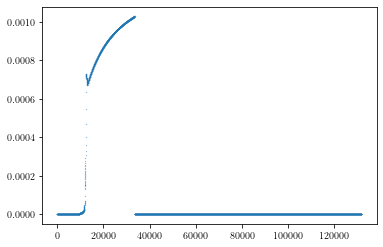

In [448]:
testkiU = kiU_function(rvals, initialFvals, initialGvals, initialUvals, initialRvals, initialAvals, initialPvals)
plt.plot(rvals, testkiU, 'o', markersize=0.2)
plt.show()

Something still looks wrong here, I think everyhting should be much closer to zero here. In fact, it looks like it's zero inside the star as it should be. My guess is that the TOV solution does well but then once the TOV is replaced by an exponential decay in the density and pressure, the cancellations don't happen properly.

Is the pressure going negative when I generate these values???

In [449]:
Mattertimestart = time.time()
mattertest1 = matter_integrator(rvals, initialFvals, initialGvals, initialUvals, initialRvals, initialAvals, initialPvals)
Mattertimeend = time.time()
Mattertimetotal = Mattertimeend - Mattertimestart

MatterandGtimestart = time.time()
matterandGtest1 = matter_and_G_integrator(rvals, initialFvals, initialGvals, initialUvals, initialRvals, initialAvals, initialPvals)
MatterandGtimeend = time.time()
MatterandGtimetotal = MatterandGtimeend - MatterandGtimestart

In [450]:
print("Total step time: " + str(Ftimetotal + Gtimetotal + Mattertimetotal))
print("Estimated total time: " + str((Ftimetotal + Gtimetotal + Mattertimetotal)*Nt/60) + " minutes")
print("For " + str(Nt) + " steps")
print("with time step dt = " + str(dt))
print("and r step dr = " + str(dr))
print(Mattertimetotal)

print("Total step time: " + str(Ftimetotal + MatterandGtimetotal))
print("Estimated total time: " + str((Ftimetotal + MatterandGtimetotal)*Nt/60) + " minutes")
print("For " + str(Nt) + " steps")
print("with time step dt = " + str(dt))
print("and r step dr = " + str(dr))
print(MatterandGtimetotal)

Total step time: 1.315969705581665
Estimated total time: 350.92525482177734 minutes
For 16000 steps
with time step dt = 2.5
and r step dr = 13.168799327010502
1.0892188549041748
Total step time: 0.7486698627471924
Estimated total time: 199.64529673258463 minutes
For 16000 steps
with time step dt = 2.5
and r step dr = 13.168799327010502
0.6698009967803955


Plots for step  10 of 16000 steps
[ 4.04671810e-09  1.21185135e-05  3.46360642e-07  2.51043493e-07
 -1.76842748e-07 -1.42778488e-07 -1.78601962e-07 -2.04744000e-07
 -2.33096922e-07 -2.61085021e-07]


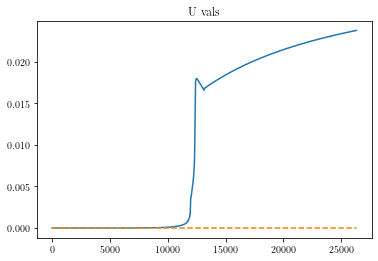

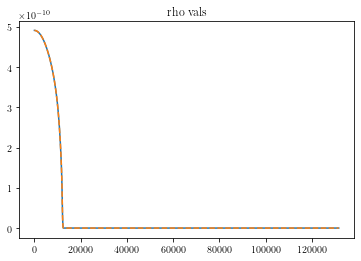

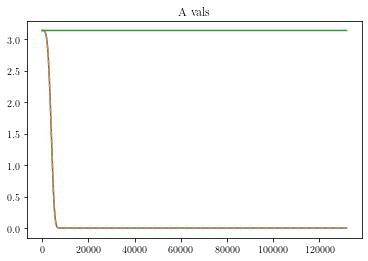

Plots for step  20 of 16000 steps
[ 7.99604031e-09  1.13647152e-04 -1.22954573e-05  1.01496272e-05
 -2.47954847e-06  2.52600684e-07 -5.34833181e-07 -3.90583783e-07
 -4.89142605e-07 -5.35370886e-07]


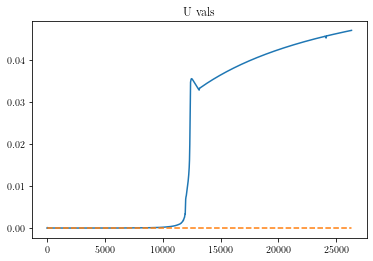

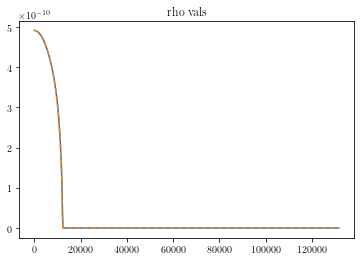

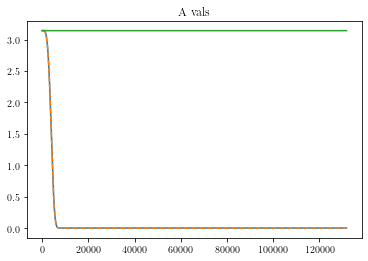

Plots for step  30 of 16000 steps
[ 1.15260208e-08  4.96252764e-04 -1.59627853e-04  9.33909109e-05
 -2.91398236e-05  9.94276015e-06 -3.96240501e-06  2.91763224e-07
 -1.01983479e-06 -7.54517027e-07]


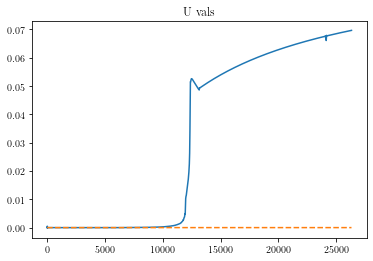

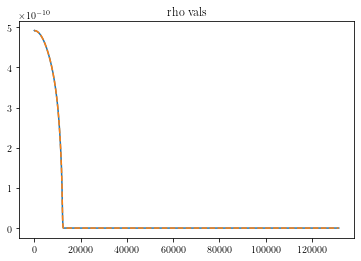

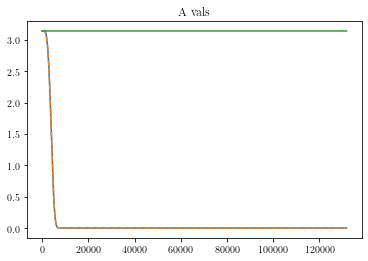

Plots for step  40 of 16000 steps
[ 1.46013114e-08  1.64974781e-03 -9.13094224e-04  5.00314629e-04
 -2.02862230e-04  8.68308330e-05 -3.33383436e-05  1.04837539e-05
 -4.90948032e-06  9.13312504e-08]


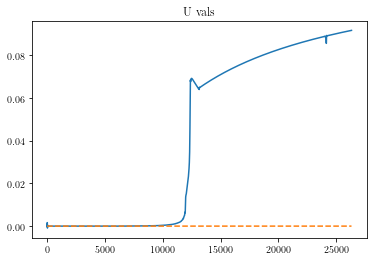

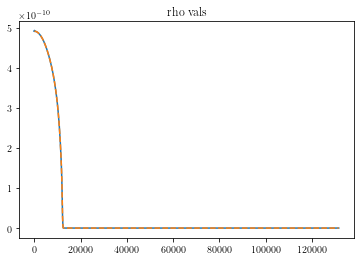

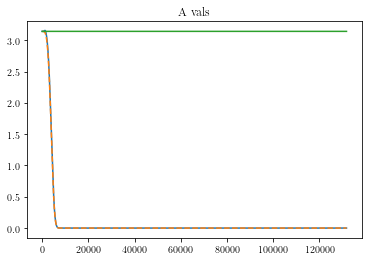

Plots for step  50 of 16000 steps
[ 1.72933408e-08  4.94009296e-03 -3.73233631e-03  2.01832830e-03
 -9.91546505e-04  4.74536211e-04 -2.02100115e-04  8.09945369e-05
 -3.31112537e-05  1.00908550e-05]


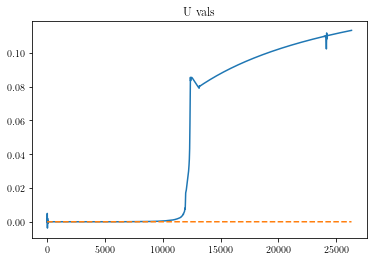

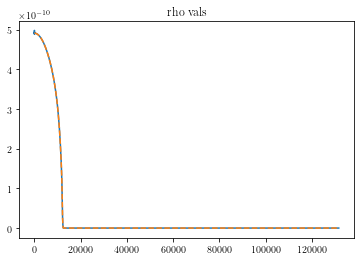

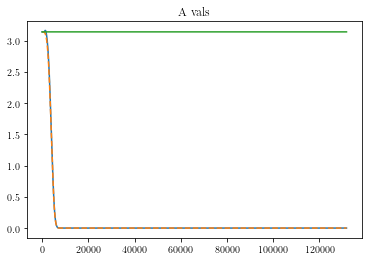

Plots for step  60 of 16000 steps
[ 1.95277732e-08  1.41636400e-02 -1.30211996e-02  6.92525761e-03
 -3.89022370e-03  1.98139384e-03 -9.36455488e-04  4.24046944e-04
 -1.84039604e-04  7.25691686e-05]


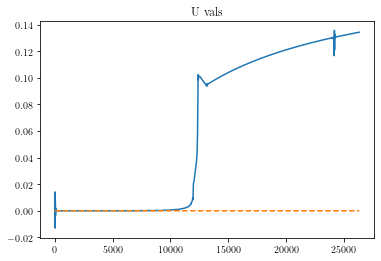

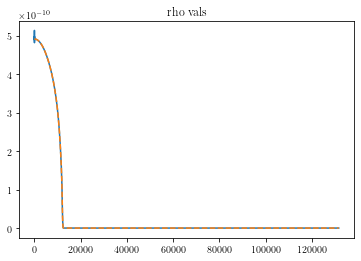

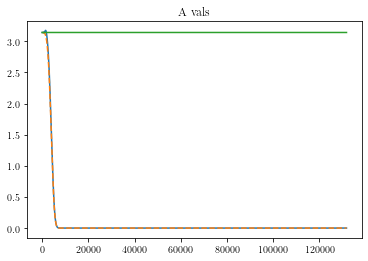

Plots for step  70 of 16000 steps
[ 2.12832967e-08  3.86973282e-02 -4.23813056e-02  2.15588775e-02
 -1.34950748e-02  7.00869350e-03 -3.61608443e-03  1.75851619e-03
 -8.23466606e-04  3.64219776e-04]


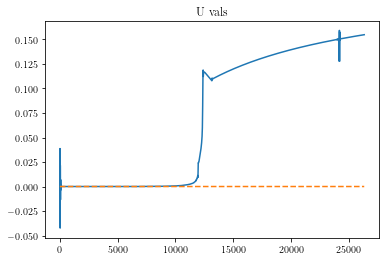

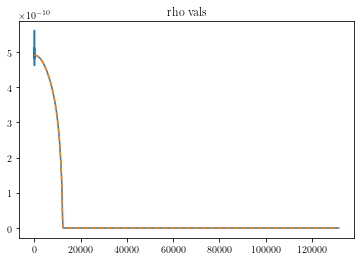

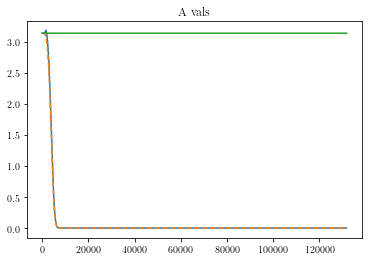

Plots for step  80 of 16000 steps
[ 2.28039605e-08  9.33230444e-02 -1.40095329e-01  6.13267709e-02
 -4.36334518e-02  2.22535307e-02 -1.25063694e-02  6.25840192e-03
 -3.14136542e-03  1.48676368e-03]


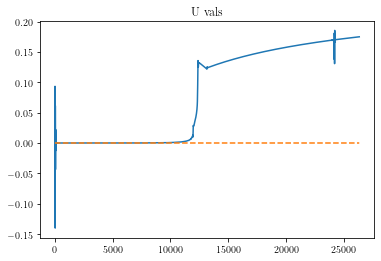

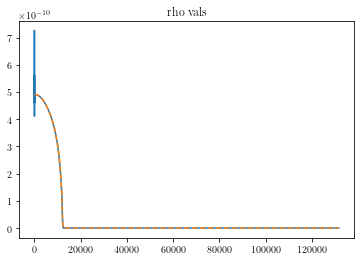

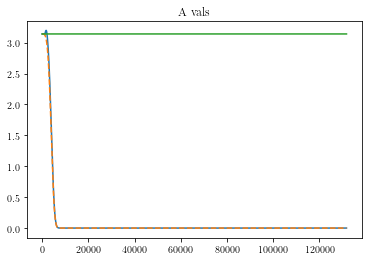

Plots for step  90 of 16000 steps
[ 2.40514047e-08  1.67462269e-01 -5.52641217e-01  1.50199762e-01
 -1.44206501e-01  6.41547427e-02 -4.02579802e-02  2.00210274e-02
 -1.08115860e-02  5.27738794e-03]


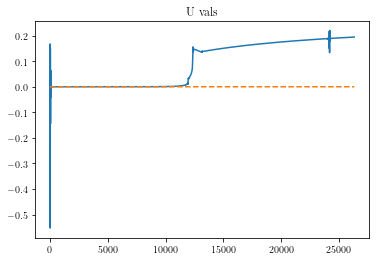

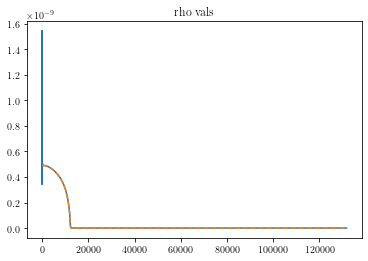

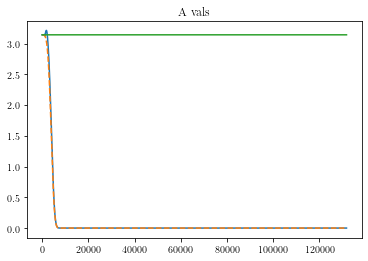

KeyboardInterrupt: 

In [451]:
###################### Full Integrator ########################
# specify initial energy distribution
U0vals = 0.0*rvals
R0vals = density_profile(rvals) #* (1 + 1000 * np.exp(-(rvals - 10000)**2 / (2*1000**2)) / (np.sqrt(2*np.pi) * 1000))
A0vals = np.pi * (np.exp(-(rvals)**4 / (2*3600**4)) / (np.sqrt(2*np.pi) * 3600)) / (np.exp(-(rvals[0])**4 / (2*3600**4)) / (np.sqrt(2*np.pi) * 3600))
P0vals = np.zeros(np.shape(rvals))

# plt.plot(rvals, A0vals)
# plt.show()
# plt.plot(rvals, first_r_derivative(A0vals))
# plt.show()
# plt.plot(rvals, R0vals)
# plt.show()

#plt.plot(rvals, R0vals)
#plt.show()

# solve for initial metric functions
metric0vals = metric_integrator(U0vals, R0vals, A0vals, P0vals)
F0vals = metric0vals[0:Nr]
G0vals = metric0vals[Nr:2*Nr]
#U0vals = metric0vals[2*Nr:3*Nr]

# plt.plot(rvals, second_r_derivative(A0vals), 'o')
# plt.xlim(0,30)
# plt.ylim(-0.0000001, 0.0000006)
# plt.show()

# plt.plot(rvals, F0vals)
# plt.show()

# plt.plot(rvals, G0vals)
# plt.show()

#plt.plot(rvals, U0vals)
#plt.show()

# set up total arrays
resolution = 20
FTotalvals, GTotalvals, UTotalvals, RTotalvals, ATotalvals, PTotalvals = np.zeros((int(Nt/resolution), Nr)), np.zeros((int(Nt/resolution), Nr)), np.zeros((int(Nt/resolution), Nr)), np.zeros((int(Nt/resolution), Nr)), np.zeros((int(Nt/resolution), Nr)), np.zeros((int(Nt/resolution), Nr))
FTotalvals[0, :] = F0vals
GTotalvals[0, :] = G0vals
UTotalvals[0, :] = U0vals
RTotalvals[0, :] = R0vals
ATotalvals[0, :] = A0vals
PTotalvals[0, :] = P0vals

F1vals = np.zeros(np.shape(F0vals))
G1vals = np.zeros(np.shape(G0vals))
U1vals = np.zeros(np.shape(U0vals))
R1vals = np.zeros(np.shape(R0vals))
A1vals = np.zeros(np.shape(A0vals))
P1vals = np.zeros(np.shape(P0vals))

# integrate
for i in range(1, Nt):
    #print(i)
    # integrate the matter sector
    matterandG1vals = matter_and_G_integrator(rvals, F0vals, G0vals, U0vals, R0vals, A0vals, P0vals)
    U1vals = matterandG1vals[0:Nr]
    R1vals = matterandG1vals[Nr:2*Nr]
    A1vals = matterandG1vals[2*Nr:3*Nr]
    P1vals = matterandG1vals[3*Nr:4*Nr]
    G1vals = matterandG1vals[4*Nr:5*Nr]

    if int(i%10) == 0:
        print("Plots for step ", str(i) + " of " + str(Nt) + " steps")
        plt.plot(rvals[0:2000], U1vals[0:2000])
        plt.plot(rvals[0:2000], UTotalvals[0,0:2000], '--')
        plt.title("U vals")
        print(U1vals[0:10])
        #plt.xlim(8000.0, 17000)
        plt.show()
        plt.plot(rvals, R1vals)
        plt.plot(rvals, RTotalvals[0,:], '--')
        plt.title("rho vals")
        plt.show()
        plt.plot(rvals, A1vals)
        plt.plot(rvals, ATotalvals[0,:], '--')
        plt.plot(rvals, np.ones(np.shape(rvals))*np.pi)
        plt.title("A vals")
        #plt.xlim(0, 30)
        plt.show()

    # integrate the metric sector
    F1vals = solve_for_F_fast(G1vals, U1vals, R1vals, A1vals, P1vals, first_r_derivative(A1vals))
    F0vals = F1vals
    G0vals = G1vals
    U0vals = U1vals
    R0vals = R1vals
    A0vals = A1vals
    P0vals = P1vals
    
    if int(i%resolution) == 0:
        FTotalvals[int(i/resolution),:] = F1vals
        GTotalvals[int(i/resolution),:] = G1vals
        UTotalvals[int(i/resolution),:] = U1vals
        RTotalvals[int(i/resolution),:] = R1vals
        ATotalvals[int(i/resolution),:] = A1vals
        PTotalvals[int(i/resolution),:] = P1vals
    
    
    

In [ ]:
plot_options = 1

colors = [(101/255, 144/255, 255/255), (121/255, 94/255, 240/255), (221/255, 38/255, 129/255), (255/255, 97/255, 2/255), (254/255, 176/255, 1/255), (200/255, 200/255, 200/255), (13/255, 35/255, 65/255), (0/255, 130/255, 61/255)]

def make_plot_slide(us, us0, rhos, rhosb, rhos0, fs, fs0, gs, gs0, ayes, ayes0, pis, pis0, plots, index, showflag):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))
    
    ax[0,0].plot(rvals / 10**3, us, color=colors[0])
    ax[0,0].plot(rvals / 10**3, us0, '--', color=colors[1])
    ax[0,0].set_xlim(rvals[0]/ 10**3, rvals[-int(Nr/2)]/ 10**3)
    ax[0,0].set_ylim(-1, 1)
    ax[0,0].set_xlabel(r'$r$ (km)', fontsize=12)
    ax[0,0].set_ylabel(r'4-velocity $u_r(t, r)$', fontsize=12)
    
    ax[0,1].plot(rvals / 10**3, rhos0, '--', color=colors[5], label='$\\rho_a(t = 0) + \\rho_b(t = 0)$')
    ax[0,1].plot(rvals / 10**3, rhos, color=colors[2], label='$\\rho_a + \\rho_b$')
    ax[0,1].plot(rvals / 10**3, rhosb, '--', color=colors[1], label='$\\rho_b$')
    ax[0,1].set_xlim(rvals[0]/ 10**3, rvals[-int(Nr/2)]/ 10**3)
    ax[0,1].set_ylim(-1.0e-10, 1.0e-9)
    ax[0,1].set_xlabel(r'$r$ (km)', fontname="serif", fontsize=12)
    ax[0,1].set_ylabel(r'Baryon Density $\rho(t, r)$', fontname="serif", fontsize=12)
    ax[0,1].legend(prop={'family': 'serif'})
    
    ax[1,0].plot(rvals / 10**3, fs**2, color=colors[0], label='$g_{tt}(t, r)$')
    ax[1,0].plot(rvals / 10**3, fs0**2, '--', color=colors[1], label='$g_{tt}(t = 0, r)$')
    ax[1,0].plot(rvals / 10**3, -gs**2, color=colors[2], label='$g_{rr}(t, r)$')
    ax[1,0].plot(rvals / 10**3, -gs0**2, '--', color=colors[3], label='$g_{rr}(t = 0, r)$')
    ax[1,0].plot(rvals / 10**3, np.log(fs0/gs0), '--', color=colors[5], label='$\\log{\\sqrt{\\frac{g_{tt}}{g_{rr}}}}$ at $t = 0$')
    ax[1,0].plot(rvals / 10**3, np.log(fs/gs), '-', color=colors[4], label='$\\log{\\sqrt{\\frac{g_{tt}}{g_{rr}}}}$')
    ax[1,0].set_xlim(rvals[0]/ 10**3, rvals[-int(Nr/2)]/ 10**3)
    ax[1,0].set_ylim(-2.8, 1.3)
    ax[1,0].set_xlabel(r'$r$ (km)', fontname="serif", fontsize=12)
    ax[1,0].set_ylabel(r'Metric Values [a.u.]', fontname="serif", fontsize=12)
    ax[1,0].legend(prop={'family': 'serif'})
    
    ax[1,1].plot(rvals / 10**3, ayes, color=colors[0])
    ax[1,1].plot(rvals / 10**3, ayes0, '--', color=colors[1])
    ax[1,1].plot(rvals / 10**3, -ayes0 + np.ones(np.shape(ayes0))*2.*np.pi, '--', color=colors[1])
    ax[1,1].plot(rvals / 10**3, np.ones(np.shape(rvals))*np.pi, '--', color=colors[2])
    ax[1,1].set_xlim(rvals[0]/ 10**3, rvals[-int(Nr/2)]/ 10**3)
    ax[1,1].set_ylim(-0.5, 6.5)
    ax[1,1].set_xlabel(r'$r$ (km)', fontname="serif", fontsize=12)
    ax[1,1].set_ylabel(r'Axion Field $a(t, r) f_a$ [a.u.]', fontname="serif", fontsize=12)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6,
                    wspace=0.6)
    
    plt.tight_layout()
    if showflag == 1:
        plt.show()
    plt.savefig("/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/axion-solutions-RK4/eps10e-3_fa10e16" + "/data/ur-nolimit/solution-" + str(str(int(index)).zfill(4)) + ".png", dpi=150, facecolor='white', transparent=False)
    plt.close()

In [41]:
TotalDensityvals = np.zeros(np.shape(RTotalvals))
for i in range(np.shape(TotalDensityvals)[0]):
    TotalDensityvals[i,:] = inside_density(rvals, GTotalvals[i,:], UTotalvals[i,:], RTotalvals[i,:], ATotalvals[i,:], PTotalvals[i,:], first_r_derivative(ATotalvals[i,:]))

<ipython-input-31-7cb4934cb029>:3: RuntimeWarning: divide by zero encountered in power
  return R0 + epsilon*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2) + myabs(cos(A0/2.))*(R0*sigmaN*pow(mN,-1) - epsilon*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2)) + (pow(G0,-2)*pow(GeV2m,2)*pow(hbarGeo,-1)*(pow(dAdr,2)*pow(fa,2) + pow(fa,2)*pow(P0,2)))/2. + (R0 + EOS(R0))*pow(G0,2)*pow(U0,2)
<ipython-input-31-7cb4934cb029>:3: RuntimeWarning: invalid value encountered in multiply
  return R0 + epsilon*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2) + myabs(cos(A0/2.))*(R0*sigmaN*pow(mN,-1) - epsilon*pow(fpi,2)*pow(GeV2m,4)*pow(hbarGeo,-3)*pow(mpi,2)) + (pow(G0,-2)*pow(GeV2m,2)*pow(hbarGeo,-1)*(pow(dAdr,2)*pow(fa,2) + pow(fa,2)*pow(P0,2)))/2. + (R0 + EOS(R0))*pow(G0,2)*pow(U0,2)


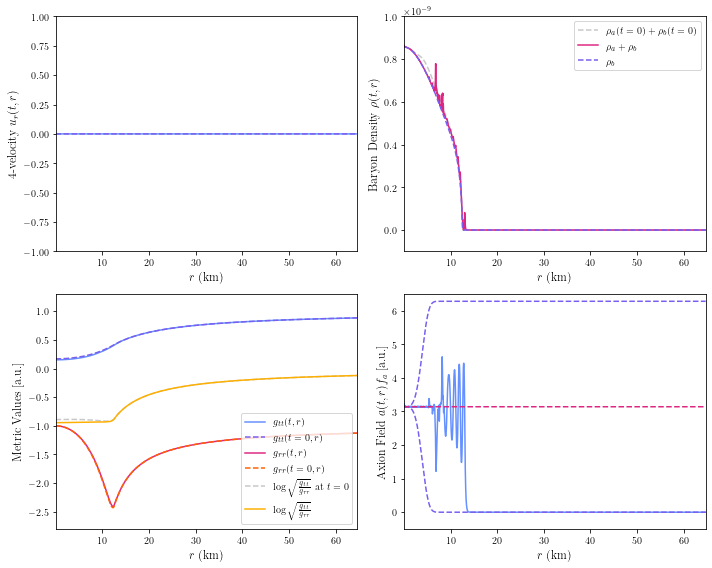

In [44]:
myindex = 300
make_plot_slide(UTotalvals[myindex,:], UTotalvals[0,:], TotalDensityvals[myindex,:], RTotalvals[myindex,:], TotalDensityvals[0,:], FTotalvals[myindex,:], FTotalvals[0,:], GTotalvals[myindex,:], GTotalvals[0,:], ATotalvals[myindex,:], ATotalvals[0,:], PTotalvals[myindex,:], PTotalvals[0,:], 1, myindex, 1)


Done with image 0 of 800
Done with image 20 of 800
Done with image 40 of 800
Done with image 60 of 800
Done with image 80 of 800
Done with image 100 of 800
Done with image 120 of 800
Done with image 140 of 800
Done with image 160 of 800
Done with image 180 of 800
Done with image 200 of 800
Done with image 220 of 800
Done with image 240 of 800
Done with image 260 of 800
Done with image 280 of 800
Done with image 300 of 800
Done with image 320 of 800
Done with image 340 of 800
Done with image 360 of 800
Done with image 380 of 800
Done with image 400 of 800
Done with image 420 of 800
Done with image 440 of 800
Done with image 460 of 800
Done with image 480 of 800
Done with image 500 of 800
Done with image 520 of 800
Done with image 540 of 800
Done with image 560 of 800
Done with image 580 of 800
Done with image 600 of 800
Done with image 620 of 800
Done with image 640 of 800
Done with image 660 of 800
Done with image 680 of 800
Done with image 700 of 800
Done with image 720 of 800


<ipython-input-43-cd09193cbdb0>:29: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].plot(rvals / 10**3, np.log(fs/gs), '-', color=colors[4], label='$\\log{\\sqrt{\\frac{g_{tt}}{g_{rr}}}}$')
<ipython-input-43-cd09193cbdb0>:29: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].plot(rvals / 10**3, np.log(fs/gs), '-', color=colors[4], label='$\\log{\\sqrt{\\frac{g_{tt}}{g_{rr}}}}$')
<ipython-input-43-cd09193cbdb0>:29: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].plot(rvals / 10**3, np.log(fs/gs), '-', color=colors[4], label='$\\log{\\sqrt{\\frac{g_{tt}}{g_{rr}}}}$')
<ipython-input-43-cd09193cbdb0>:29: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].plot(rvals / 10**3, np.log(fs/gs), '-', color=colors[4], label='$\\log{\\sqrt{\\frac{g_{tt}}{g_{rr}}}}$')
<ipython-input-43-cd09193cbdb0>:29: RuntimeWarning: invalid value encountered in true_divide
  ax[1,0].plot(rvals / 10**3, np.log(fs/gs), '-', color=colors[4], labe

KeyboardInterrupt: 

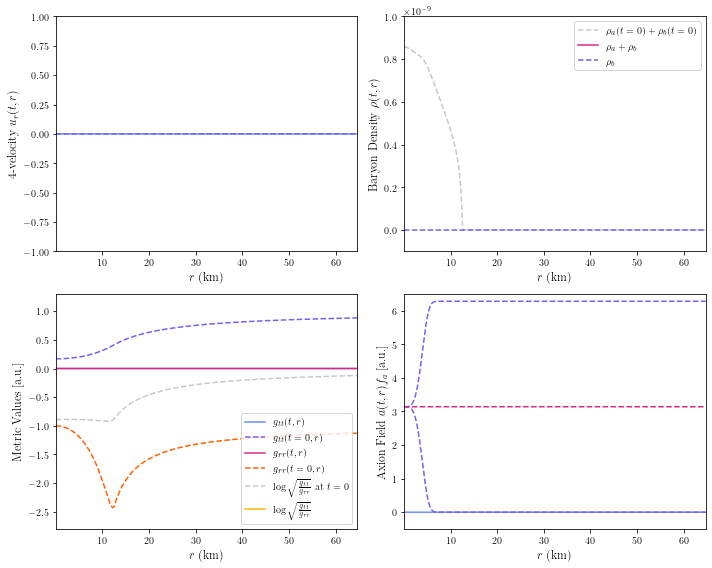

In [45]:
for i in range(0, int(Nt/resolution)):
    make_plot_slide(UTotalvals[i,:], UTotalvals[0,:], TotalDensityvals[i,:], RTotalvals[i,:], TotalDensityvals[0,:], FTotalvals[i,:], FTotalvals[0,:], GTotalvals[i,:], GTotalvals[0,:], ATotalvals[i,:], ATotalvals[0,:], PTotalvals[i,:], PTotalvals[0,:], 1, i, 0)
    if int(i%20)==0:
        print("Done with image " + str(i) + " of " + str(int(Nt/20)))
    

There's an obvious problem where the axion field gets an energy injection artificially. You can see that when it drops below it's initial condition. It should really stay within the envelope. Perhaps a leapfrog integration will work better to prevent that. Or adding intermediate metric solvers for the half steps of the RK4 matter integrator.

Half steps in RK4 doesn't work, it actually becomes unstable earlier.

Something else to consider is some function that eliminates unphysical oscillations in the axion field. If we could get the grid spacing to be less than the lowest expected wavelength, then we could eliminate any oscillations that are shorter wavelength than the lowest expected. That might solve the issue. Need to determine what the lowest possible wavelength is.

Also could try this spline or lagrange or hermite fitting between points.

What about fixing 


Where does the energy dissipated through friction go? Should it radiate out of the system or should it just get thrown into the baryons or the metric or something?

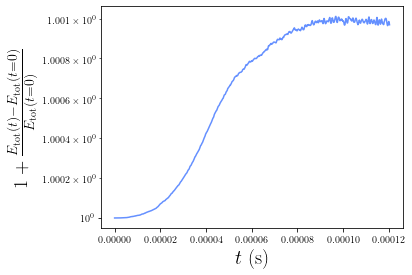

In [61]:
# make plot of fractional change in total energy in the system

def get_total_inside_mass_from_density_fast(rvals, totalinsidedensity):
    integral = (dr/2) * 4 * np.pi * (rvals**2 * totalinsidedensity + np.roll(rvals, -1, 0)**2 * np.roll(totalinsidedensity, -1, 0))
    integral = np.sum(integral) - integral[-1]
    return integral;

TotalInsideEnergies = np.zeros(int(Nt/resolution))
for i in range(int(Nt/resolution)):
    TotalInsideEnergies[i] = get_total_inside_mass_from_density_fast(rvals, TotalDensityvals[i, :])
    
FractionalChangeInEnergies = np.ones(np.shape(TotalInsideEnergies)) + (TotalInsideEnergies - np.ones(np.shape(TotalInsideEnergies))*TotalInsideEnergies[0]) / TotalInsideEnergies[0]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (7, 4))
ax.plot(tvals[0:-1:resolution] / clight, FractionalChangeInEnergies, '-', color=colors[0])
ax.set_yscale("log")
ax.set_xlabel(r'$t$ (s)', fontsize=20)
ax.set_ylabel('$1 + \\frac{E_{\\mathrm{tot}}(t) - E_{\\mathrm{tot}}(t = 0)}{E_{\\mathrm{tot}}(t = 0)}$', fontsize=20)
plt.subplots_adjust(top=0.92, bottom=0.15, left=0.35, right=0.95, hspace=0.6,
                    wspace=0.6)
plt.savefig("/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/axion-solutions-RK4/eps10e-3_fa10e16/data/ur-nolimit" + "/energy-dissipation.png", dpi=300, facecolor='white', transparent=False)
plt.show()

In [39]:
np.savetxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/axion-solutions-RK4/eps10e-3_fa10e16/data/ur-nolimit" + "/gtt-full.csv", FTotalvals[0:-1, :], delimiter=',')
np.savetxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/axion-solutions-RK4/eps10e-3_fa10e16/data/ur-nolimit" + "/grr-full.csv", GTotalvals[0:-1, :], delimiter=',')
np.savetxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/axion-solutions-RK4/eps10e-3_fa10e16/data/ur-nolimit" + "/ur-full.csv", UTotalvals[0:-1, :], delimiter=',')
np.savetxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/axion-solutions-RK4/eps10e-3_fa10e16/data/ur-nolimit" + "/rho-full.csv", RTotalvals[0:-1, :], delimiter=',')
np.savetxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/axion-solutions-RK4/eps10e-3_fa10e16/data/ur-nolimit" + "/a-full.csv", ATotalvals[0:-1, :], delimiter=',')
np.savetxt("/Users/wentmich/Documents/uiuc/research/axions-in-NS/python/EOS-1-functions/axion-solutions-RK4/eps10e-3_fa10e16/data/ur-nolimit" + "/pi-full.csv", PTotalvals[0:-1, :], delimiter=',')

Plots for step  10 of 4000 steps


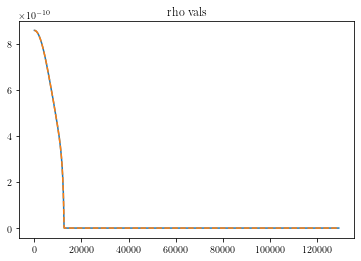

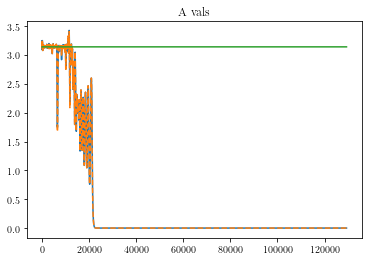

Plots for step  20 of 4000 steps


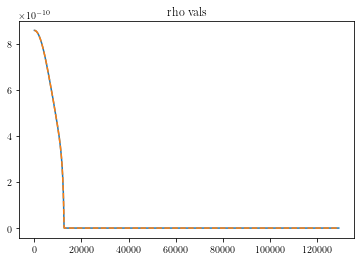

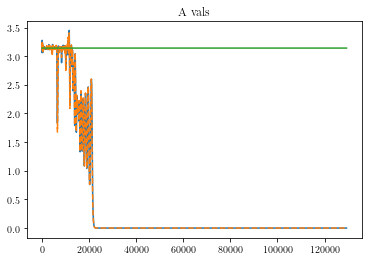

Plots for step  30 of 4000 steps


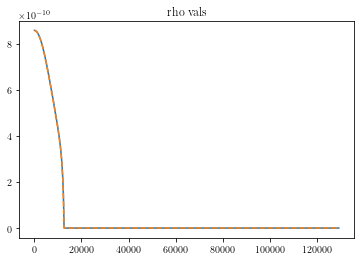

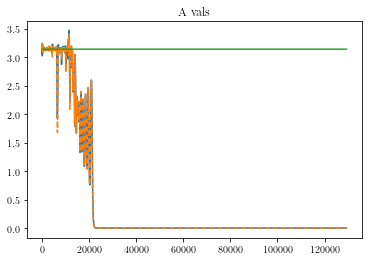

Plots for step  40 of 4000 steps


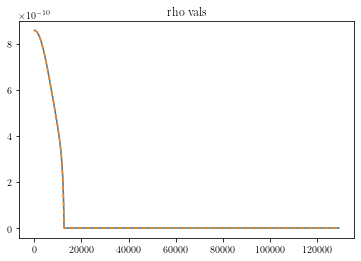

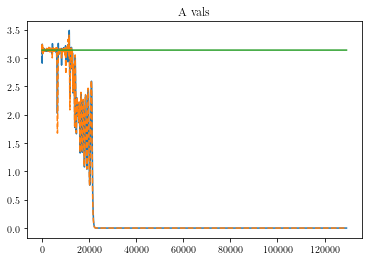

Plots for step  50 of 4000 steps


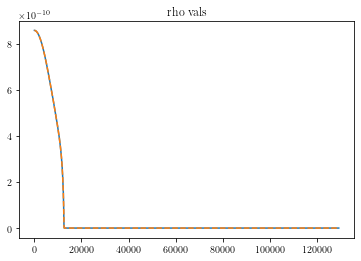

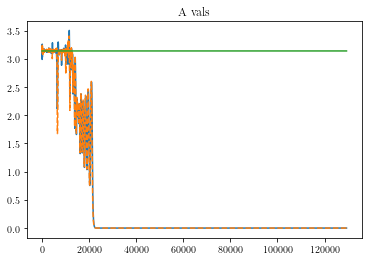

Plots for step  60 of 4000 steps


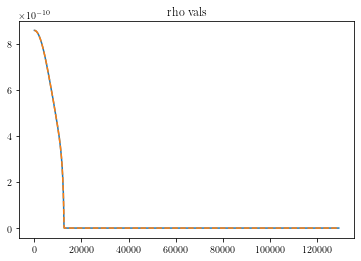

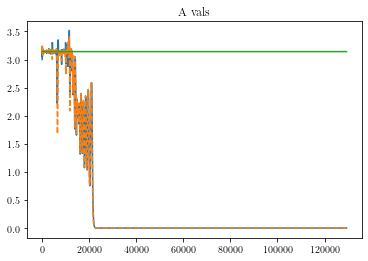

Plots for step  70 of 4000 steps


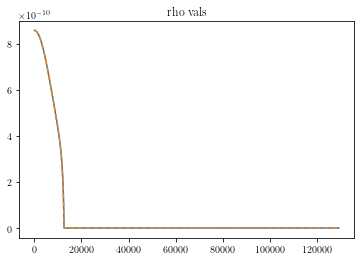

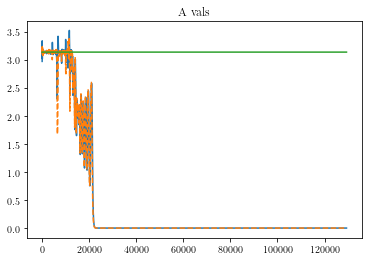

Plots for step  80 of 4000 steps


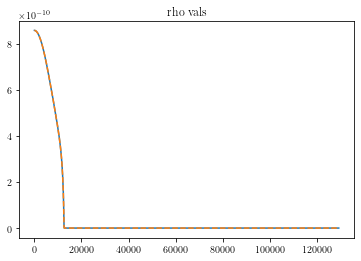

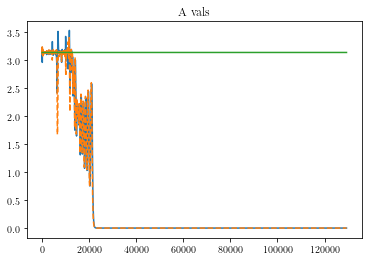

Plots for step  90 of 4000 steps


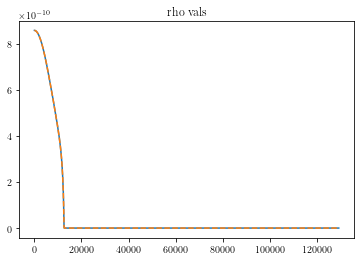

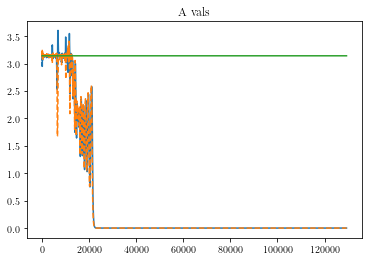

Plots for step  100 of 4000 steps


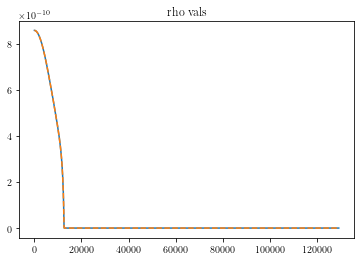

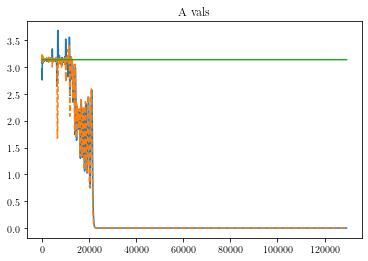

Plots for step  110 of 4000 steps


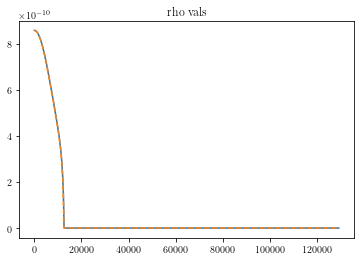

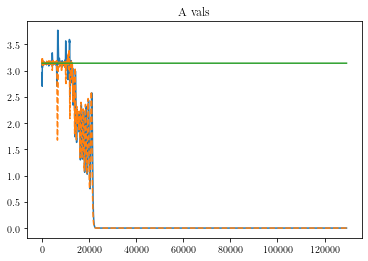

Plots for step  120 of 4000 steps


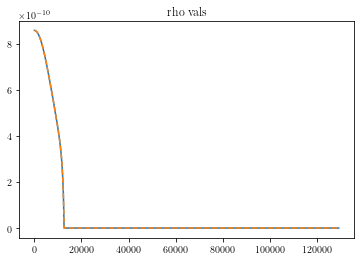

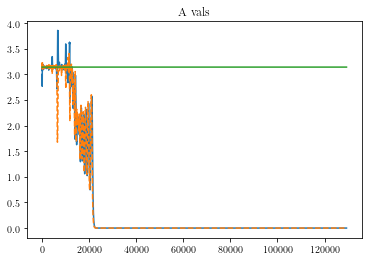

Plots for step  130 of 4000 steps


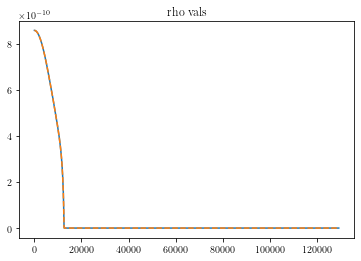

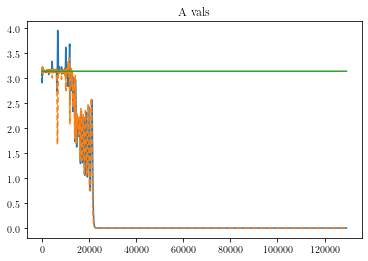

Plots for step  140 of 4000 steps


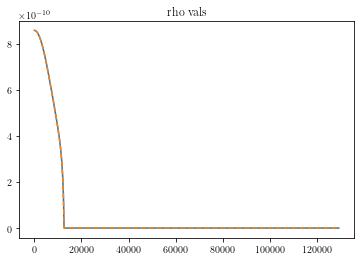

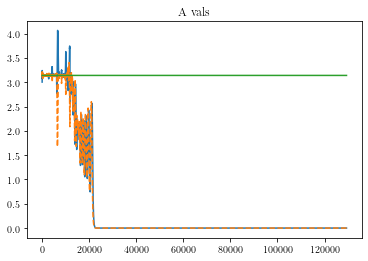

Plots for step  150 of 4000 steps


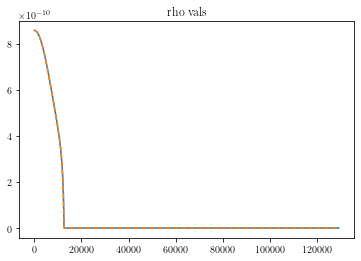

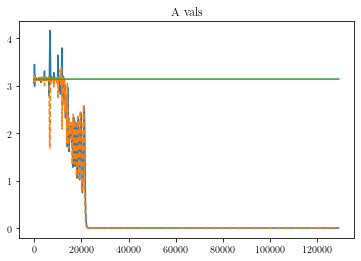

Plots for step  160 of 4000 steps


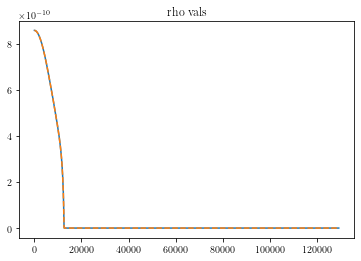

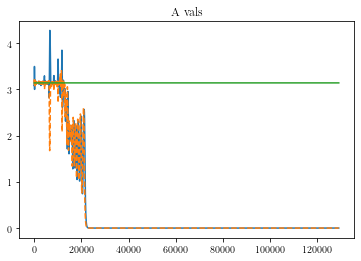

Plots for step  170 of 4000 steps


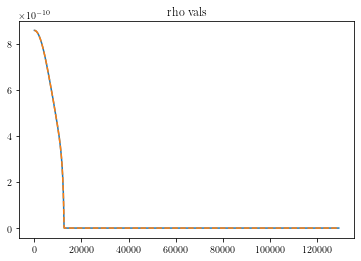

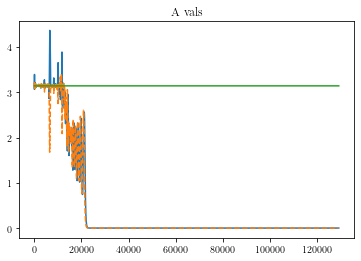

Plots for step  180 of 4000 steps


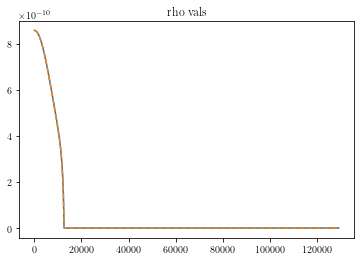

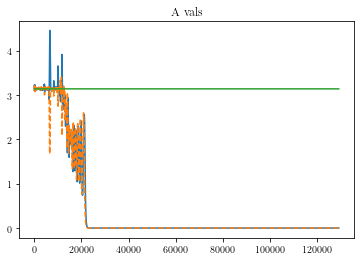

Plots for step  190 of 4000 steps


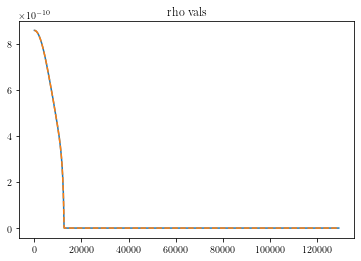

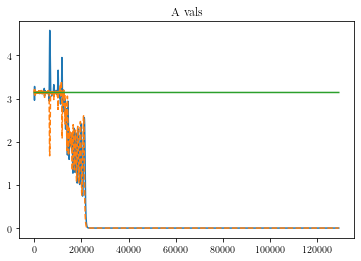

Plots for step  200 of 4000 steps


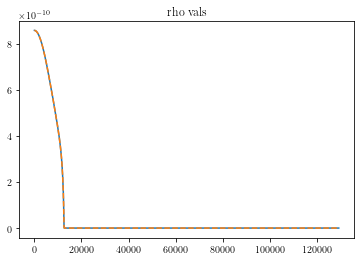

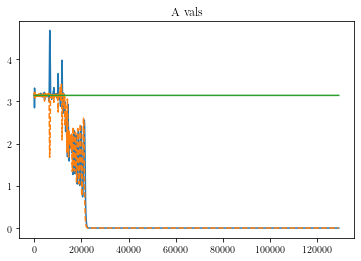

Plots for step  210 of 4000 steps


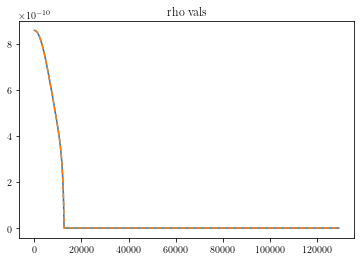

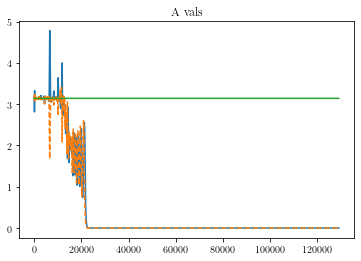

Plots for step  220 of 4000 steps


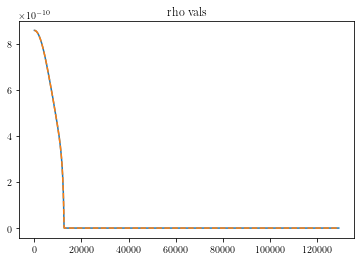

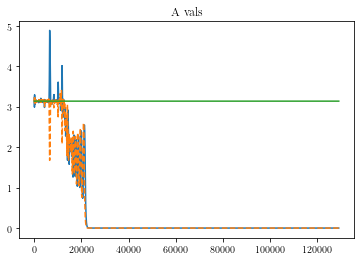

Plots for step  230 of 4000 steps


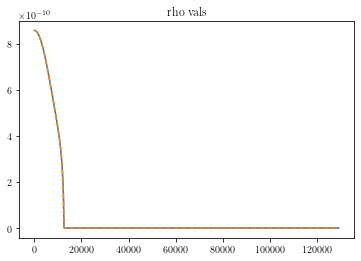

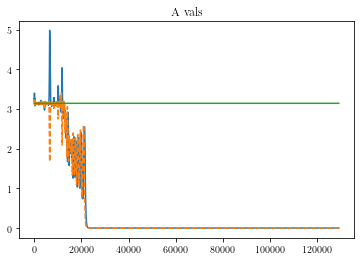

Plots for step  240 of 4000 steps


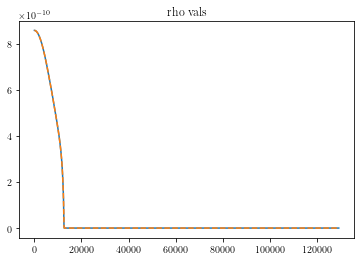

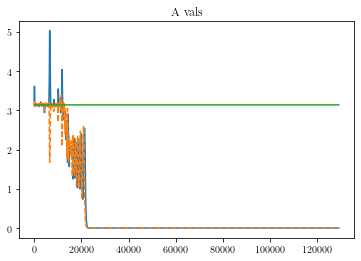

Plots for step  250 of 4000 steps


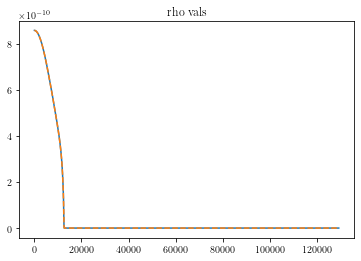

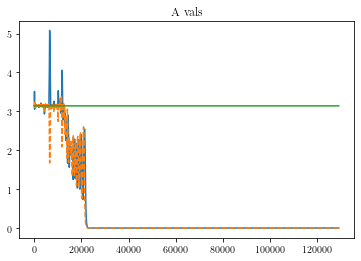

Plots for step  260 of 4000 steps


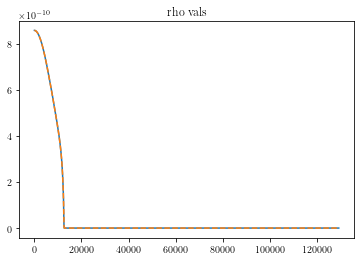

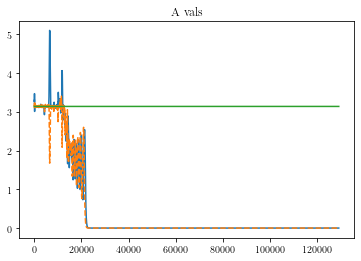

Plots for step  270 of 4000 steps


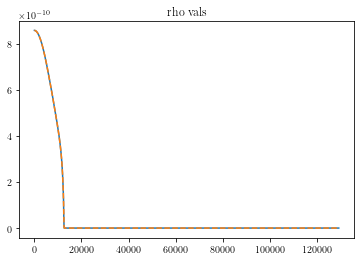

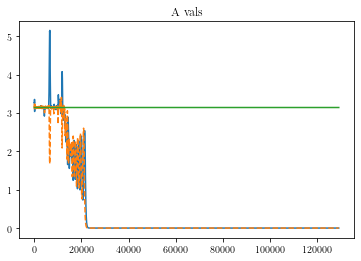

Plots for step  280 of 4000 steps


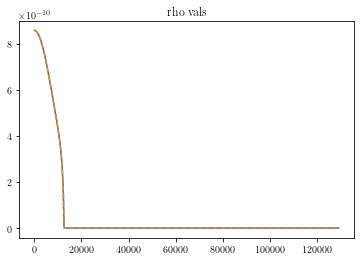

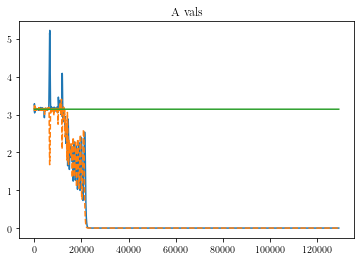

Plots for step  290 of 4000 steps


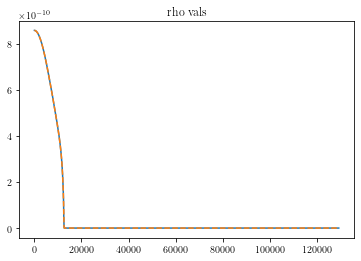

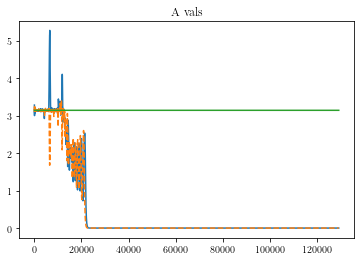

Plots for step  300 of 4000 steps


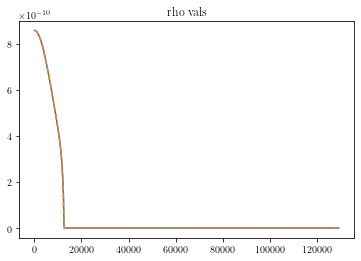

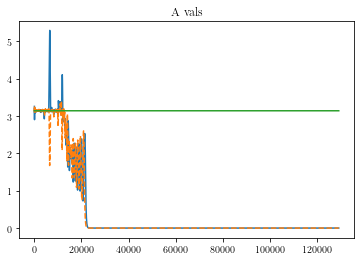

Plots for step  310 of 4000 steps


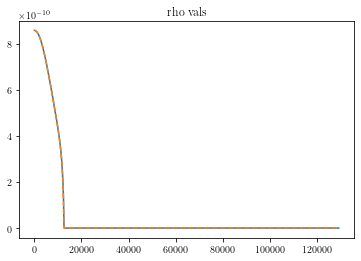

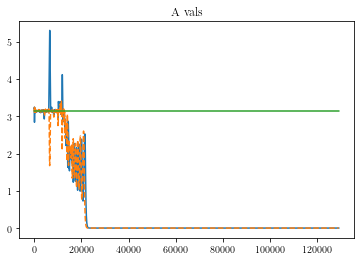

Plots for step  320 of 4000 steps


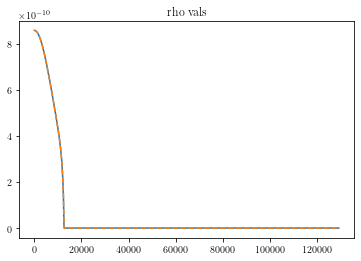

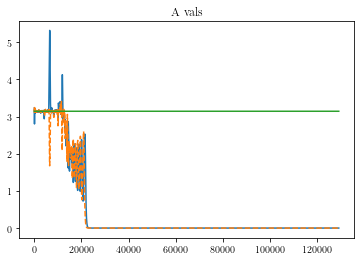

Plots for step  330 of 4000 steps


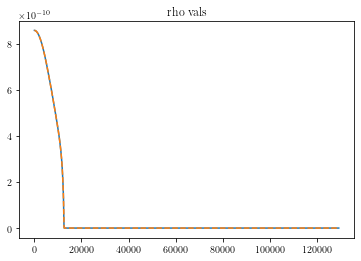

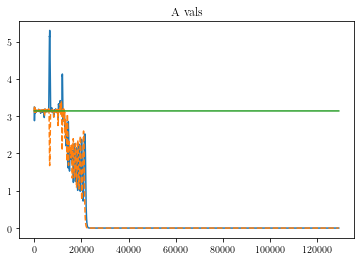

Plots for step  340 of 4000 steps


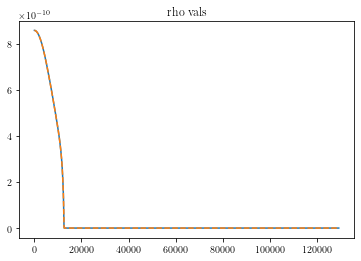

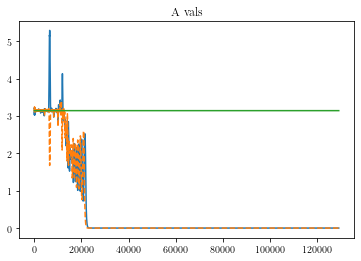

Plots for step  350 of 4000 steps


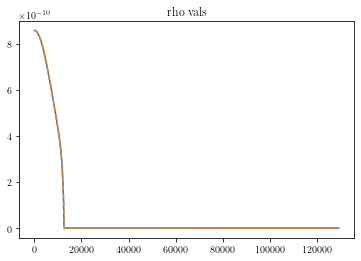

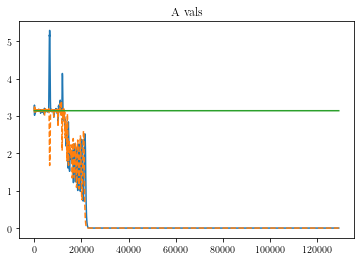

Plots for step  360 of 4000 steps


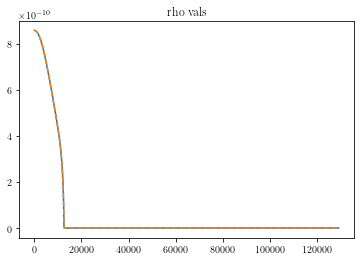

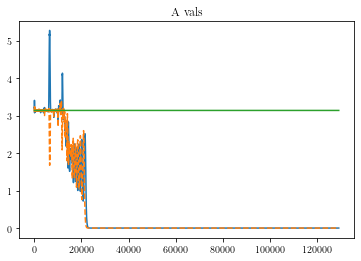

Plots for step  370 of 4000 steps


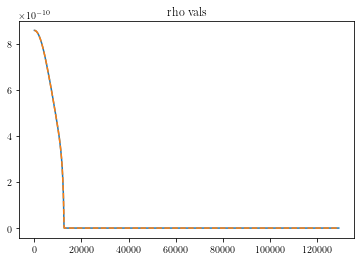

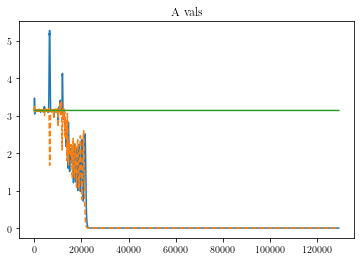

Plots for step  380 of 4000 steps


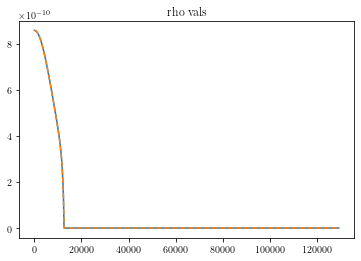

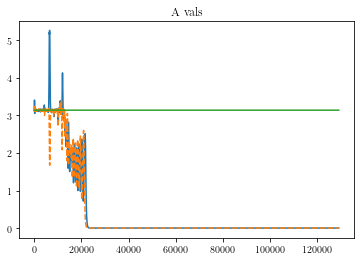

Plots for step  390 of 4000 steps


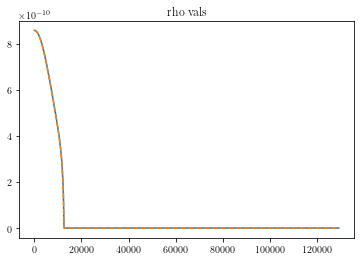

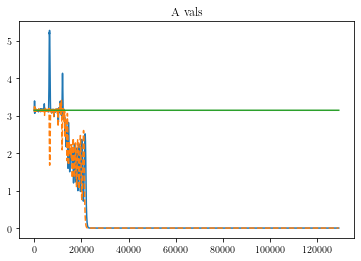

Plots for step  400 of 4000 steps


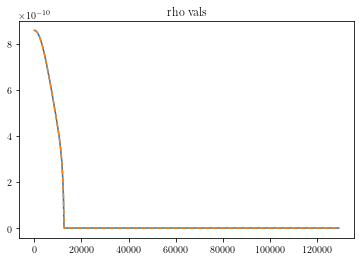

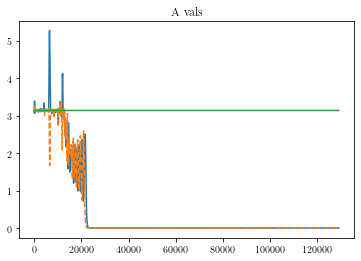

Plots for step  410 of 4000 steps


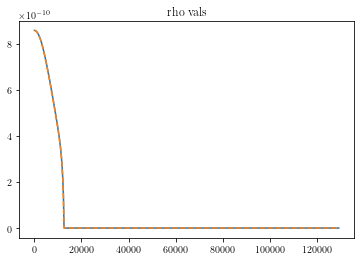

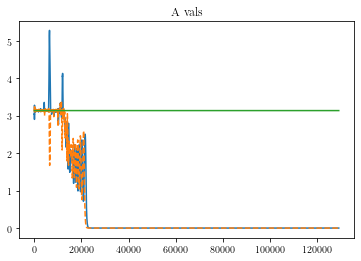

Plots for step  420 of 4000 steps


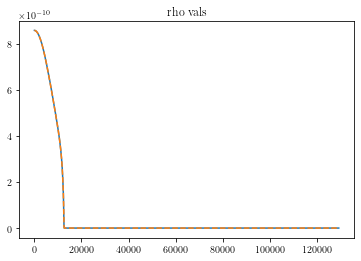

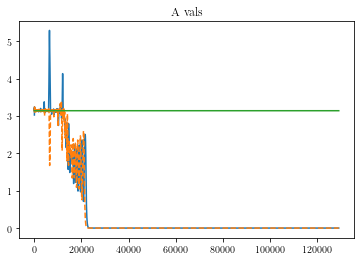

Plots for step  430 of 4000 steps


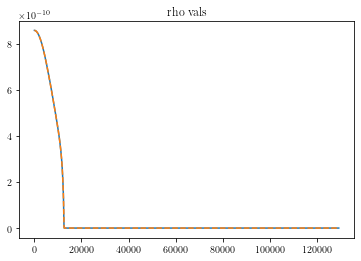

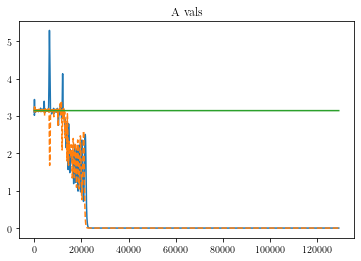

Plots for step  440 of 4000 steps


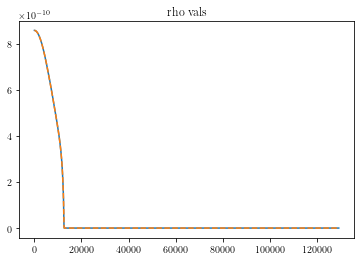

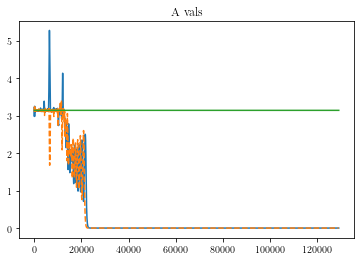

Plots for step  450 of 4000 steps


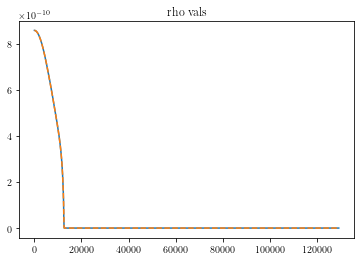

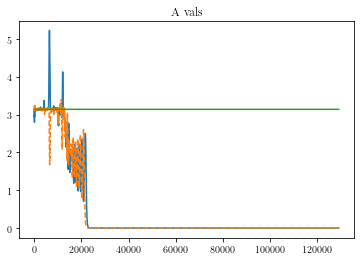

Plots for step  460 of 4000 steps


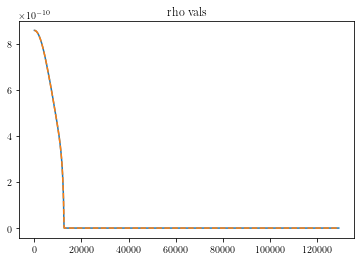

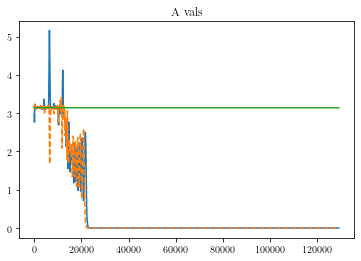

Plots for step  470 of 4000 steps


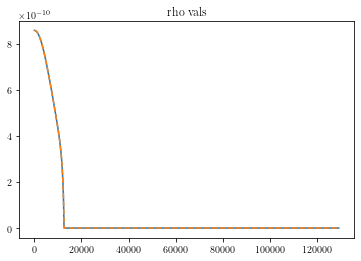

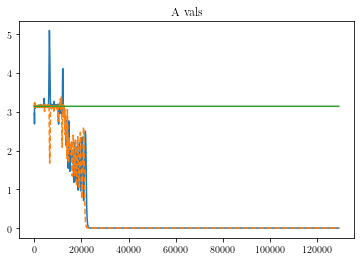

Plots for step  480 of 4000 steps


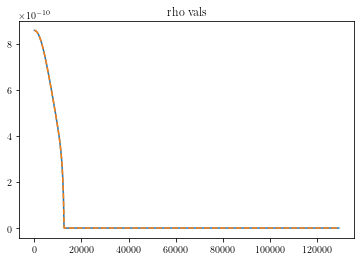

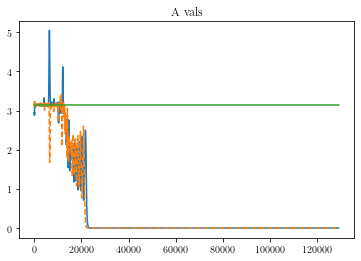

Plots for step  490 of 4000 steps


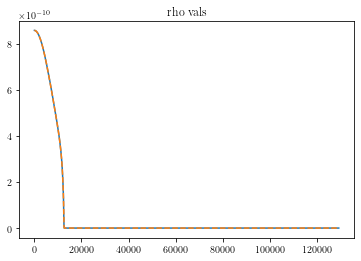

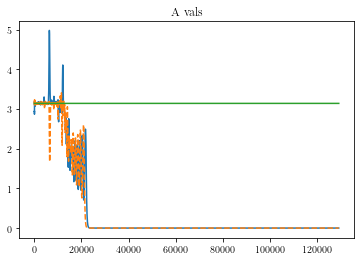

Plots for step  500 of 4000 steps


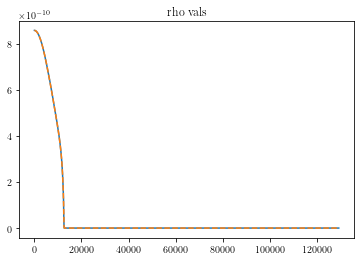

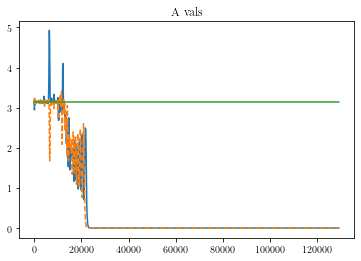

Plots for step  510 of 4000 steps


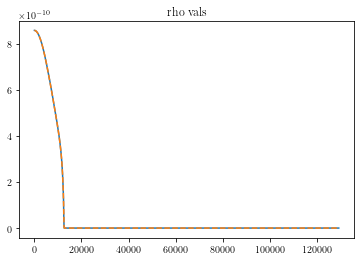

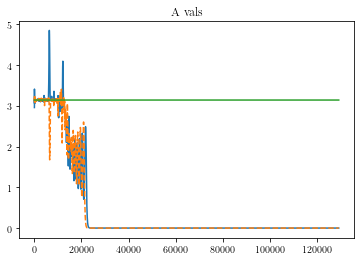

Plots for step  520 of 4000 steps


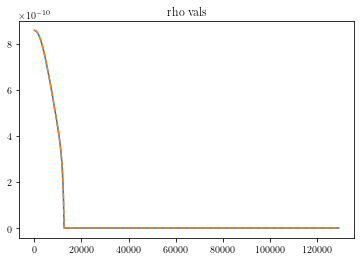

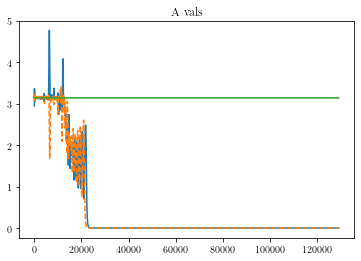

Plots for step  530 of 4000 steps


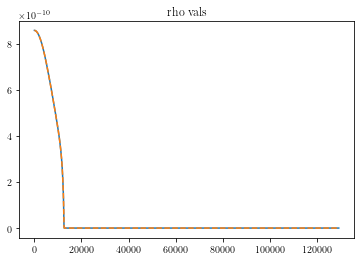

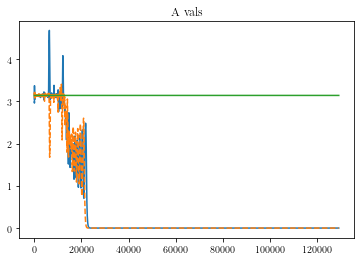

Plots for step  540 of 4000 steps


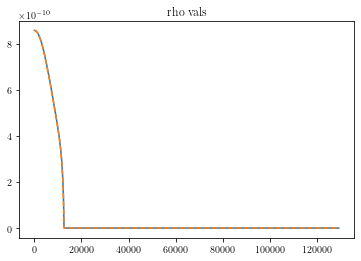

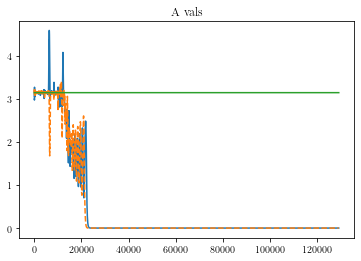

Plots for step  550 of 4000 steps


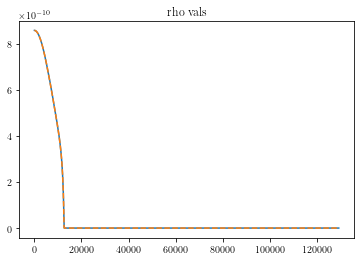

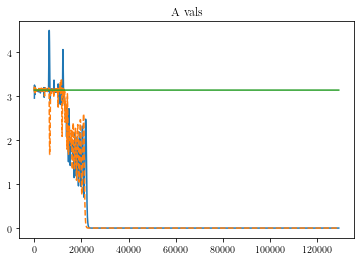

Plots for step  560 of 4000 steps


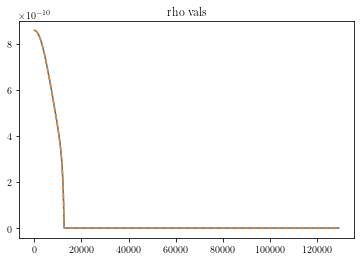

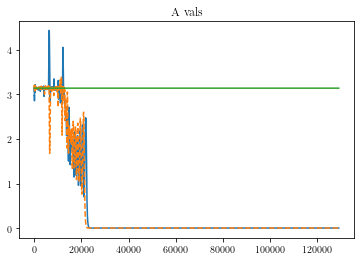

Plots for step  570 of 4000 steps


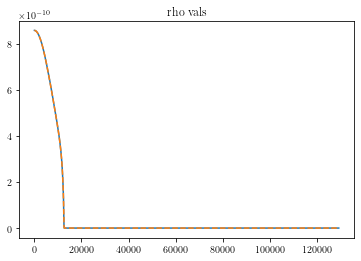

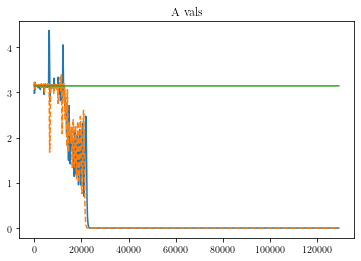

Plots for step  580 of 4000 steps


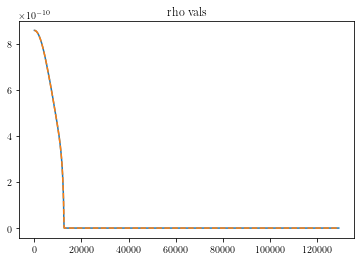

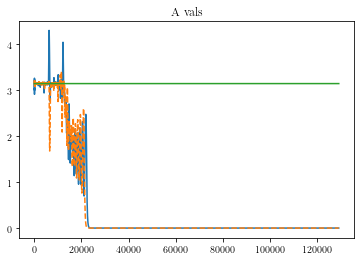

Plots for step  590 of 4000 steps


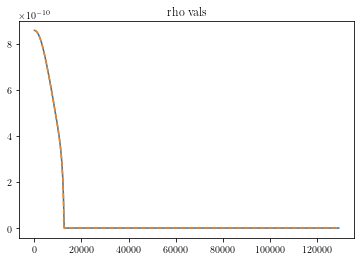

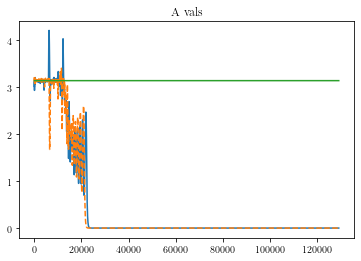

Plots for step  600 of 4000 steps


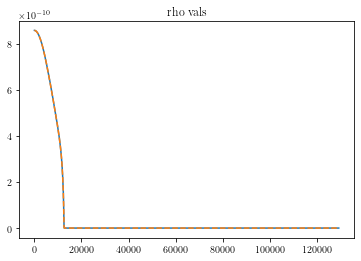

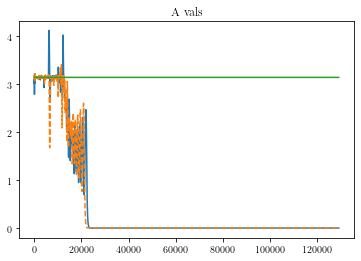

Plots for step  610 of 4000 steps


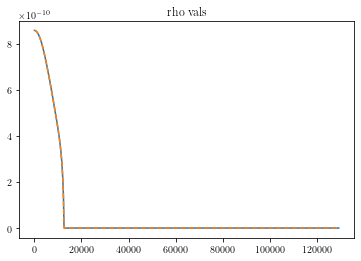

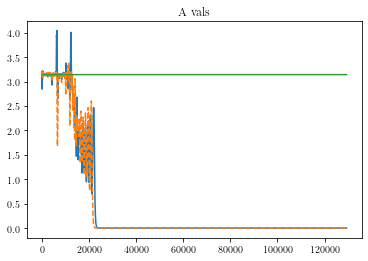

Plots for step  620 of 4000 steps


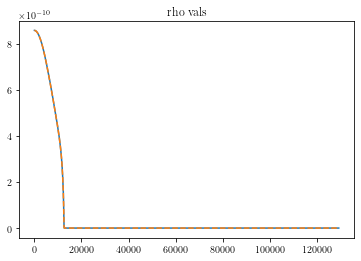

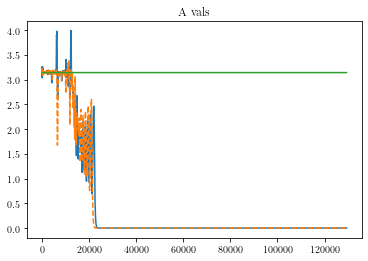

Plots for step  630 of 4000 steps


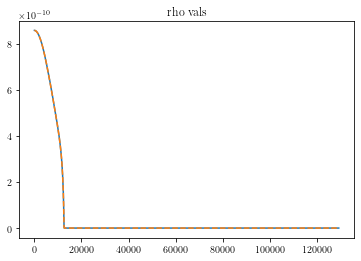

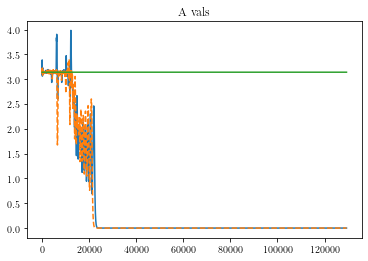

Plots for step  640 of 4000 steps


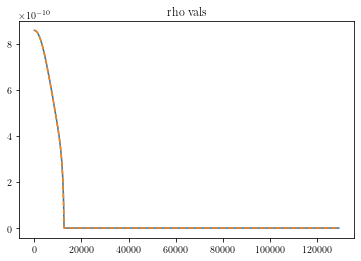

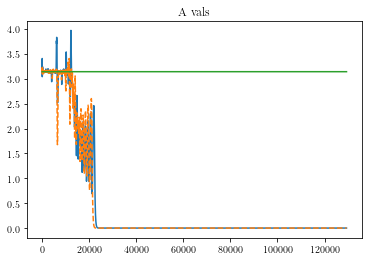

Plots for step  650 of 4000 steps


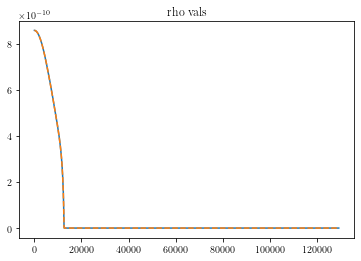

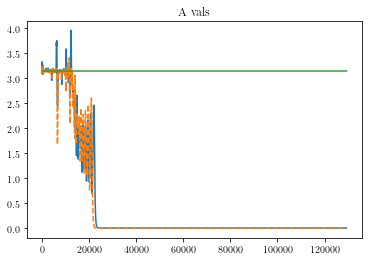

Plots for step  660 of 4000 steps


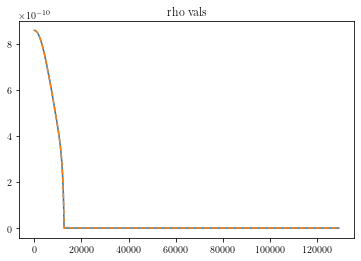

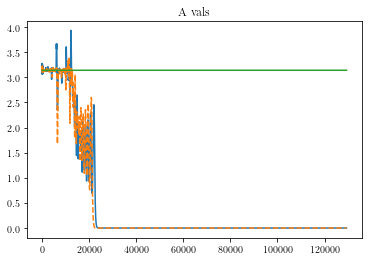

Plots for step  670 of 4000 steps


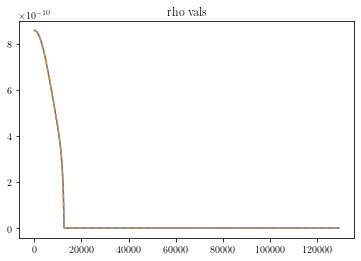

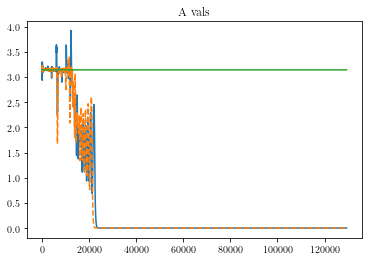

Plots for step  680 of 4000 steps


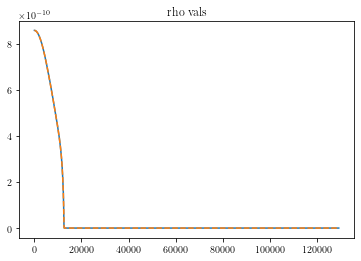

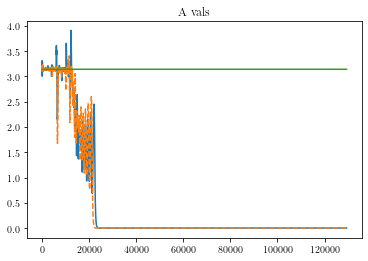

Plots for step  690 of 4000 steps


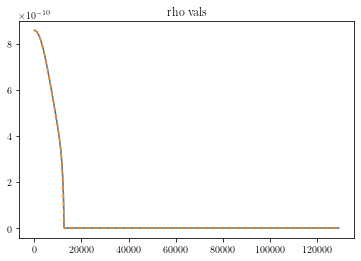

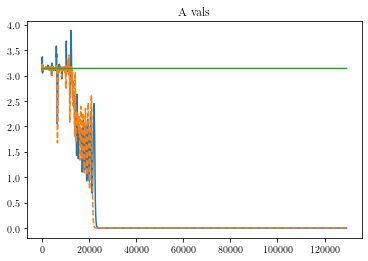

Plots for step  700 of 4000 steps


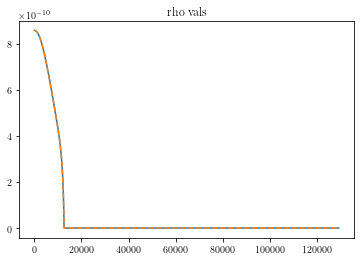

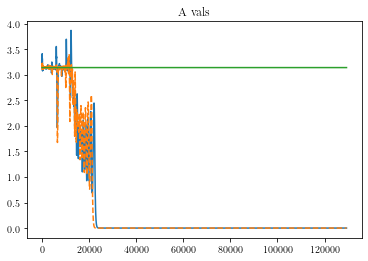

Plots for step  710 of 4000 steps


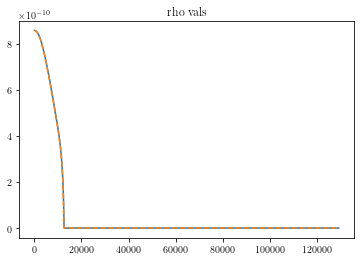

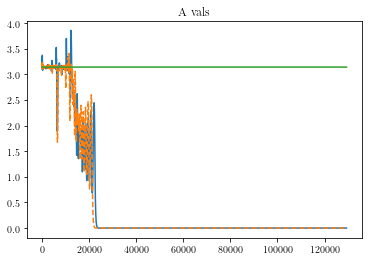

Plots for step  720 of 4000 steps


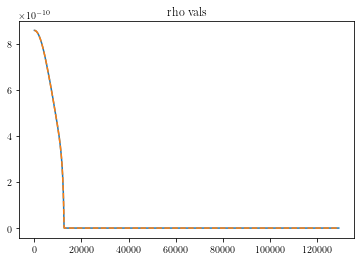

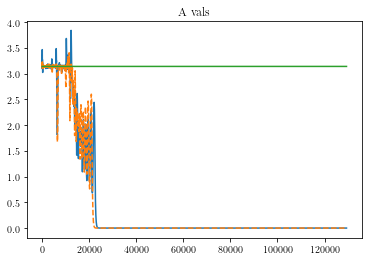

Plots for step  730 of 4000 steps


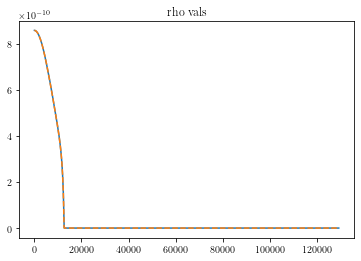

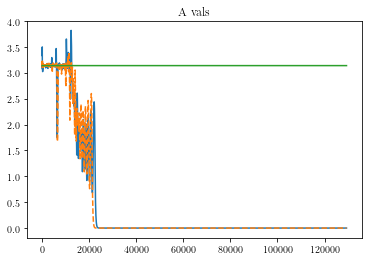

Plots for step  740 of 4000 steps


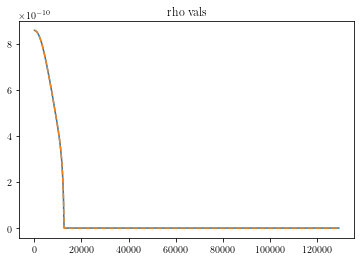

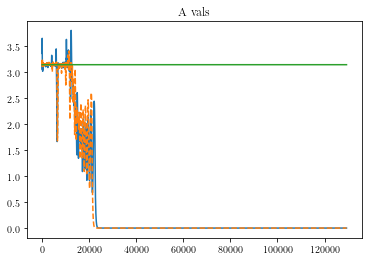

Plots for step  750 of 4000 steps


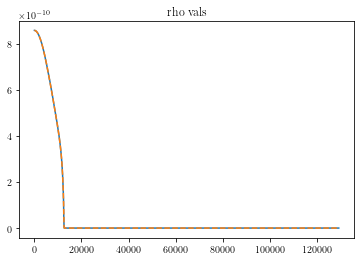

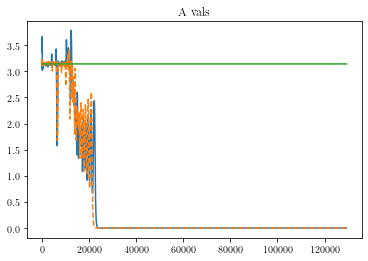

Plots for step  760 of 4000 steps


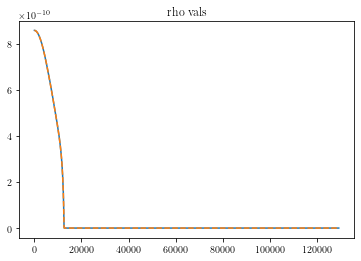

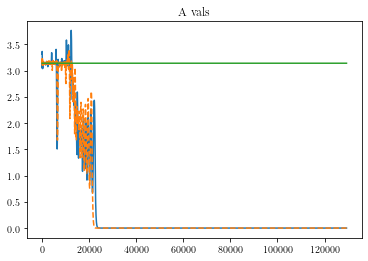

Plots for step  770 of 4000 steps


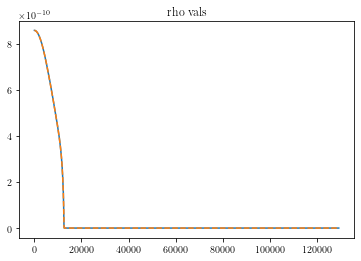

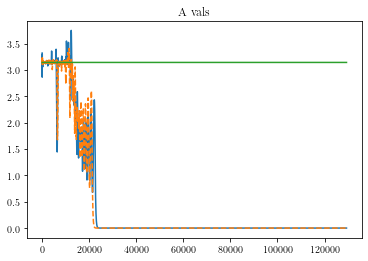

Plots for step  780 of 4000 steps


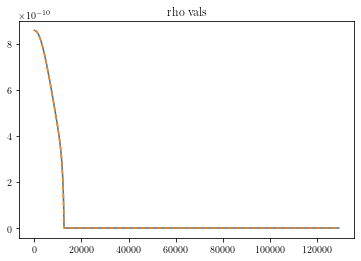

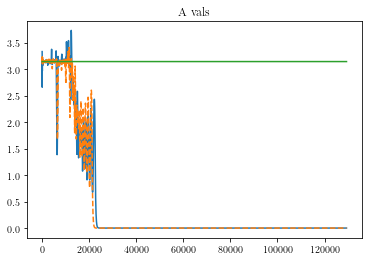

Plots for step  790 of 4000 steps


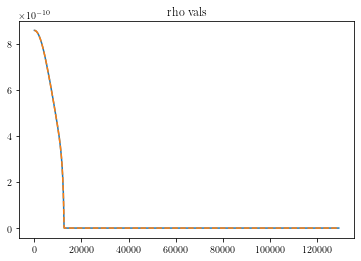

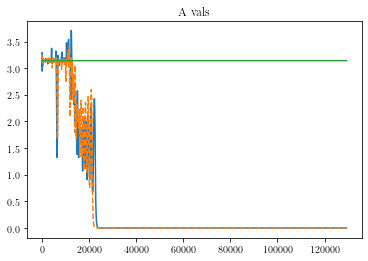

Plots for step  800 of 4000 steps


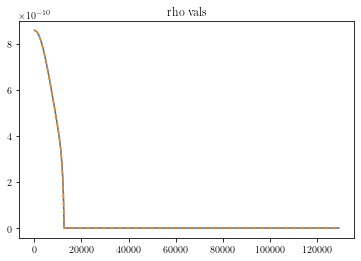

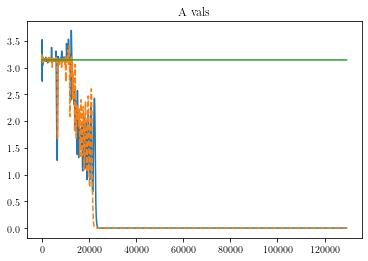

Plots for step  810 of 4000 steps


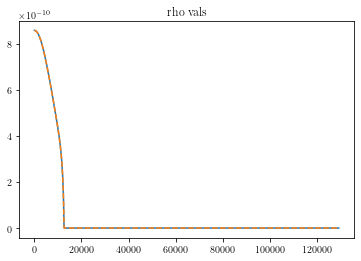

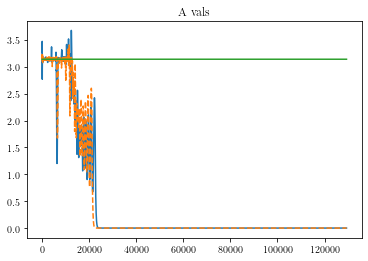

Plots for step  820 of 4000 steps


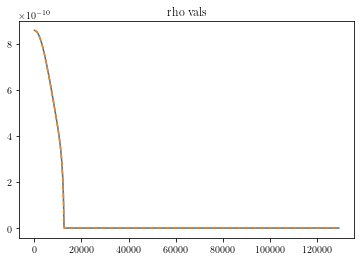

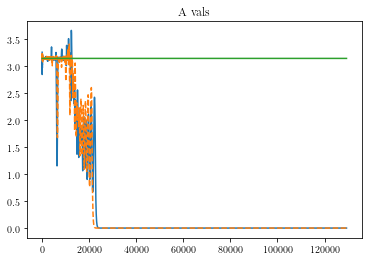

Plots for step  830 of 4000 steps


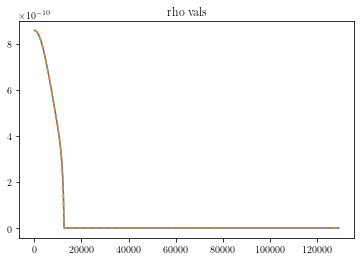

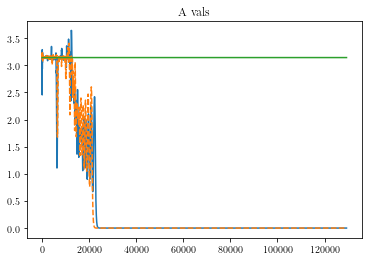

Plots for step  840 of 4000 steps


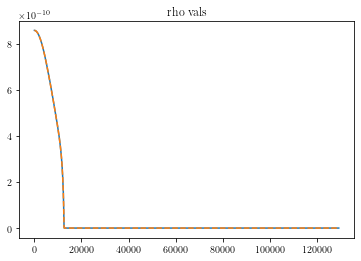

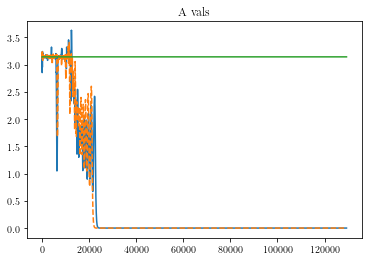

Plots for step  850 of 4000 steps


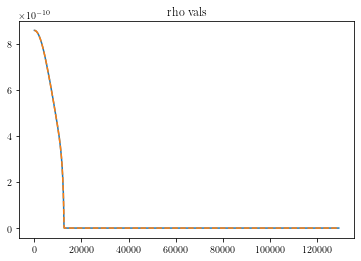

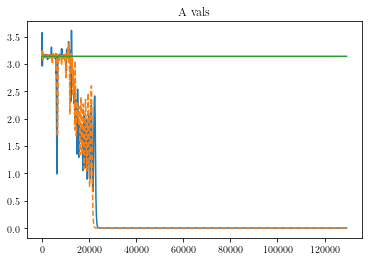

Plots for step  860 of 4000 steps


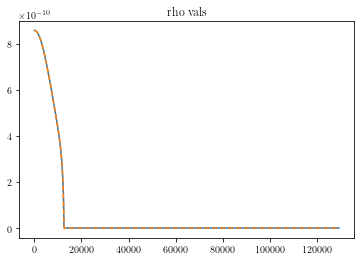

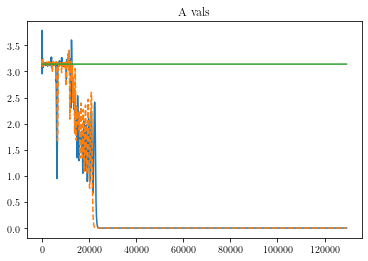

Plots for step  870 of 4000 steps


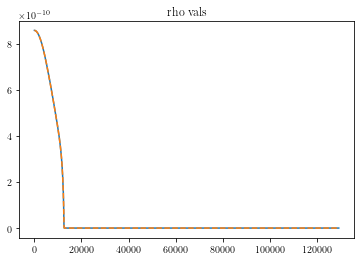

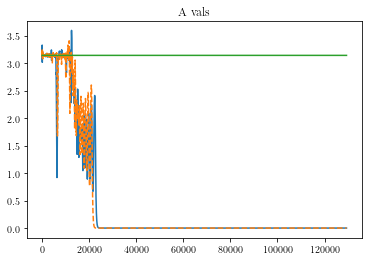

Plots for step  880 of 4000 steps


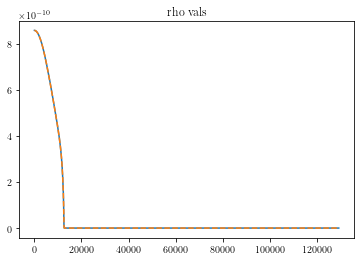

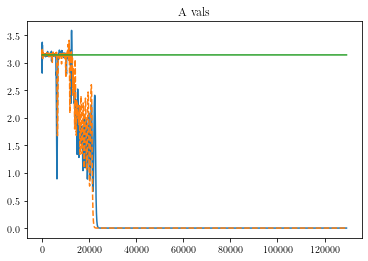

Plots for step  890 of 4000 steps


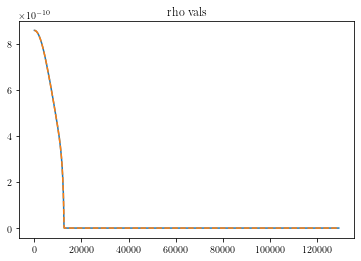

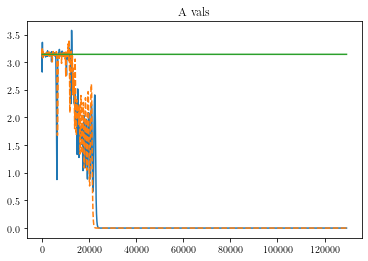

Plots for step  900 of 4000 steps


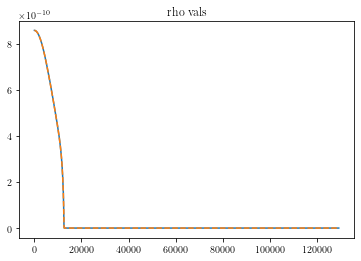

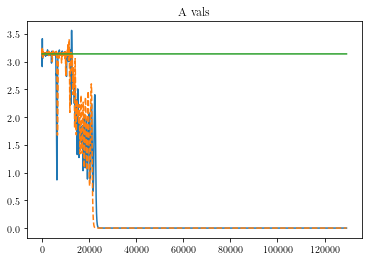

Plots for step  910 of 4000 steps


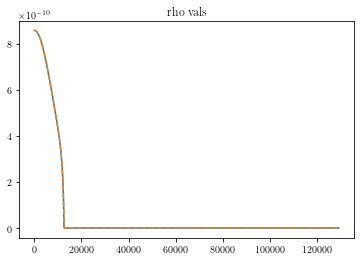

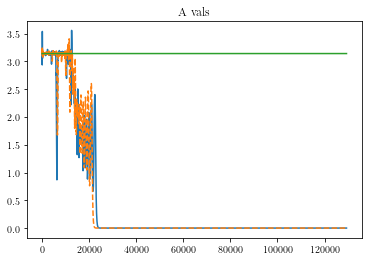

Plots for step  920 of 4000 steps


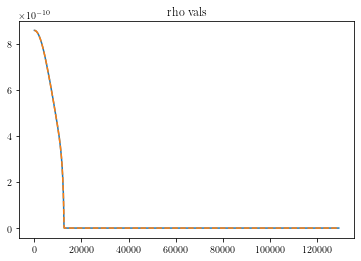

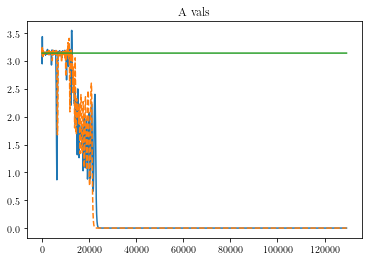

Plots for step  930 of 4000 steps


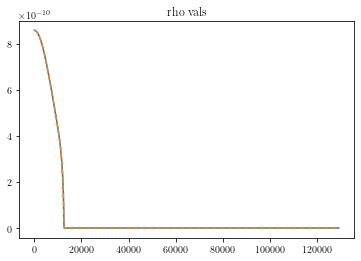

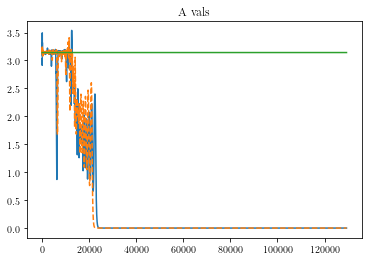

Plots for step  940 of 4000 steps


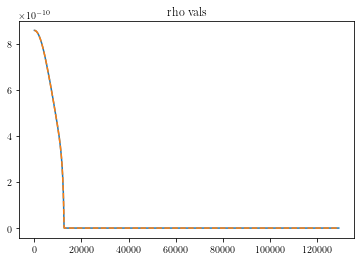

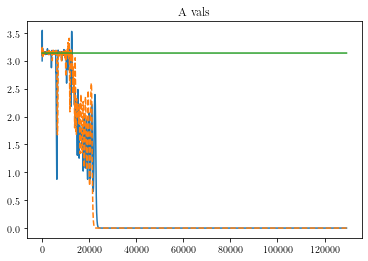

Plots for step  950 of 4000 steps


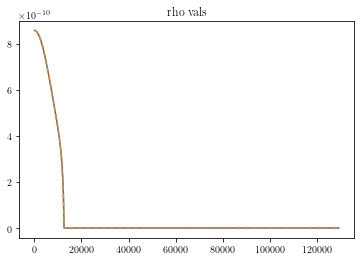

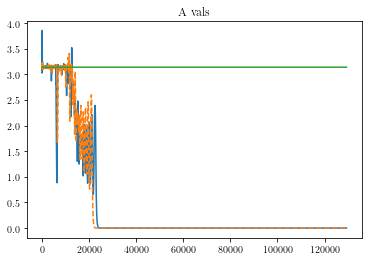

Plots for step  960 of 4000 steps


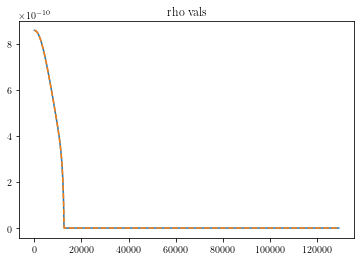

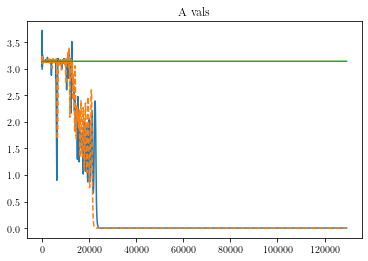

Plots for step  970 of 4000 steps


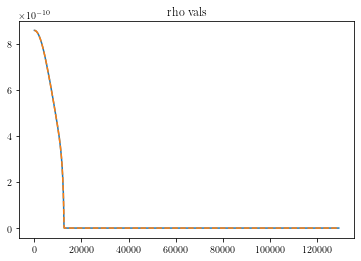

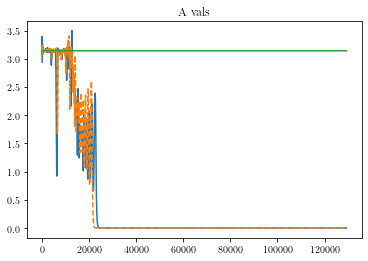

Plots for step  980 of 4000 steps


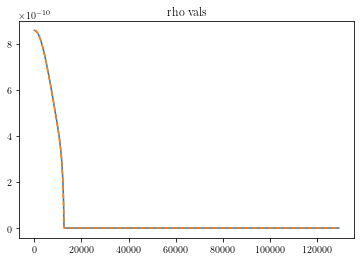

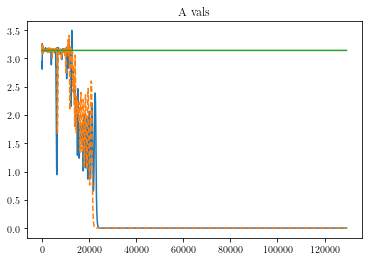

Plots for step  990 of 4000 steps


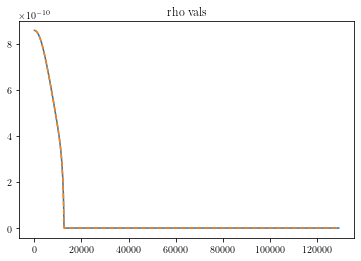

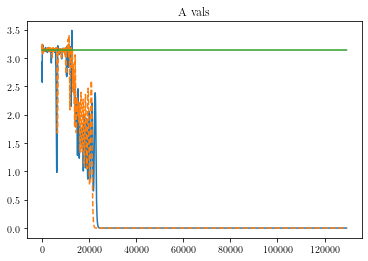

Plots for step  1000 of 4000 steps


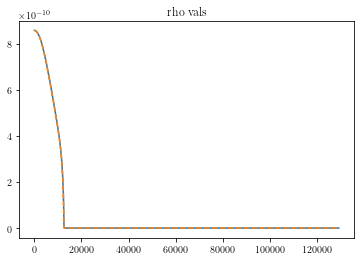

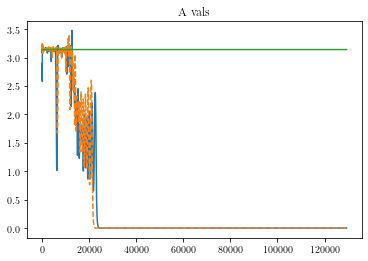

Plots for step  1010 of 4000 steps


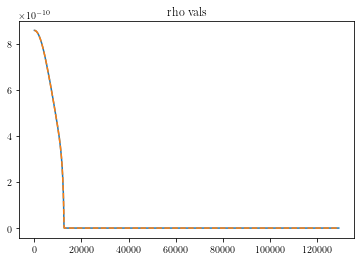

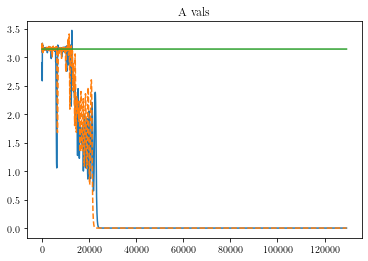

Plots for step  1020 of 4000 steps


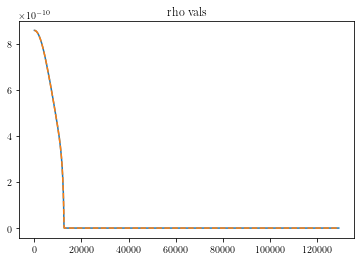

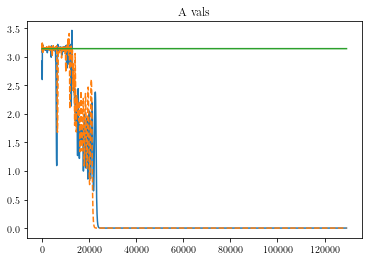

Plots for step  1030 of 4000 steps


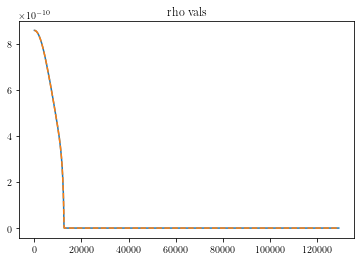

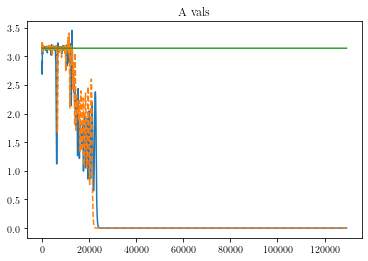

Plots for step  1040 of 4000 steps


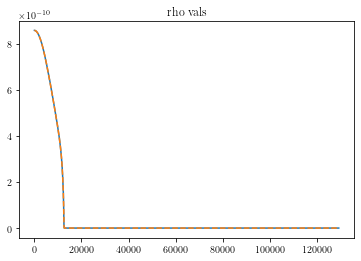

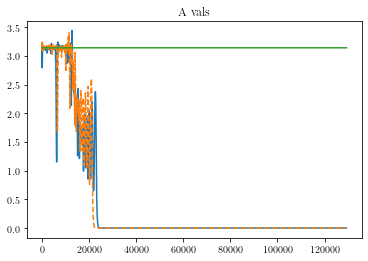

Plots for step  1050 of 4000 steps


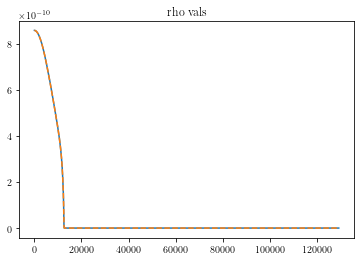

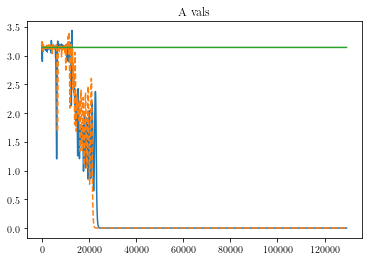

Plots for step  1060 of 4000 steps


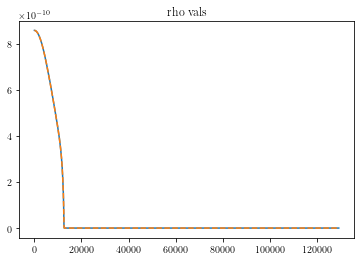

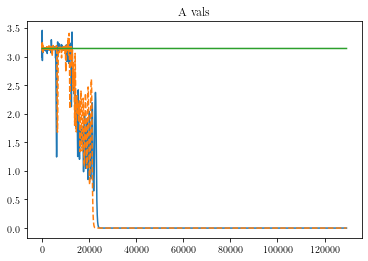

Plots for step  1070 of 4000 steps


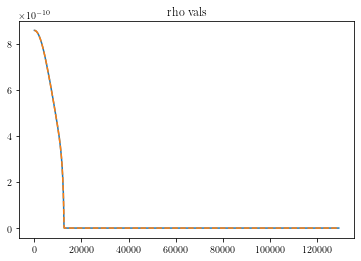

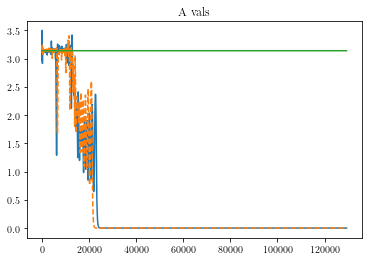

Plots for step  1080 of 4000 steps


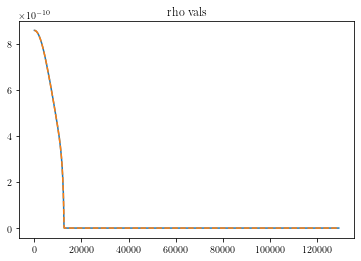

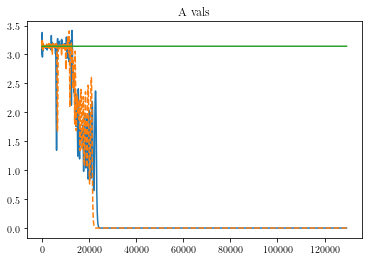

Plots for step  1090 of 4000 steps


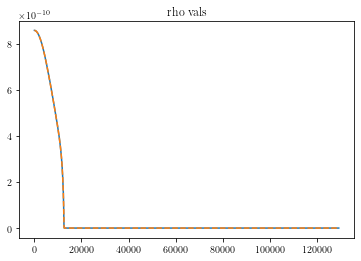

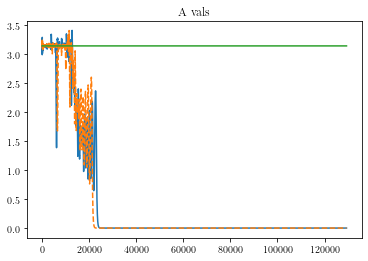

Plots for step  1100 of 4000 steps


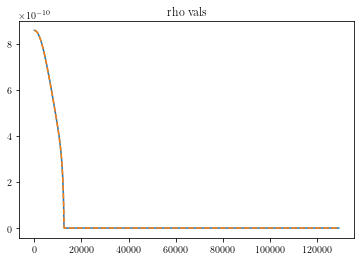

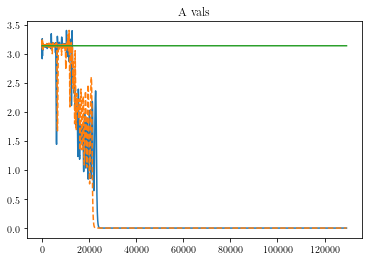

Plots for step  1110 of 4000 steps


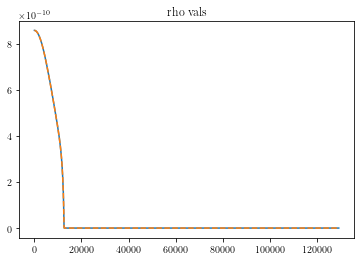

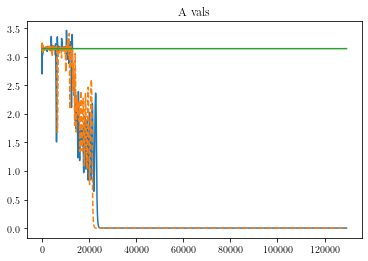

Plots for step  1120 of 4000 steps


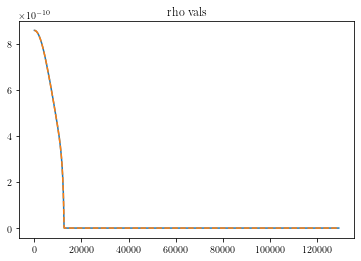

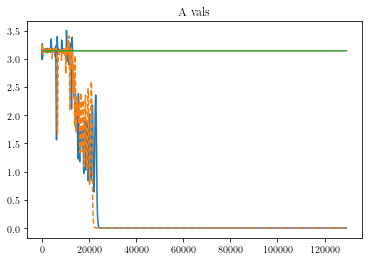

Plots for step  1130 of 4000 steps


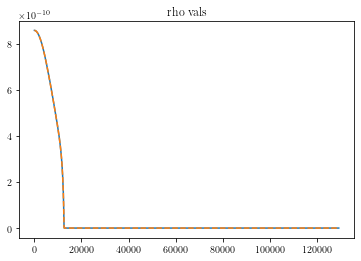

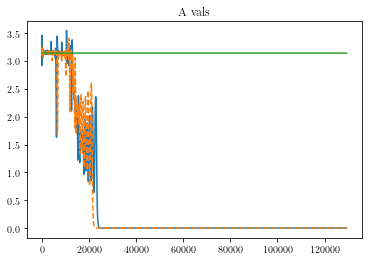

Plots for step  1140 of 4000 steps


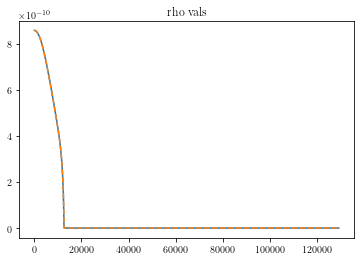

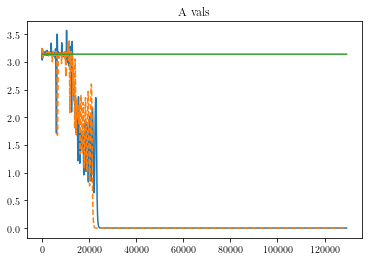

Plots for step  1150 of 4000 steps


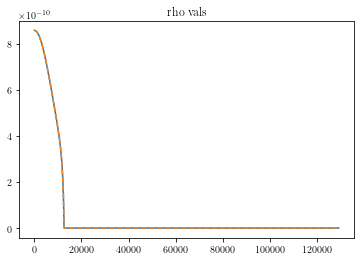

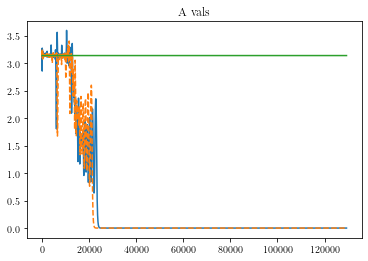

Plots for step  1160 of 4000 steps


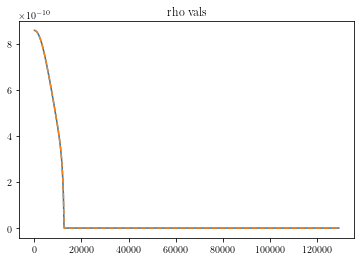

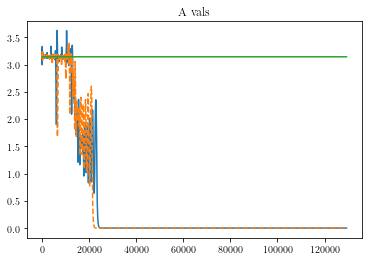

Plots for step  1170 of 4000 steps


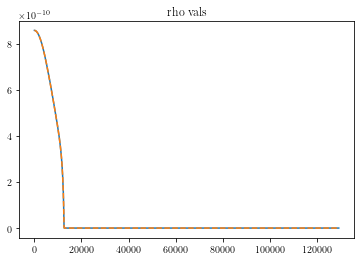

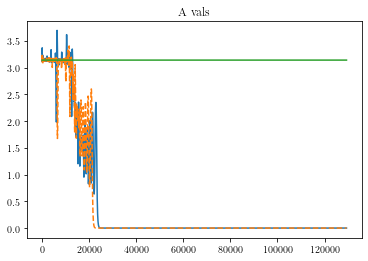

Plots for step  1180 of 4000 steps


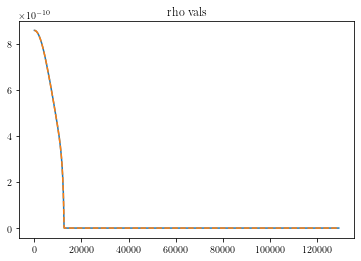

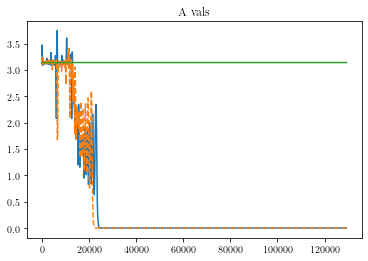

Plots for step  1190 of 4000 steps


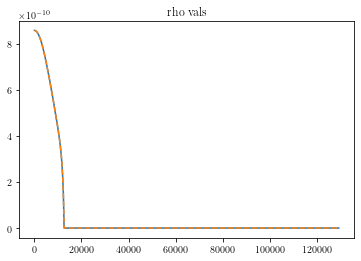

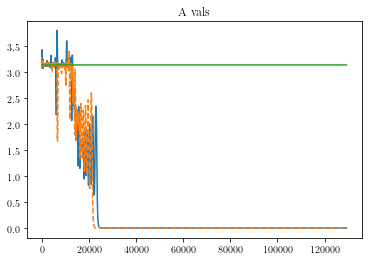

Plots for step  1200 of 4000 steps


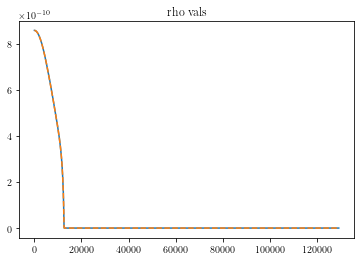

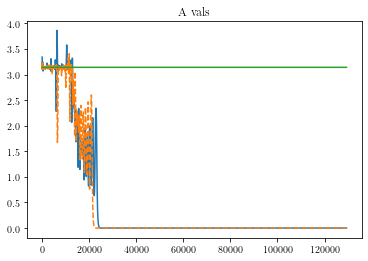

Plots for step  1210 of 4000 steps


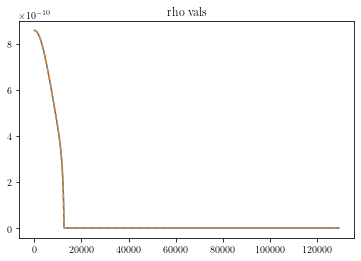

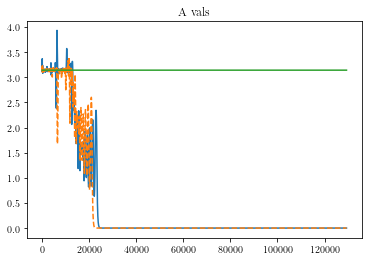

Plots for step  1220 of 4000 steps


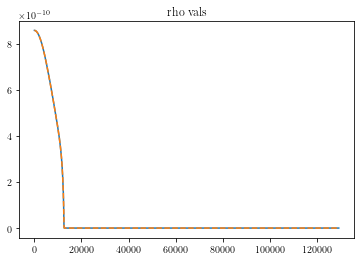

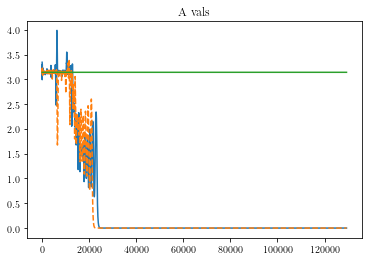

Plots for step  1230 of 4000 steps


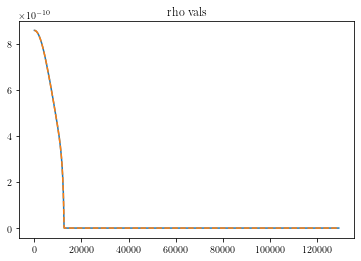

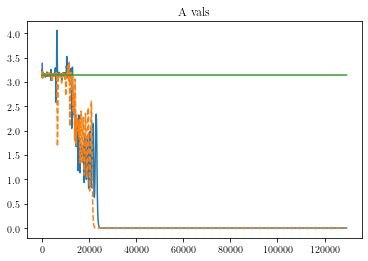

Plots for step  1240 of 4000 steps


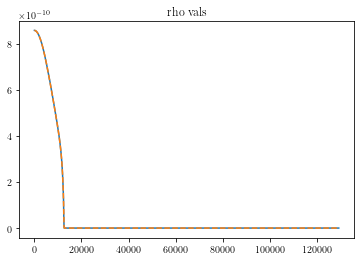

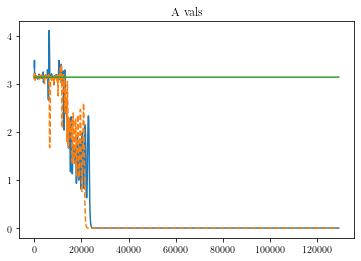

Plots for step  1250 of 4000 steps


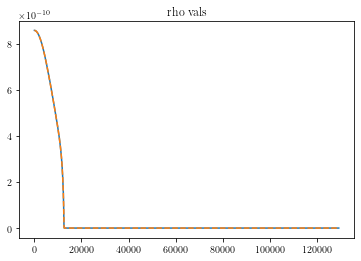

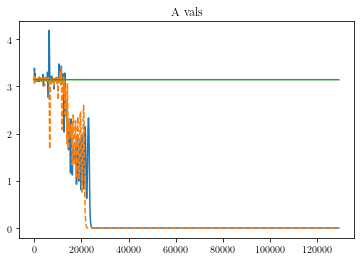

Plots for step  1260 of 4000 steps


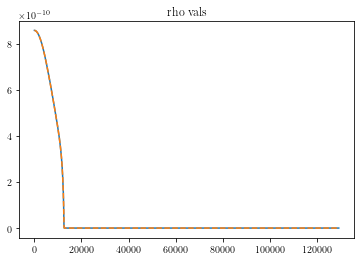

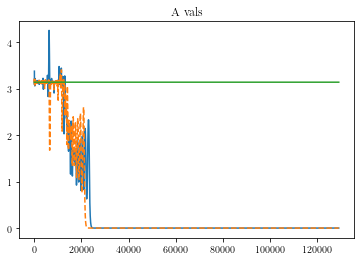

Plots for step  1270 of 4000 steps


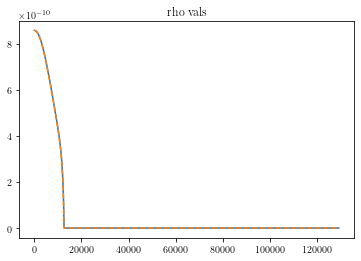

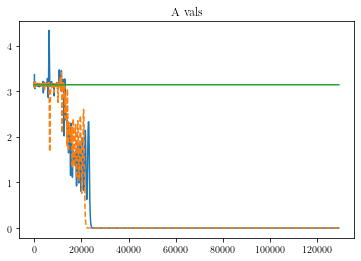

Plots for step  1280 of 4000 steps


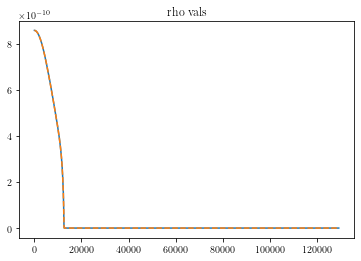

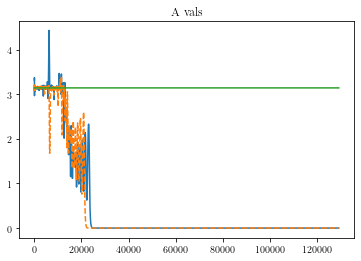

Plots for step  1290 of 4000 steps


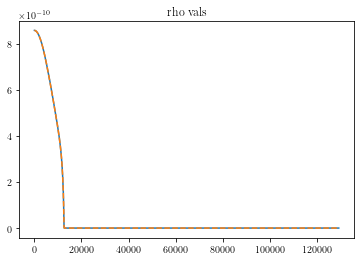

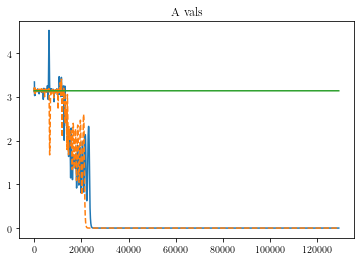

Plots for step  1300 of 4000 steps


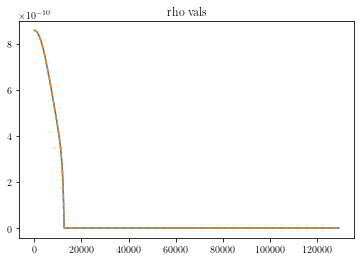

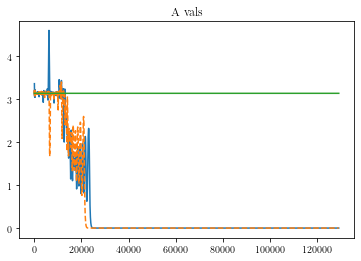

Plots for step  1310 of 4000 steps


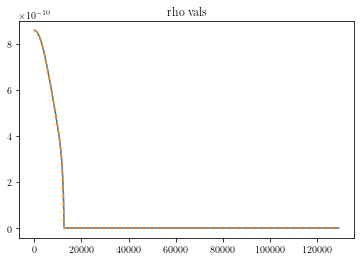

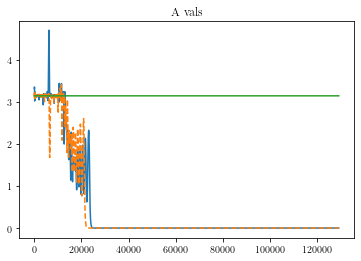

Plots for step  1320 of 4000 steps


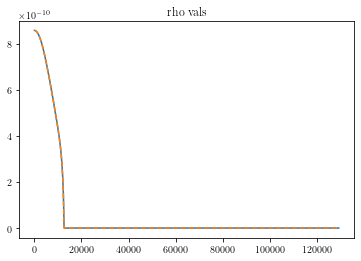

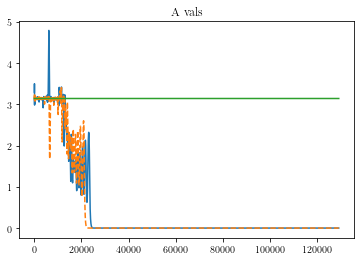

Plots for step  1330 of 4000 steps


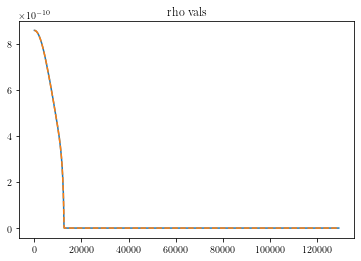

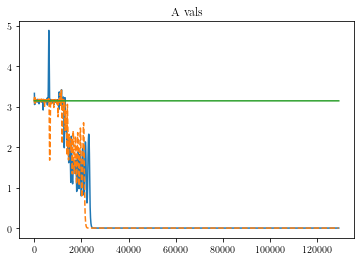

Plots for step  1340 of 4000 steps


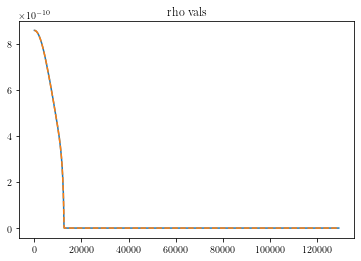

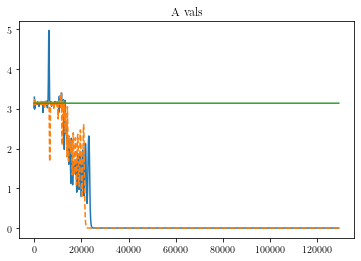

Plots for step  1350 of 4000 steps


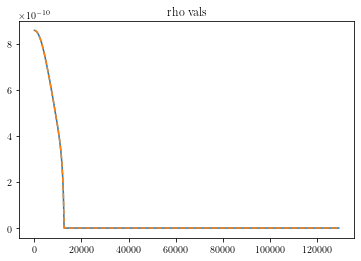

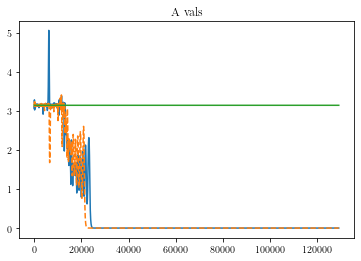

Plots for step  1360 of 4000 steps


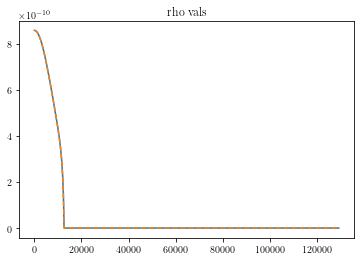

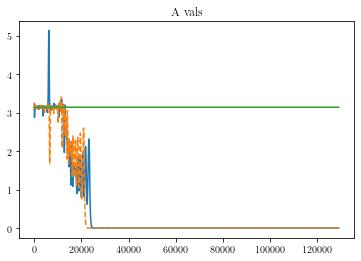

Plots for step  1370 of 4000 steps


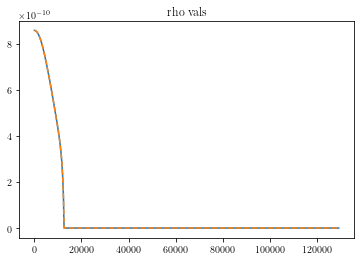

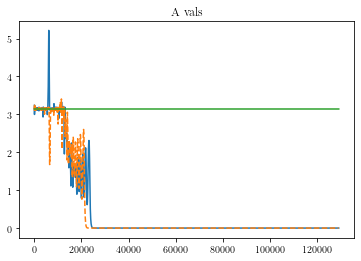

Plots for step  1380 of 4000 steps


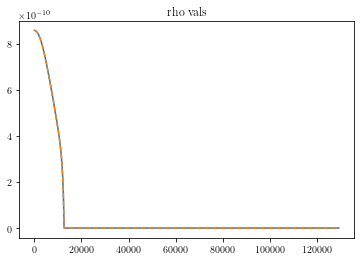

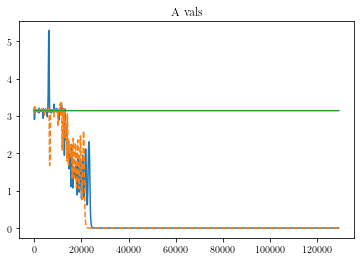

Plots for step  1390 of 4000 steps


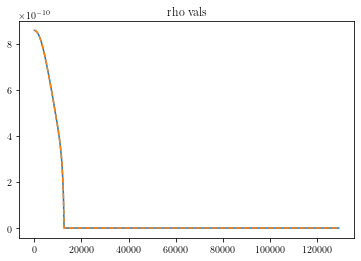

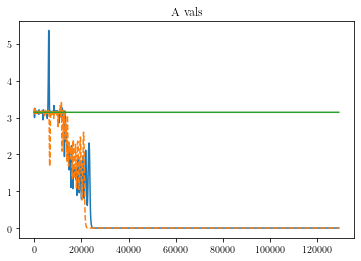

Plots for step  1400 of 4000 steps


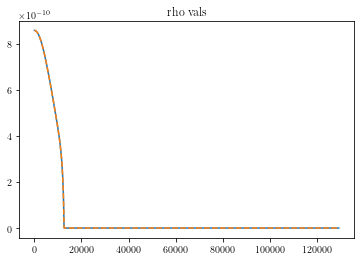

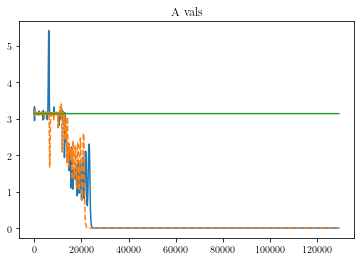

Plots for step  1410 of 4000 steps


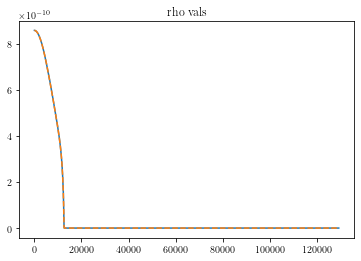

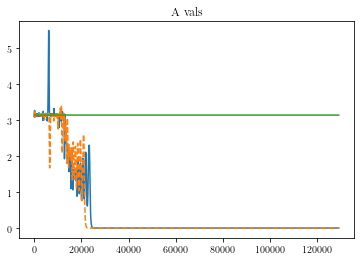

Plots for step  1420 of 4000 steps


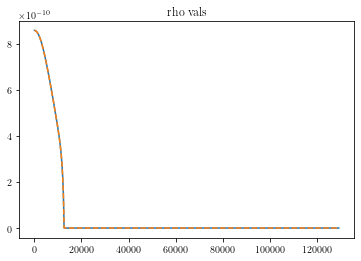

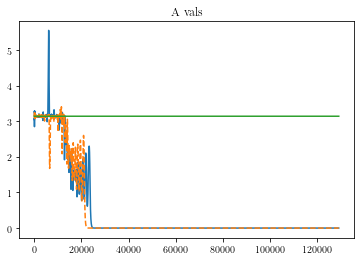

Plots for step  1430 of 4000 steps


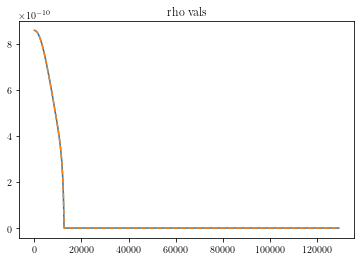

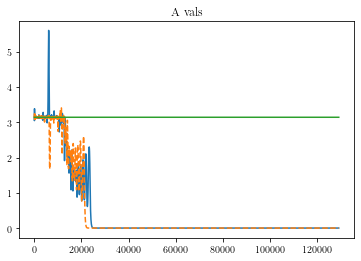

Plots for step  1440 of 4000 steps


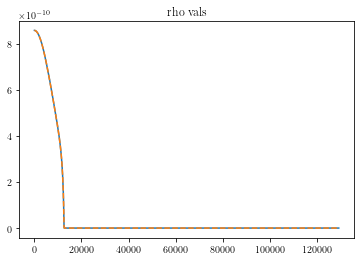

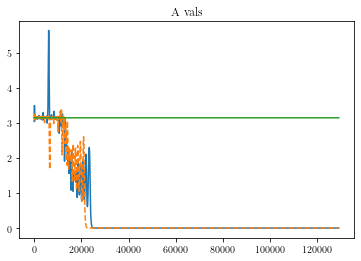

Plots for step  1450 of 4000 steps


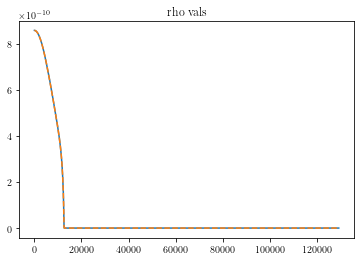

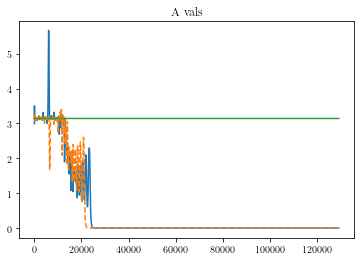

Plots for step  1460 of 4000 steps


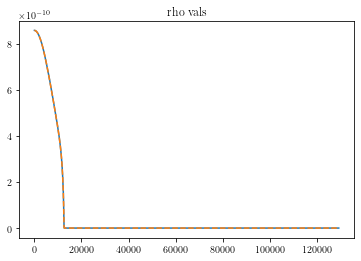

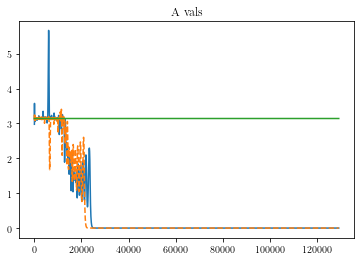

Plots for step  1470 of 4000 steps


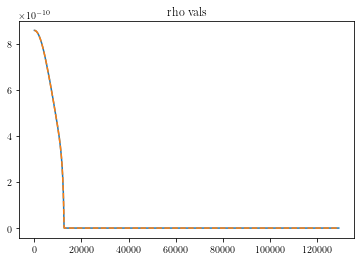

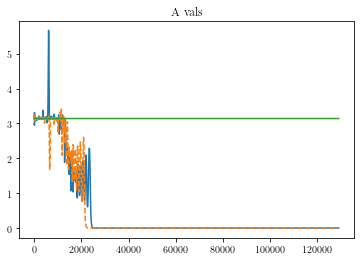

Plots for step  1480 of 4000 steps


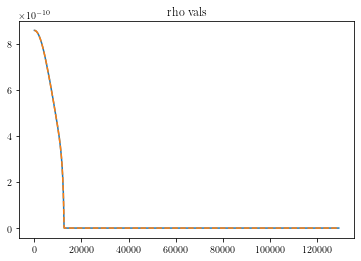

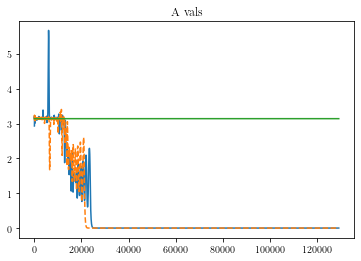

Plots for step  1490 of 4000 steps


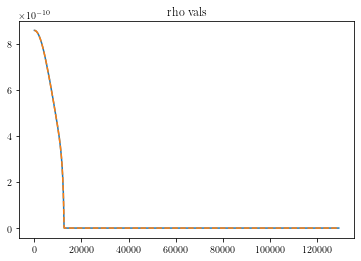

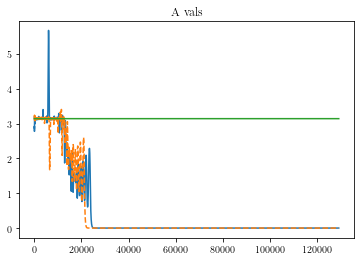

Plots for step  1500 of 4000 steps


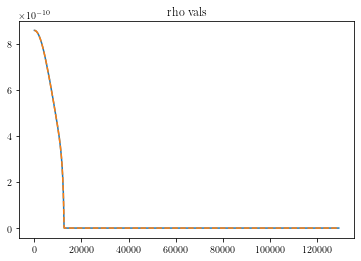

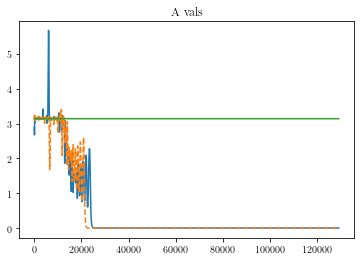

Plots for step  1510 of 4000 steps


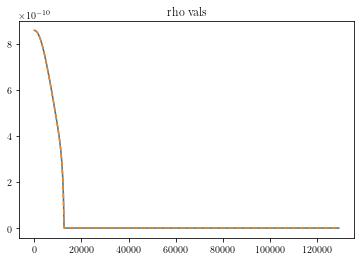

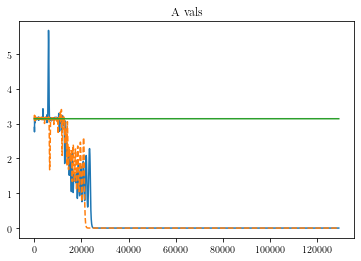

Plots for step  1520 of 4000 steps


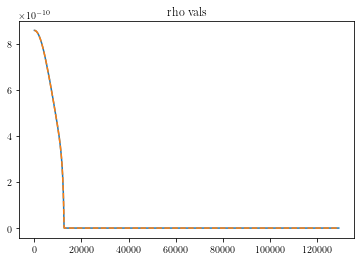

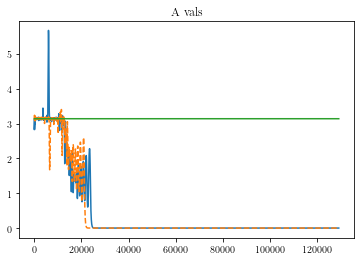

Plots for step  1530 of 4000 steps


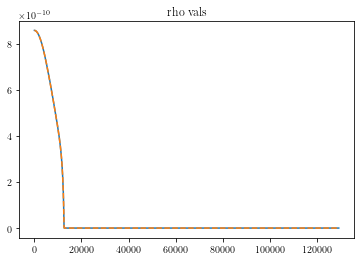

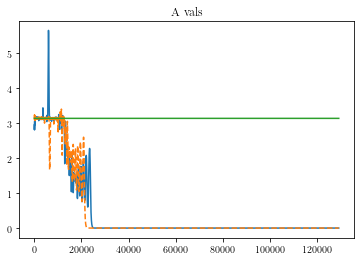

Plots for step  1540 of 4000 steps


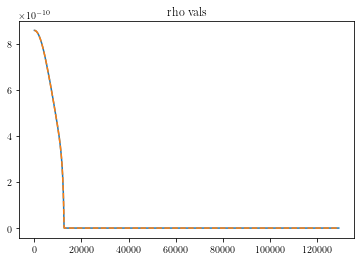

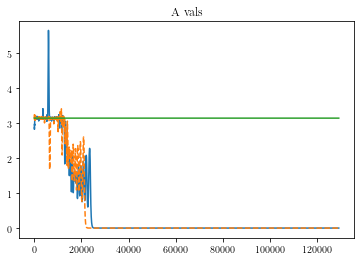

Plots for step  1550 of 4000 steps


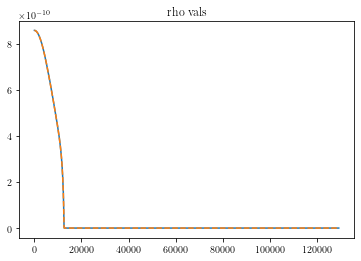

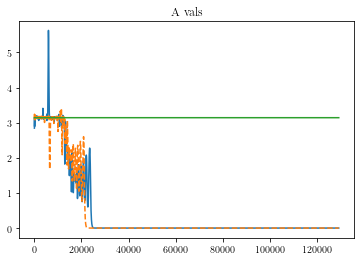

Plots for step  1560 of 4000 steps


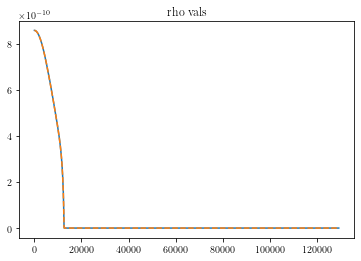

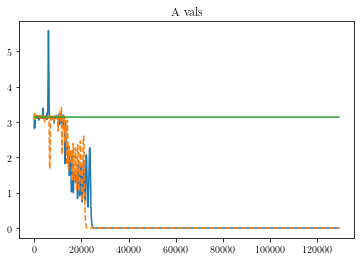

Plots for step  1570 of 4000 steps


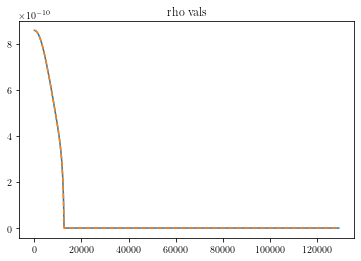

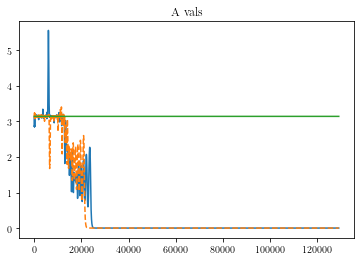

Plots for step  1580 of 4000 steps


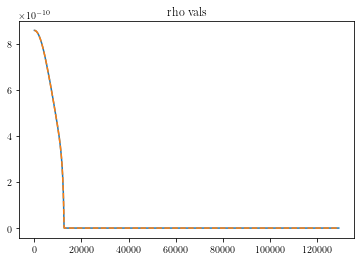

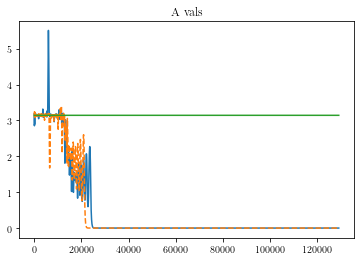

Plots for step  1590 of 4000 steps


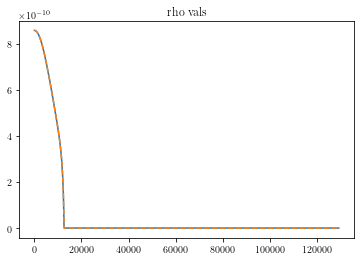

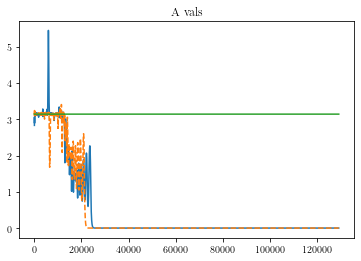

Plots for step  1600 of 4000 steps


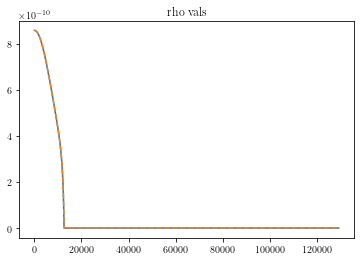

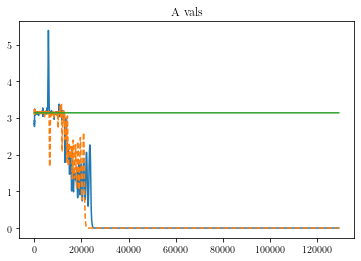

Plots for step  1610 of 4000 steps


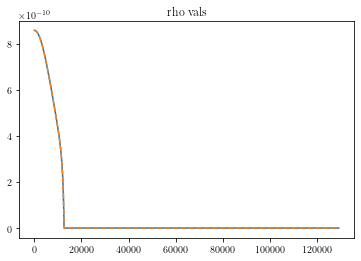

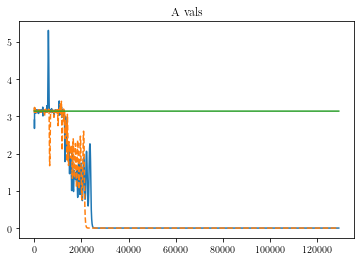

Plots for step  1620 of 4000 steps


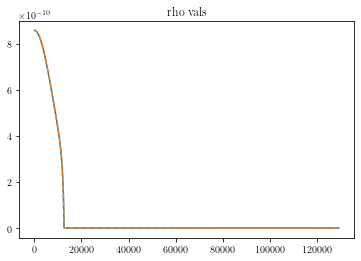

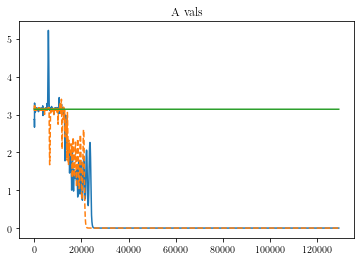

Plots for step  1630 of 4000 steps


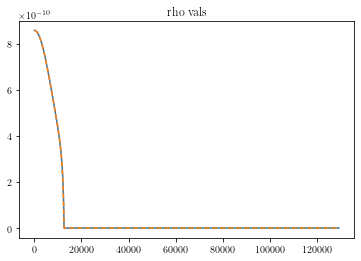

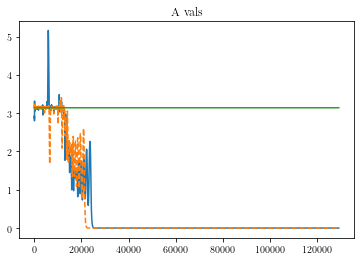

Plots for step  1640 of 4000 steps


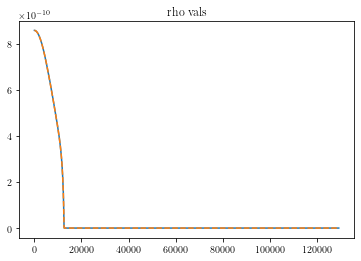

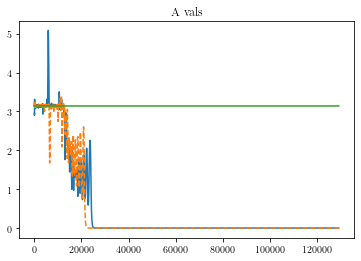

Plots for step  1650 of 4000 steps


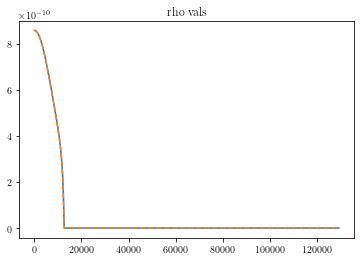

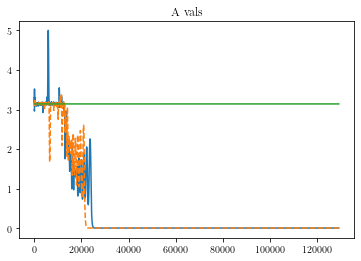

Plots for step  1660 of 4000 steps


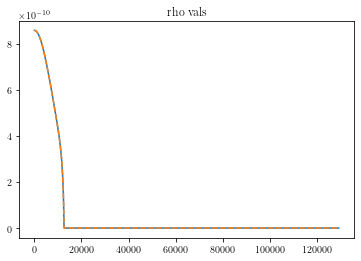

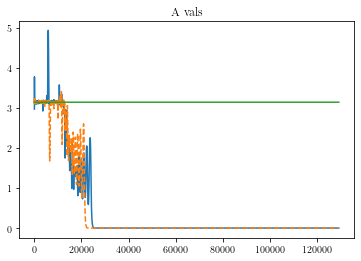

Plots for step  1670 of 4000 steps


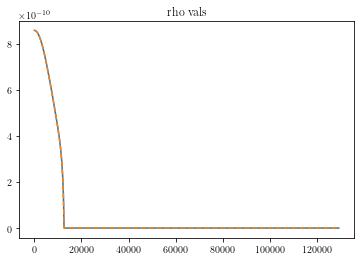

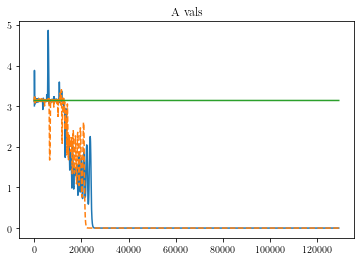

Plots for step  1680 of 4000 steps


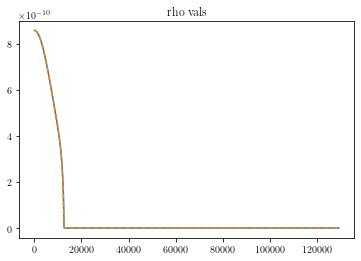

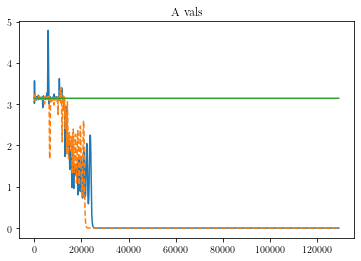

Plots for step  1690 of 4000 steps


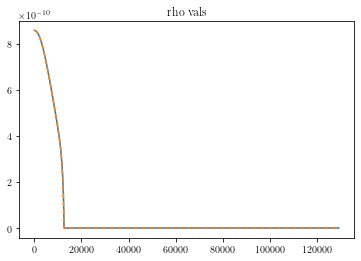

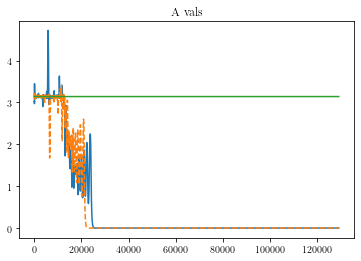

Plots for step  1700 of 4000 steps


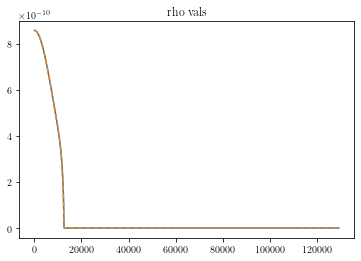

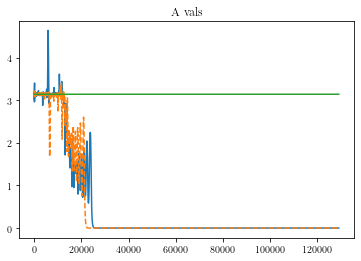

Plots for step  1710 of 4000 steps


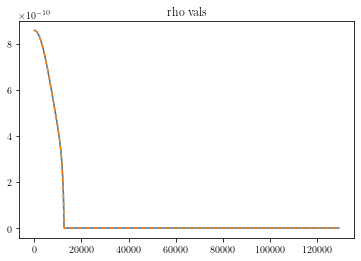

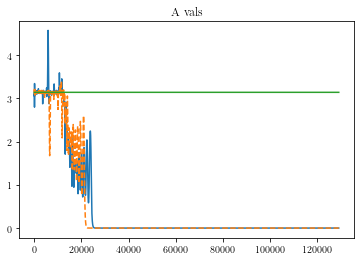

Plots for step  1720 of 4000 steps


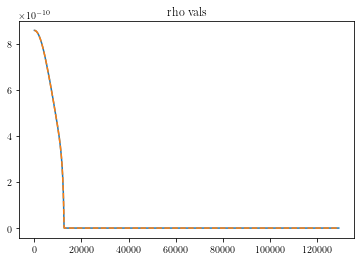

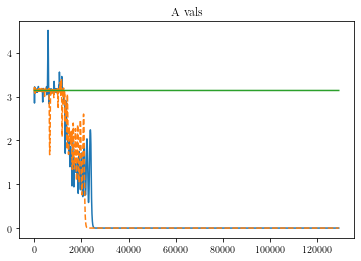

Plots for step  1730 of 4000 steps


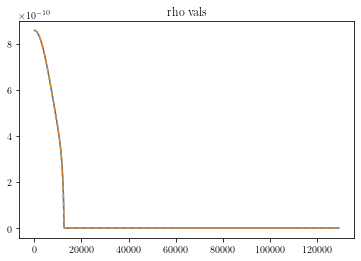

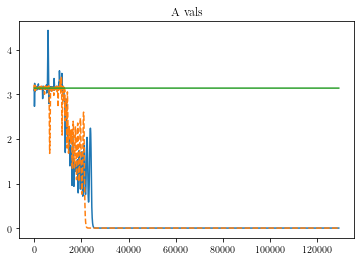

Plots for step  1740 of 4000 steps


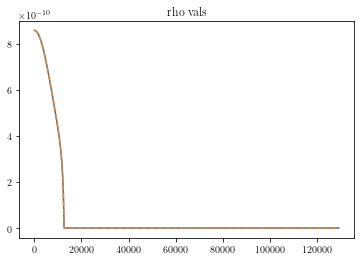

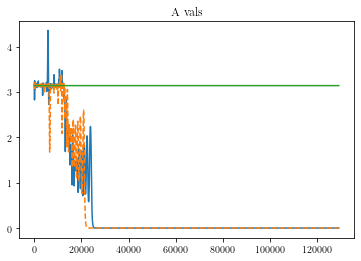

Plots for step  1750 of 4000 steps


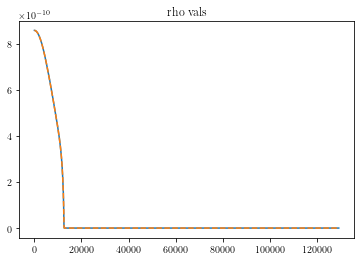

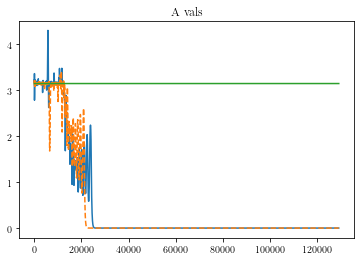

Plots for step  1760 of 4000 steps


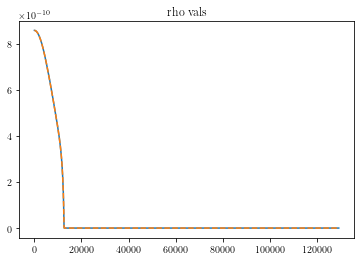

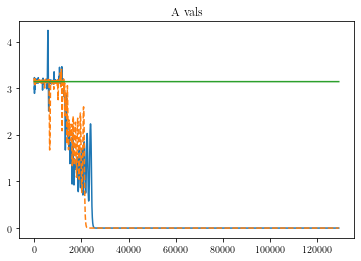

Plots for step  1770 of 4000 steps


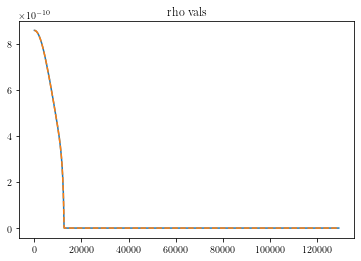

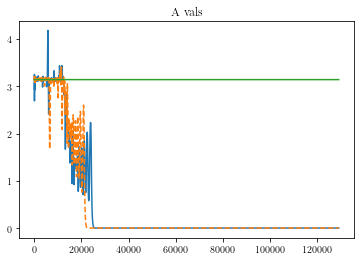

Plots for step  1780 of 4000 steps


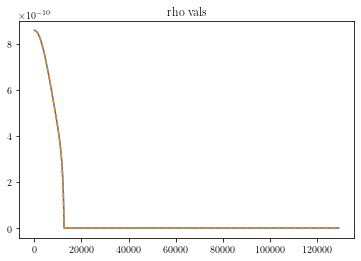

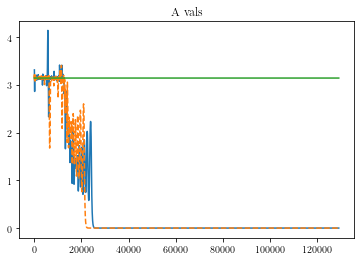

Plots for step  1790 of 4000 steps


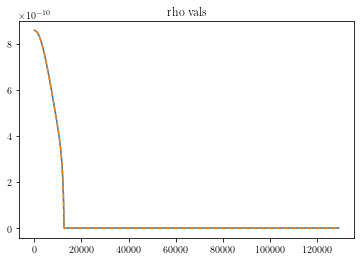

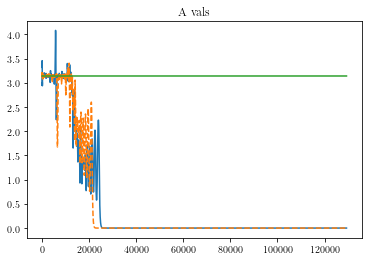

Plots for step  1800 of 4000 steps


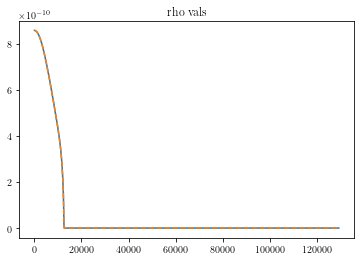

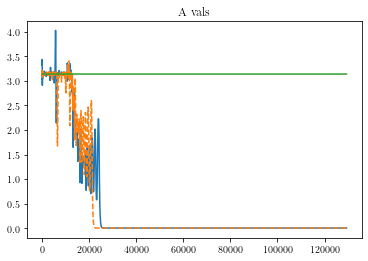

Plots for step  1810 of 4000 steps


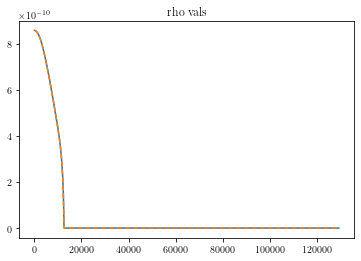

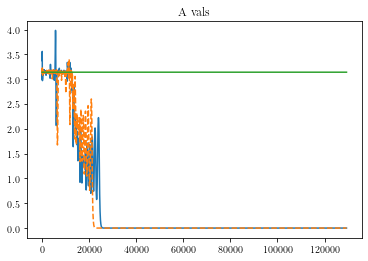

Plots for step  1820 of 4000 steps


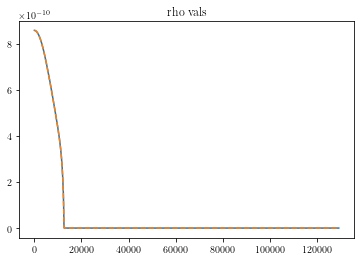

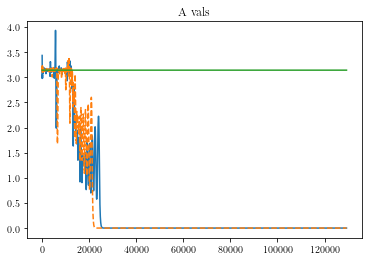

Plots for step  1830 of 4000 steps


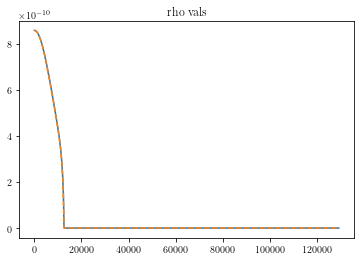

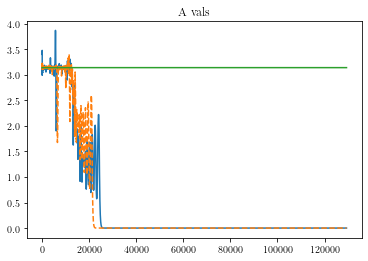

Plots for step  1840 of 4000 steps


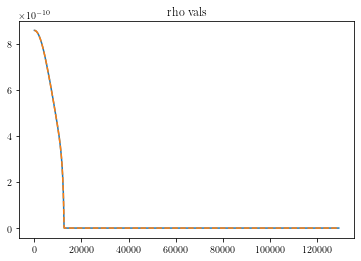

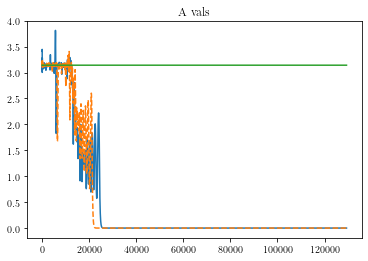

Plots for step  1850 of 4000 steps


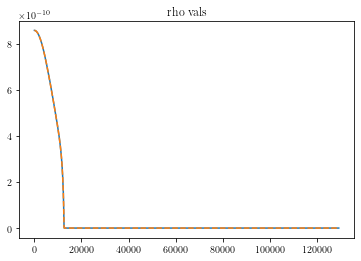

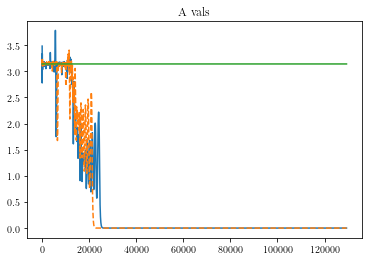

Plots for step  1860 of 4000 steps


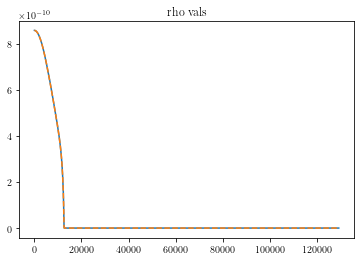

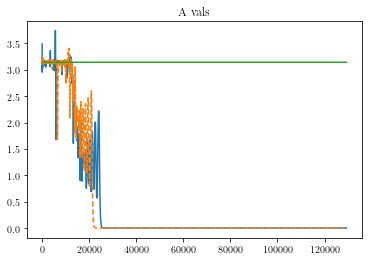

Plots for step  1870 of 4000 steps


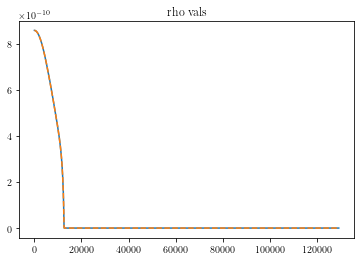

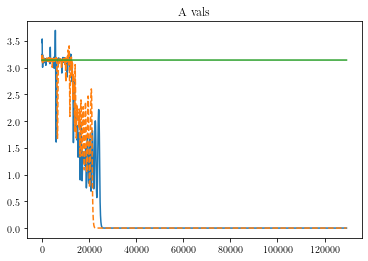

Plots for step  1880 of 4000 steps


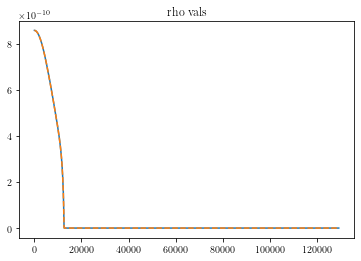

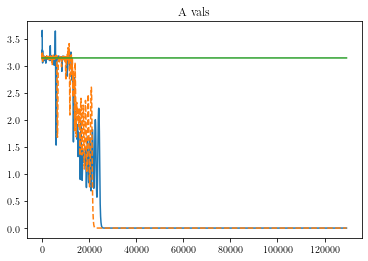

Plots for step  1890 of 4000 steps


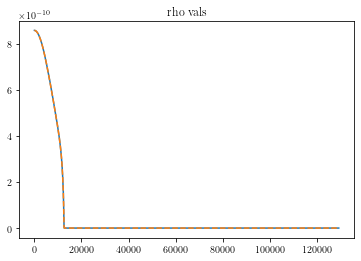

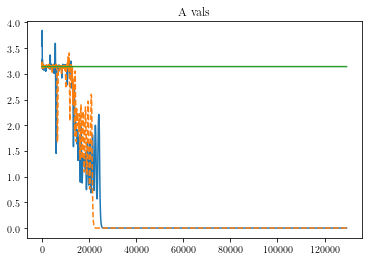

Plots for step  1900 of 4000 steps


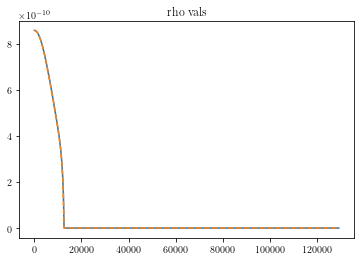

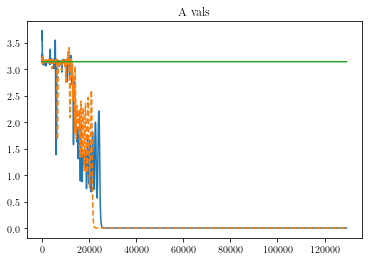

Plots for step  1910 of 4000 steps


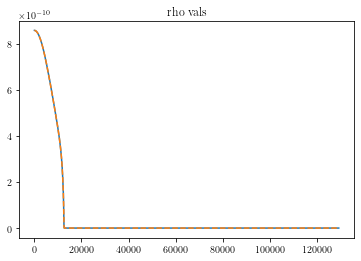

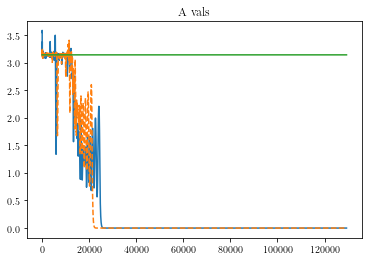

Plots for step  1920 of 4000 steps


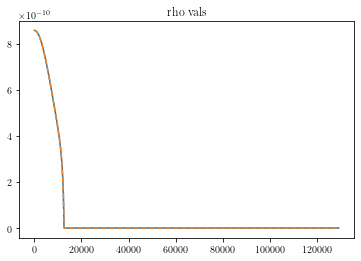

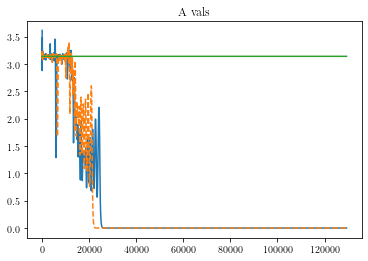

Plots for step  1930 of 4000 steps


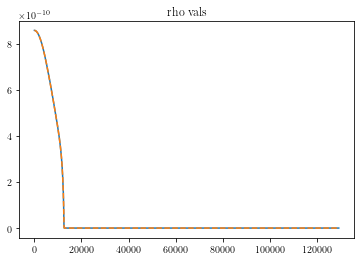

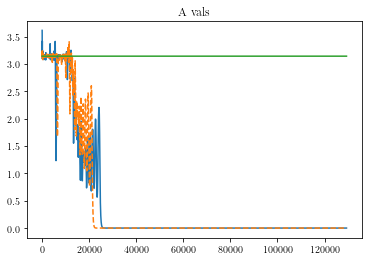

Plots for step  1940 of 4000 steps


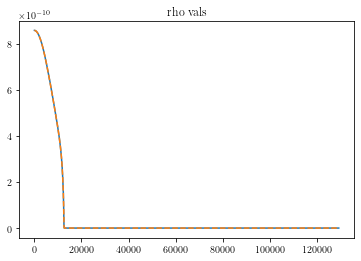

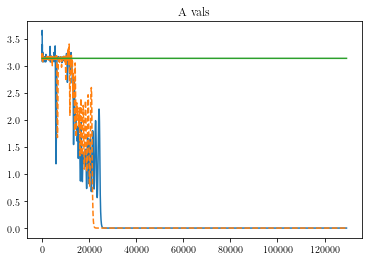

Plots for step  1950 of 4000 steps


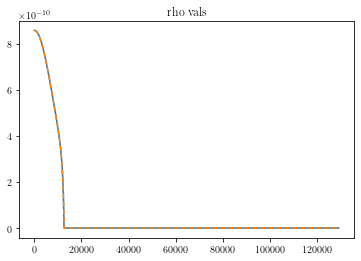

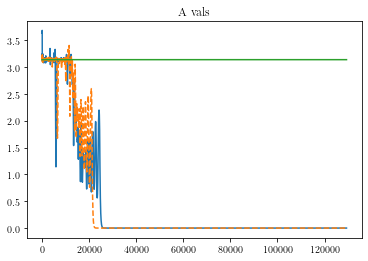

Plots for step  1960 of 4000 steps


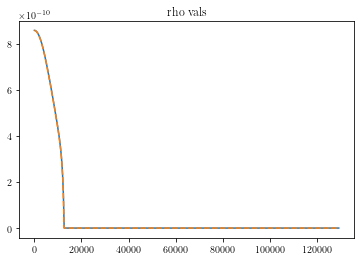

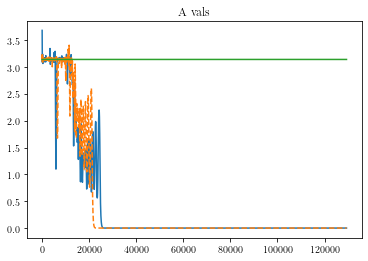

Plots for step  1970 of 4000 steps


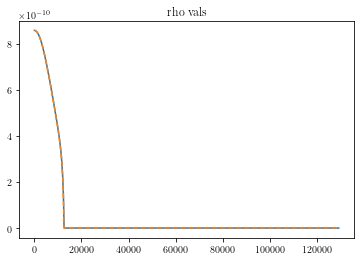

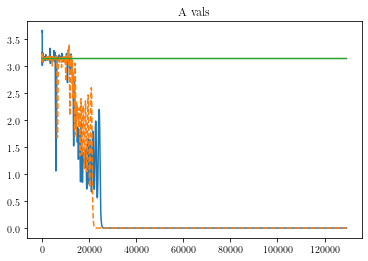

Plots for step  1980 of 4000 steps


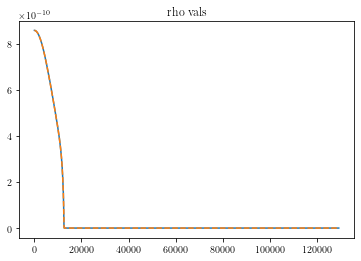

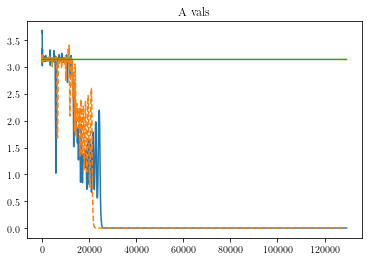

Plots for step  1990 of 4000 steps


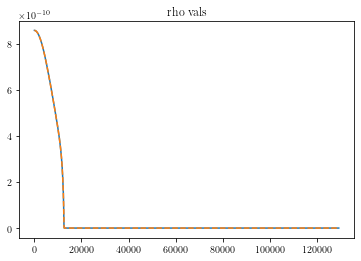

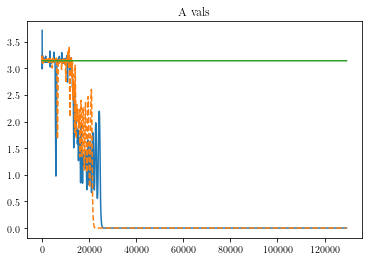

Plots for step  2000 of 4000 steps


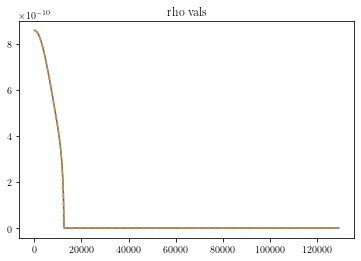

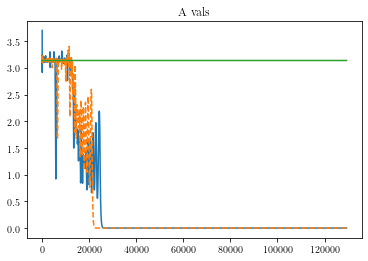

Plots for step  2010 of 4000 steps


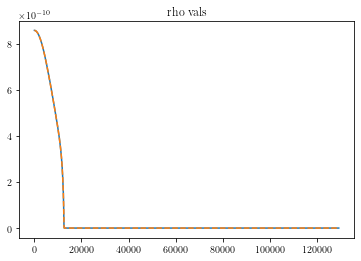

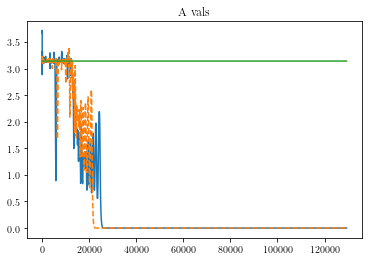

Plots for step  2020 of 4000 steps


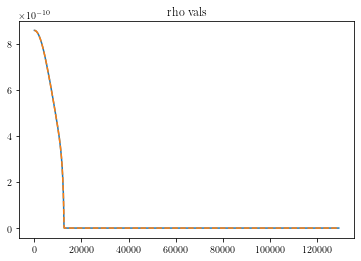

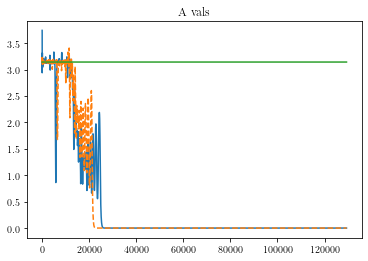

Plots for step  2030 of 4000 steps


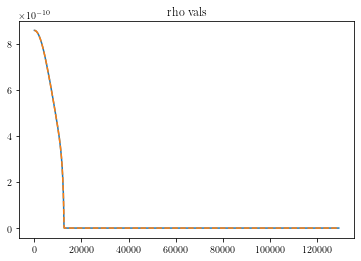

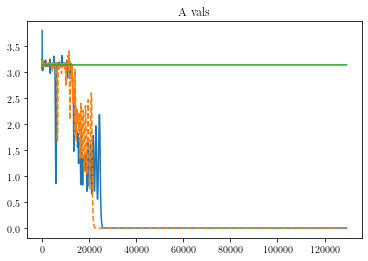

Plots for step  2040 of 4000 steps


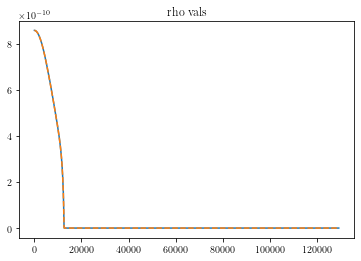

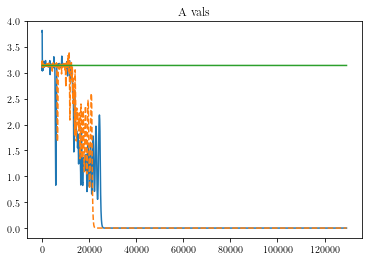

Plots for step  2050 of 4000 steps


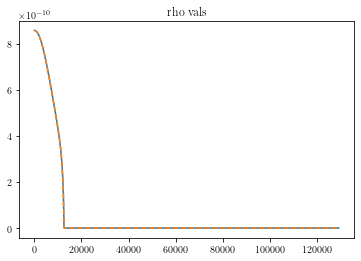

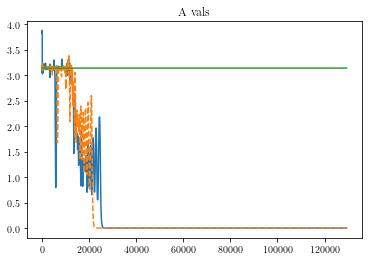

Plots for step  2060 of 4000 steps


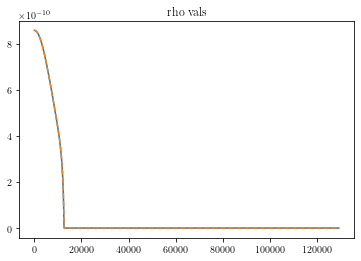

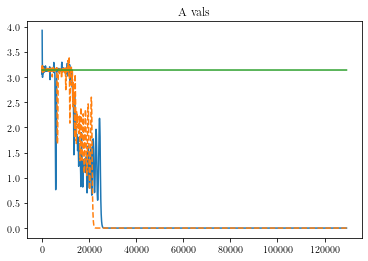

Plots for step  2070 of 4000 steps


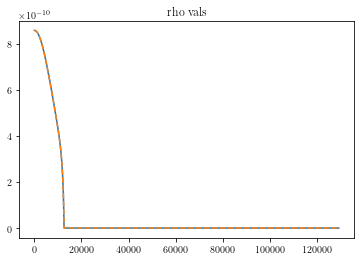

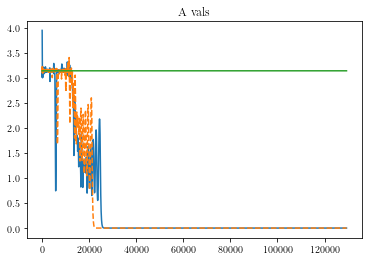

Plots for step  2080 of 4000 steps


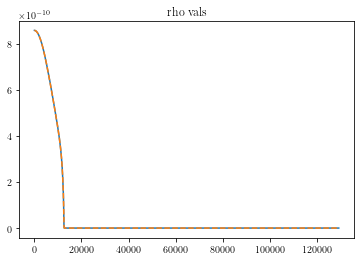

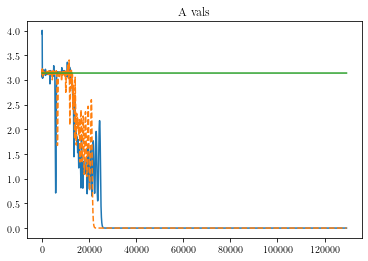

Plots for step  2090 of 4000 steps


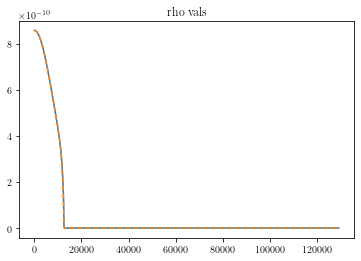

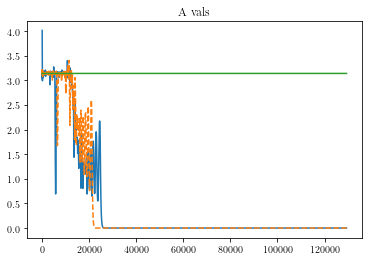

Plots for step  2100 of 4000 steps


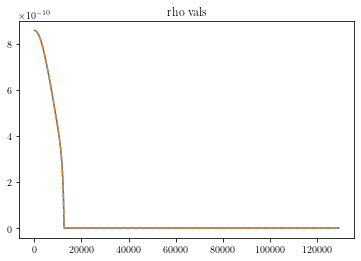

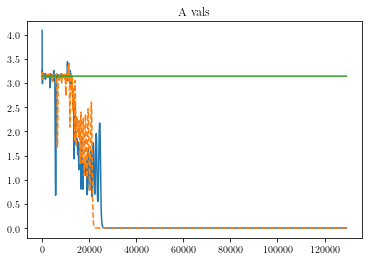

Plots for step  2110 of 4000 steps


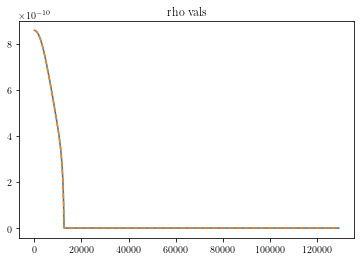

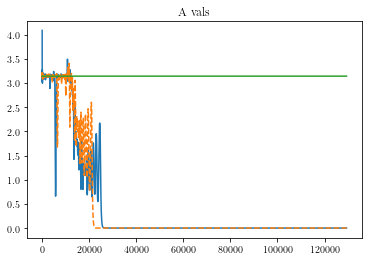

Plots for step  2120 of 4000 steps


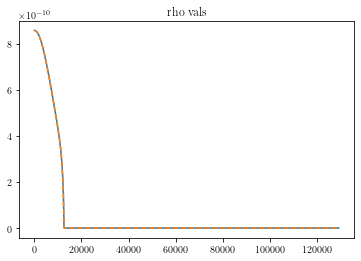

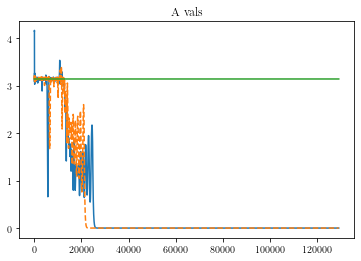

Plots for step  2130 of 4000 steps


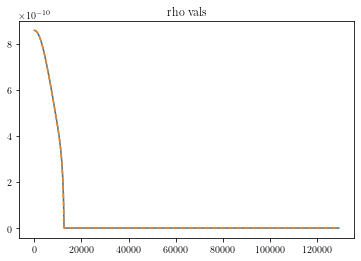

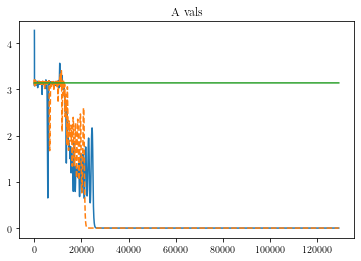

Plots for step  2140 of 4000 steps


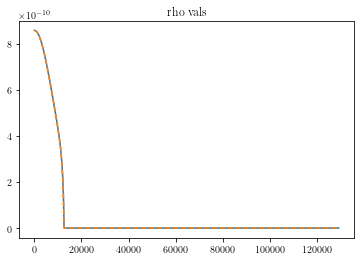

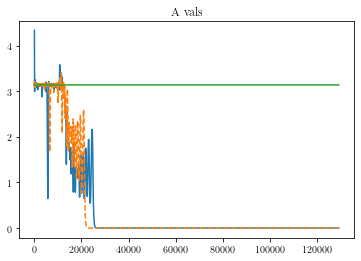

Plots for step  2150 of 4000 steps


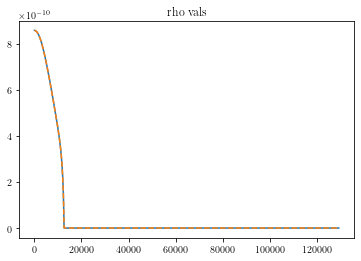

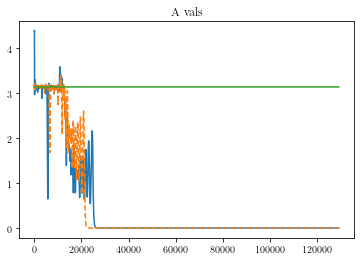

Plots for step  2160 of 4000 steps


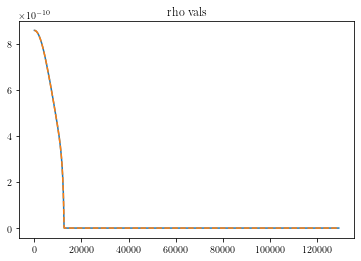

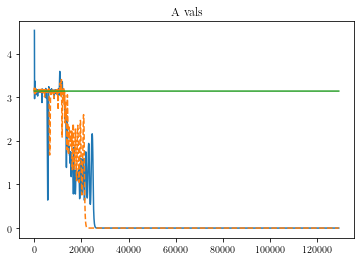

Plots for step  2170 of 4000 steps


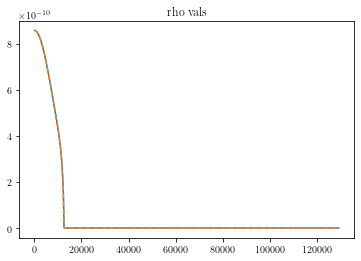

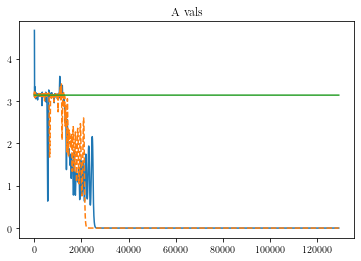

Plots for step  2180 of 4000 steps


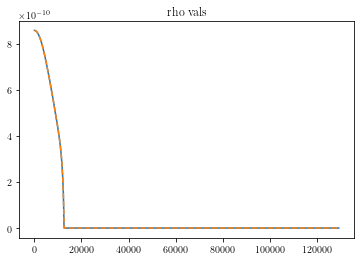

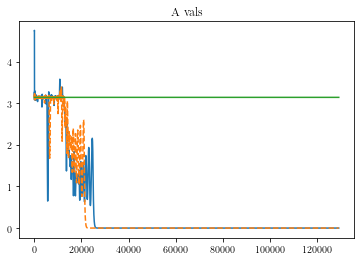

Plots for step  2190 of 4000 steps


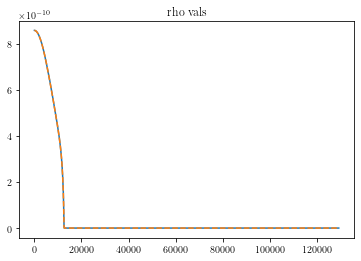

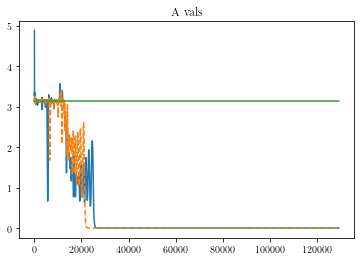

Plots for step  2200 of 4000 steps


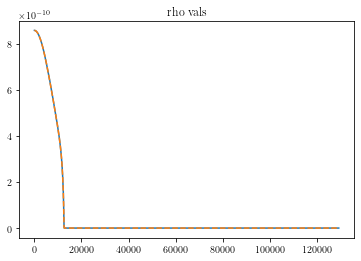

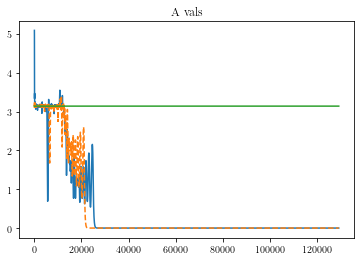

Plots for step  2210 of 4000 steps


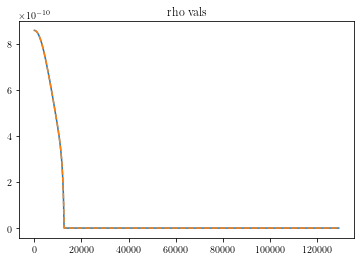

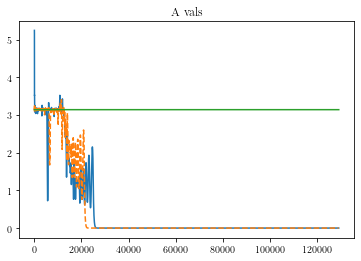

Plots for step  2220 of 4000 steps


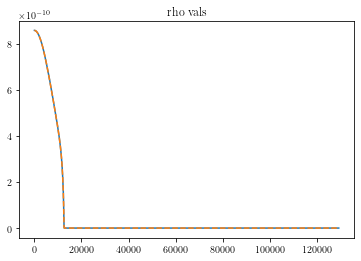

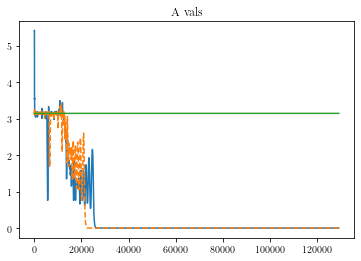

Plots for step  2230 of 4000 steps


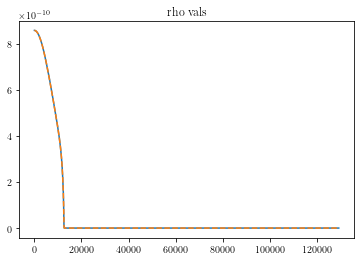

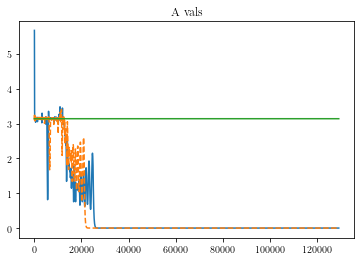

Plots for step  2240 of 4000 steps


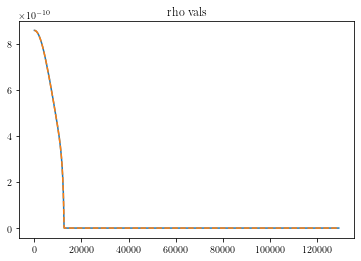

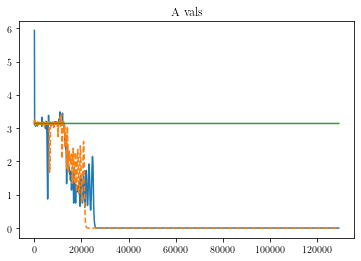

Plots for step  2250 of 4000 steps


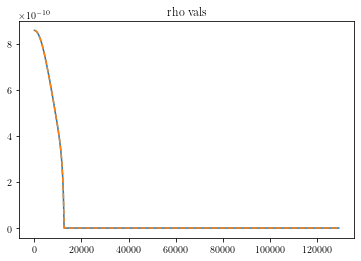

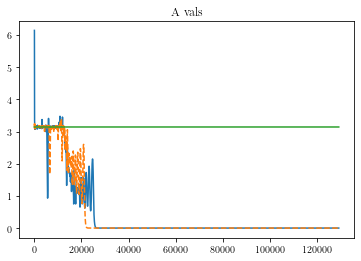

Plots for step  2260 of 4000 steps


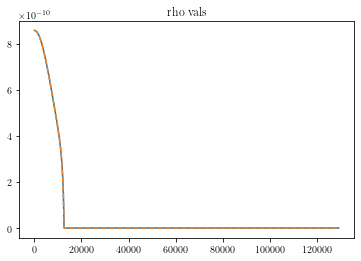

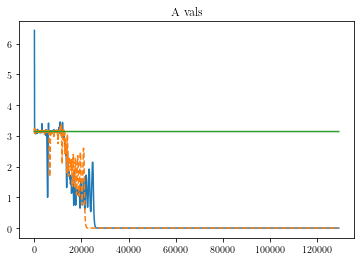

Plots for step  2270 of 4000 steps


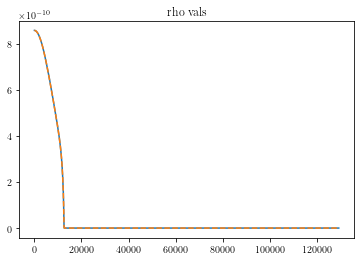

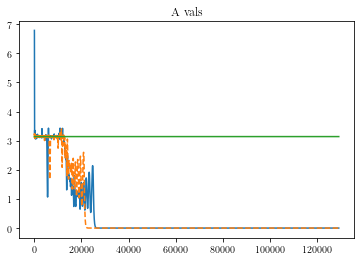

Plots for step  2280 of 4000 steps


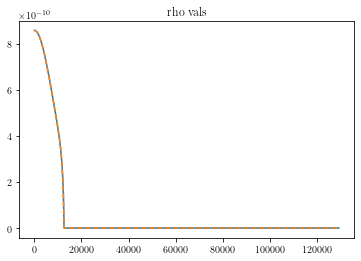

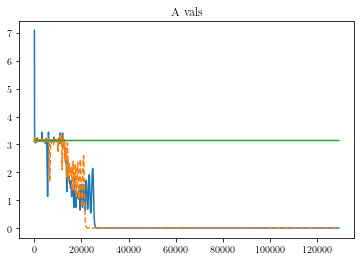

Plots for step  2290 of 4000 steps


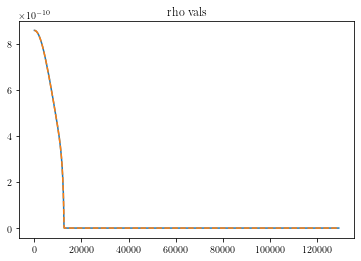

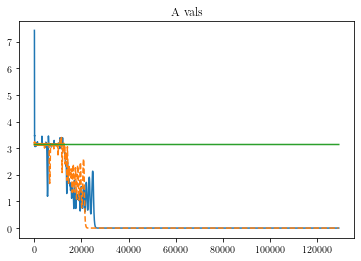

Plots for step  2300 of 4000 steps


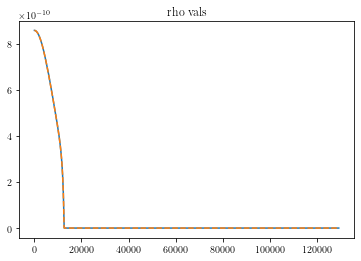

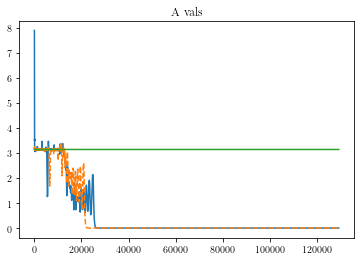

Plots for step  2310 of 4000 steps


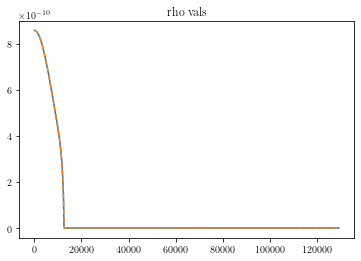

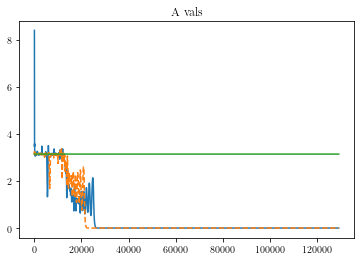

Plots for step  2320 of 4000 steps


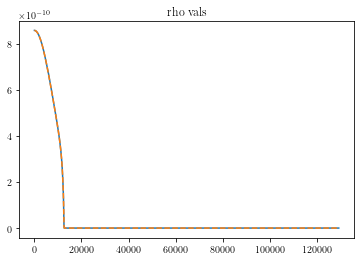

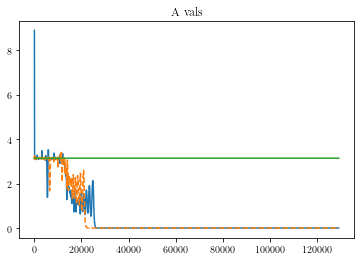

Plots for step  2330 of 4000 steps


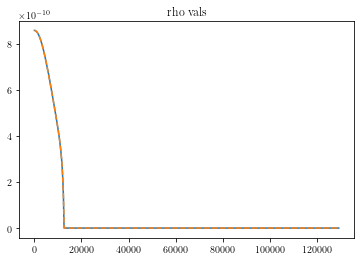

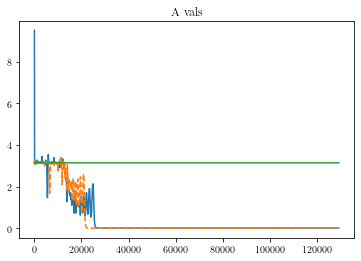

Plots for step  2340 of 4000 steps


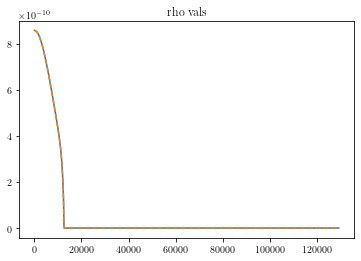

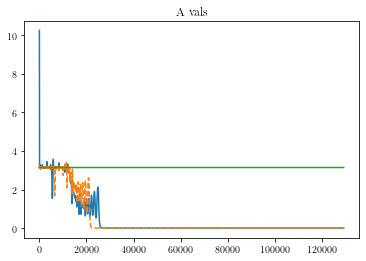

Plots for step  2350 of 4000 steps


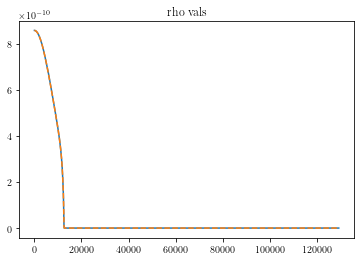

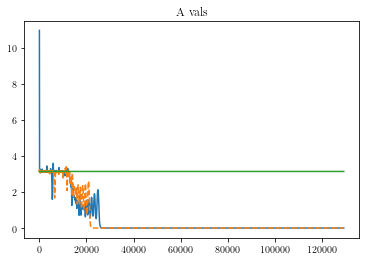

Plots for step  2360 of 4000 steps


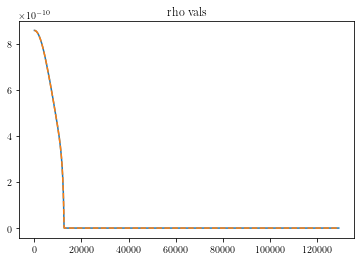

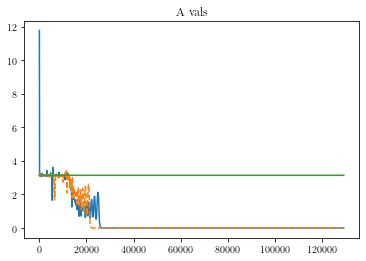

Plots for step  2370 of 4000 steps


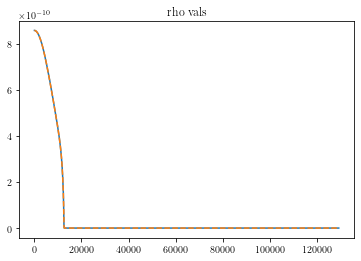

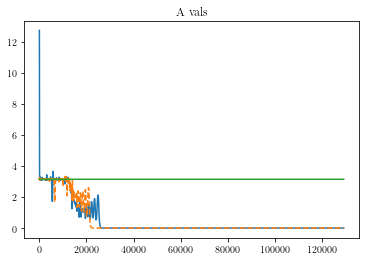

Plots for step  2380 of 4000 steps


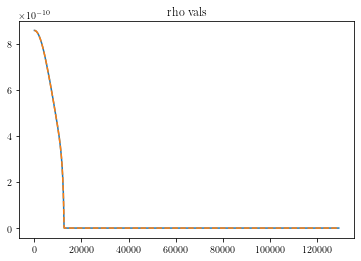

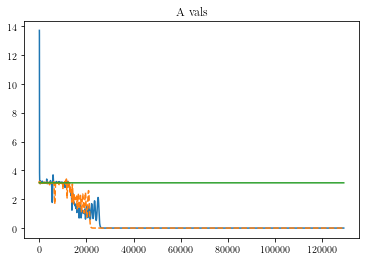

Plots for step  2390 of 4000 steps


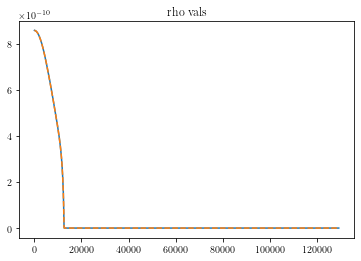

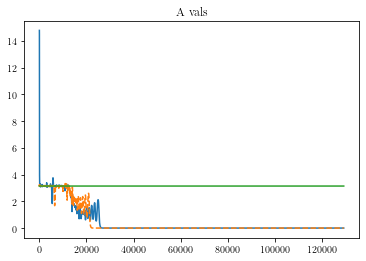

Plots for step  2400 of 4000 steps


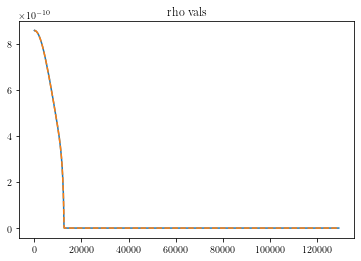

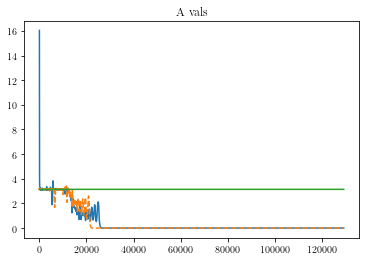

Plots for step  2410 of 4000 steps


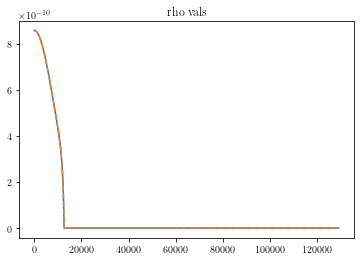

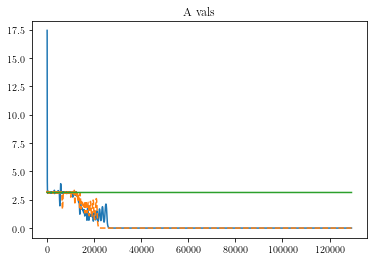

Plots for step  2420 of 4000 steps


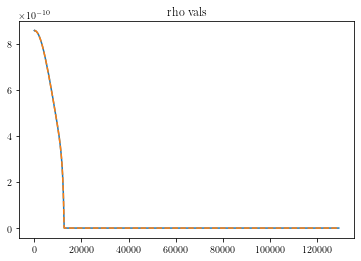

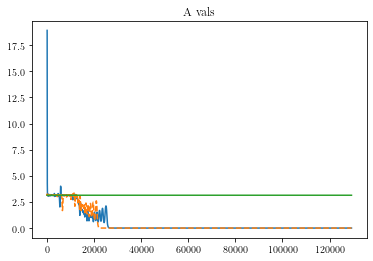

Plots for step  2430 of 4000 steps


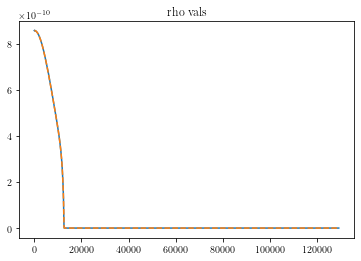

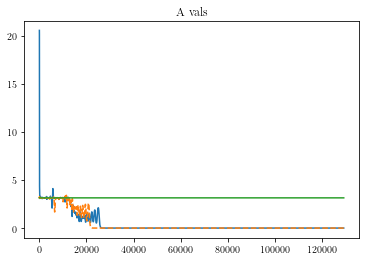

Plots for step  2440 of 4000 steps


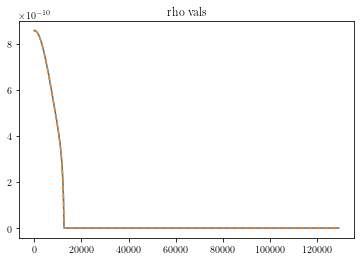

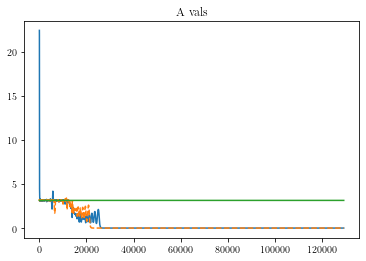

Plots for step  2450 of 4000 steps


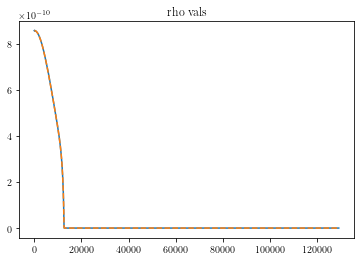

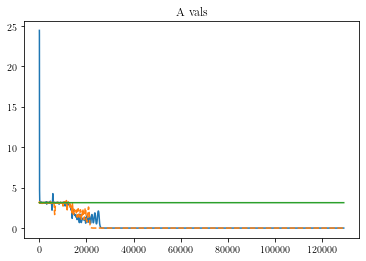

Plots for step  2460 of 4000 steps


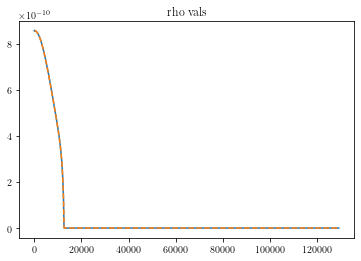

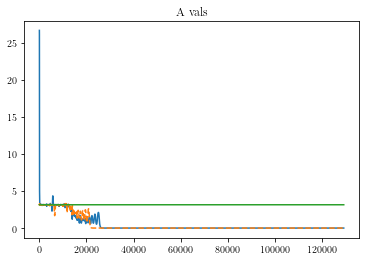

Plots for step  2470 of 4000 steps


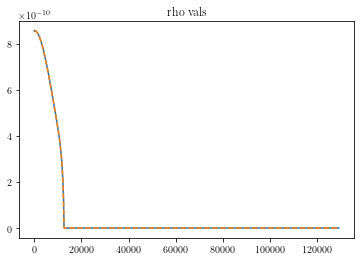

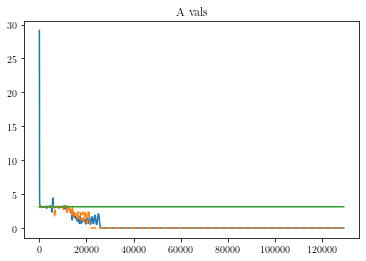

Plots for step  2480 of 4000 steps


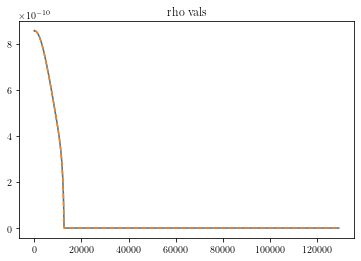

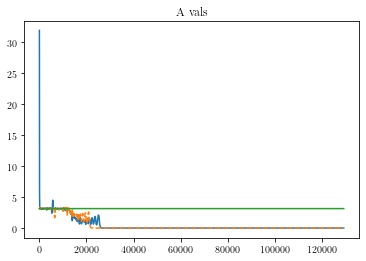

Plots for step  2490 of 4000 steps


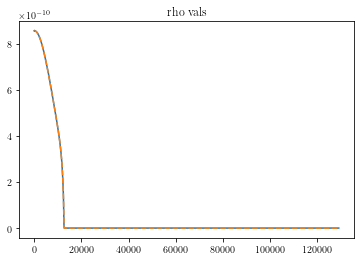

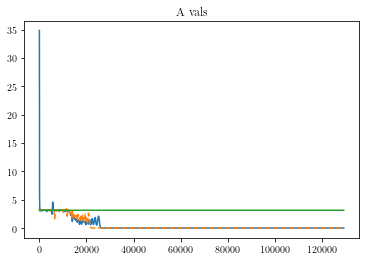

Plots for step  2500 of 4000 steps


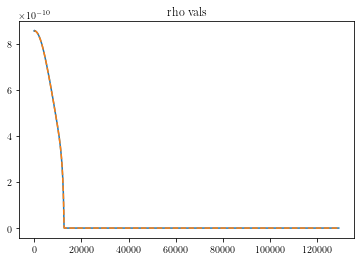

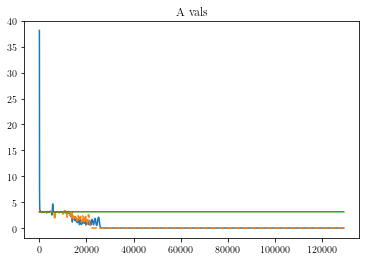

Plots for step  2510 of 4000 steps


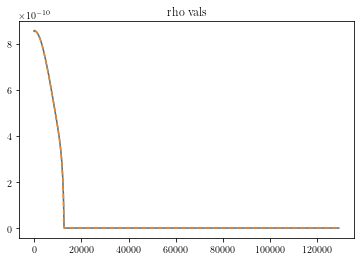

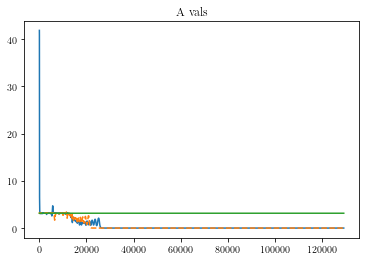

Plots for step  2520 of 4000 steps


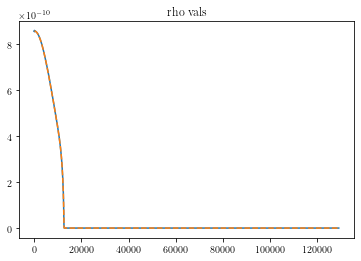

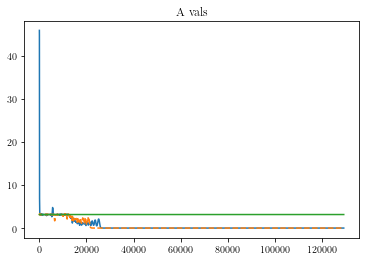

Plots for step  2530 of 4000 steps


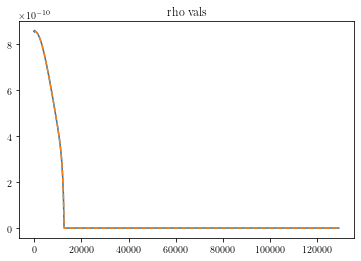

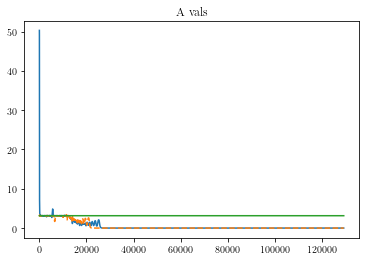

Plots for step  2540 of 4000 steps


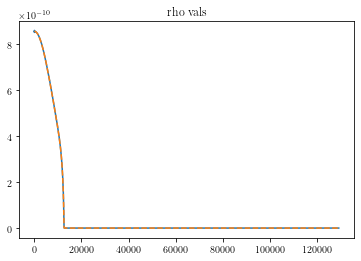

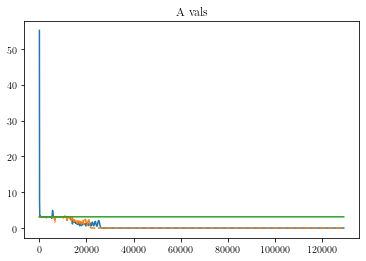

Plots for step  2550 of 4000 steps


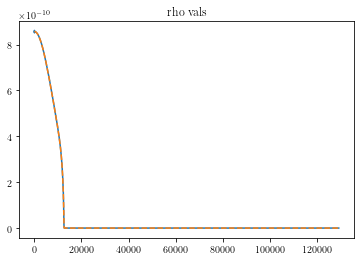

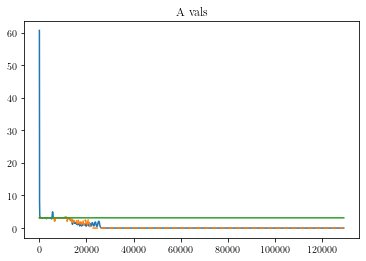

Plots for step  2560 of 4000 steps


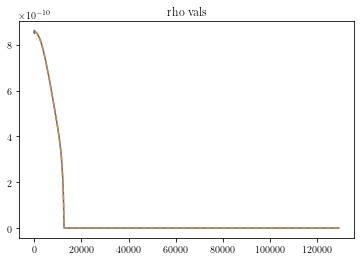

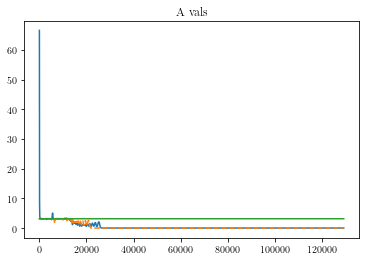

Plots for step  2570 of 4000 steps


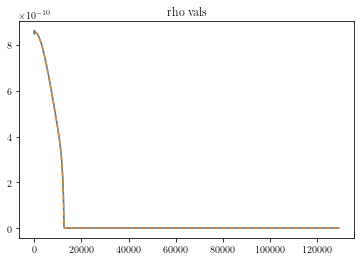

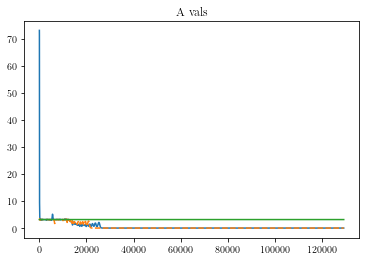

Plots for step  2580 of 4000 steps


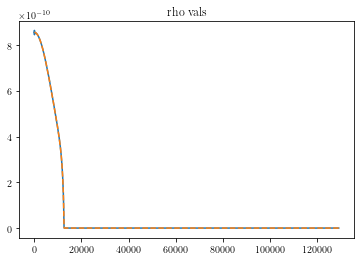

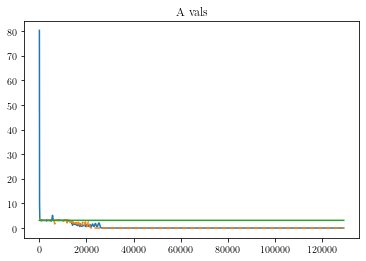

Plots for step  2590 of 4000 steps


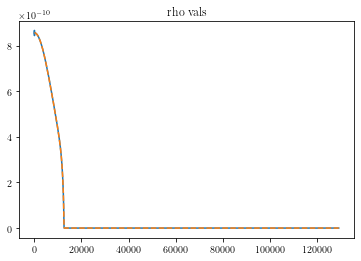

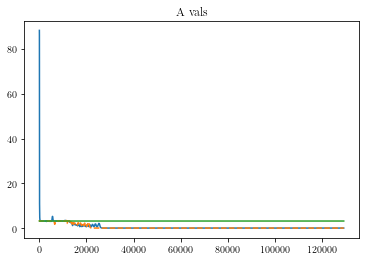

Plots for step  2600 of 4000 steps


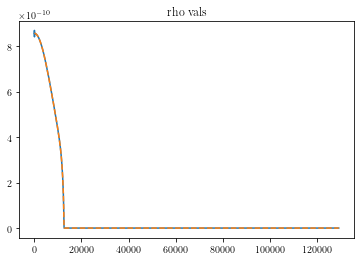

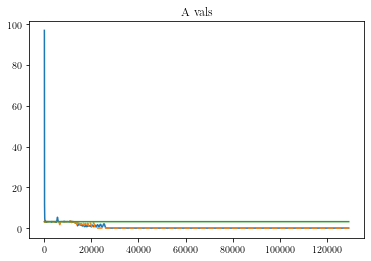

Plots for step  2610 of 4000 steps


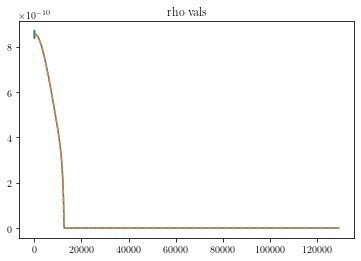

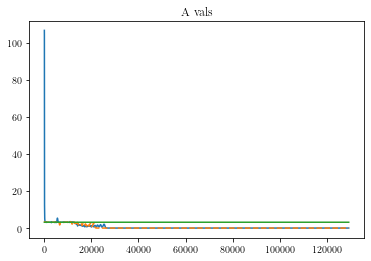

Plots for step  2620 of 4000 steps


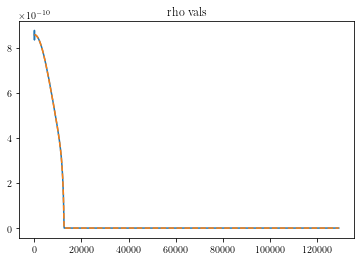

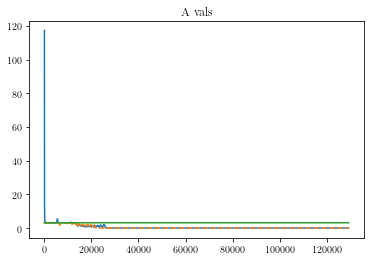

Plots for step  2630 of 4000 steps


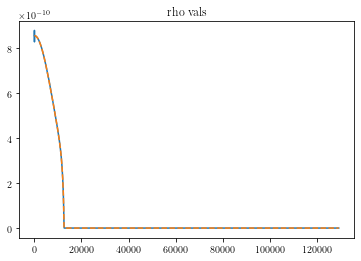

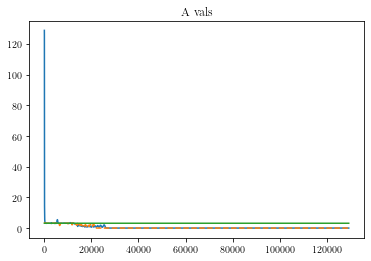

Plots for step  2640 of 4000 steps


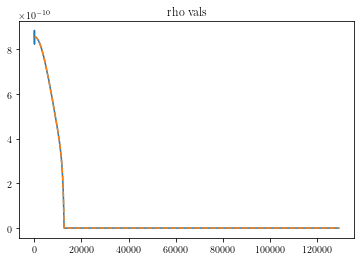

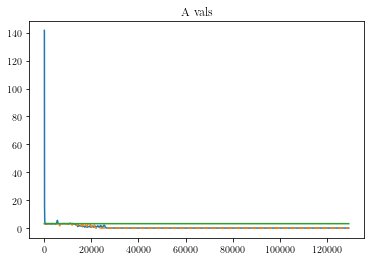

Plots for step  2650 of 4000 steps


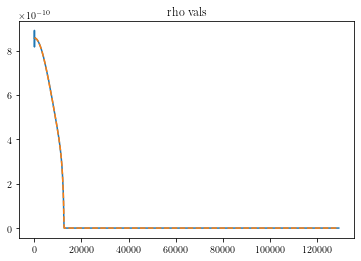

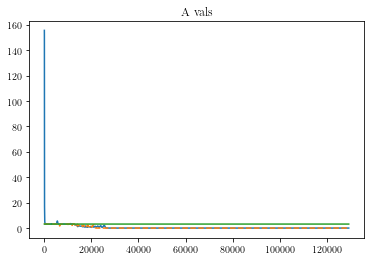

Plots for step  2660 of 4000 steps


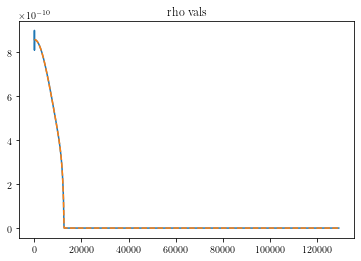

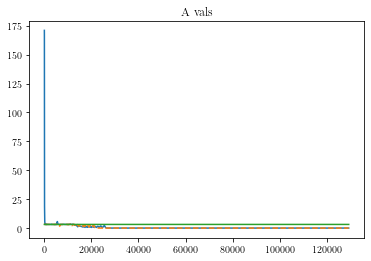

Plots for step  2670 of 4000 steps


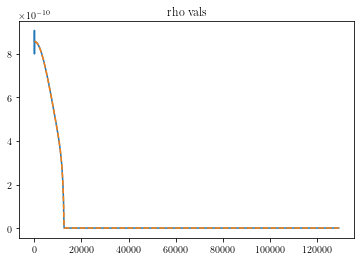

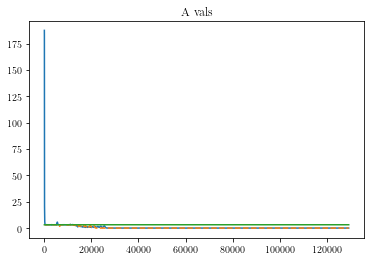

Plots for step  2680 of 4000 steps


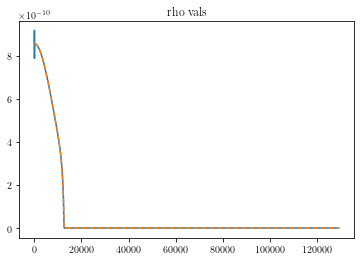

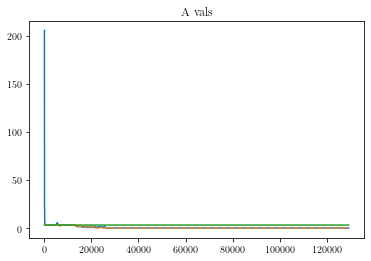

Plots for step  2690 of 4000 steps


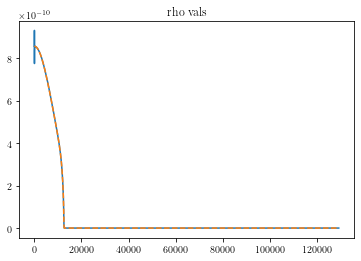

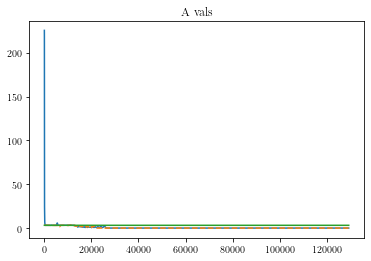

Plots for step  2700 of 4000 steps


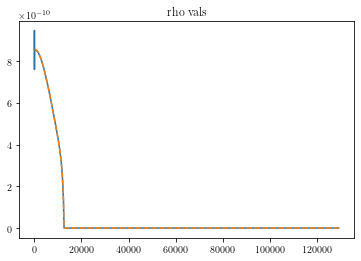

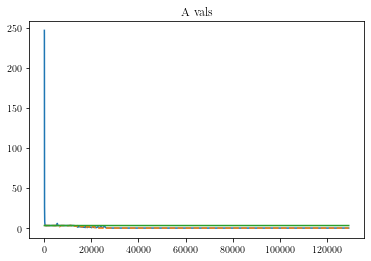

Plots for step  2710 of 4000 steps


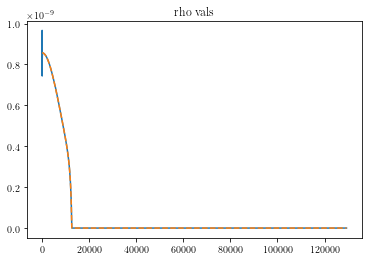

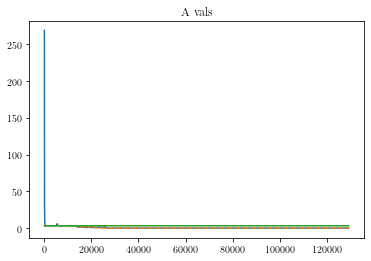

Plots for step  2720 of 4000 steps


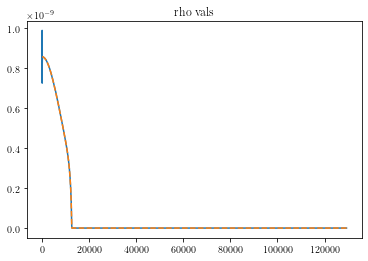

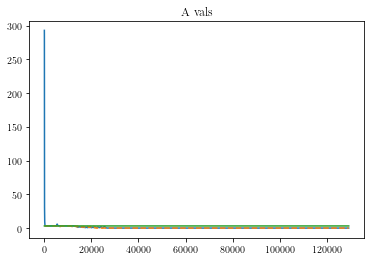

Plots for step  2730 of 4000 steps


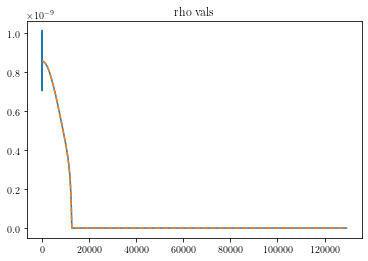

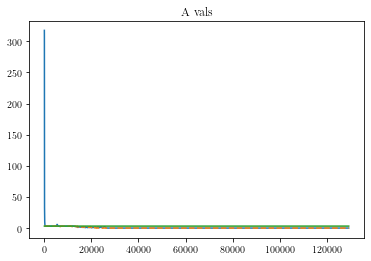

Plots for step  2740 of 4000 steps


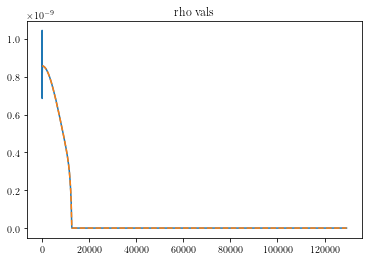

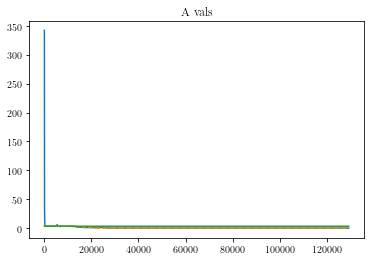

Plots for step  2750 of 4000 steps


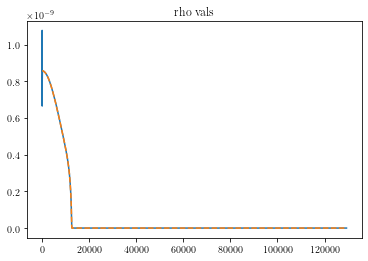

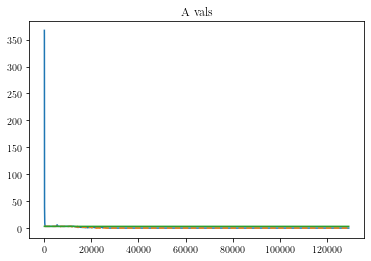

Plots for step  2760 of 4000 steps


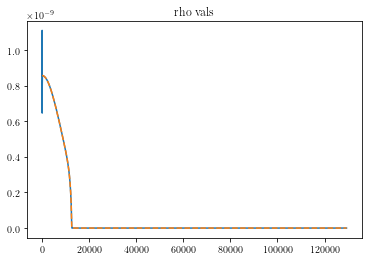

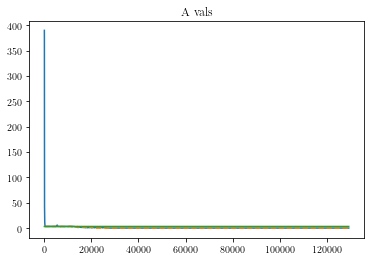

Plots for step  2770 of 4000 steps


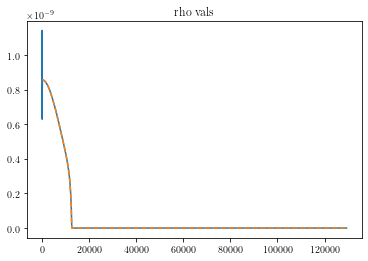

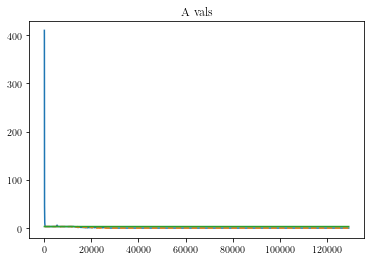

Plots for step  2780 of 4000 steps


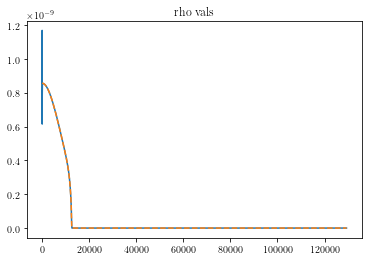

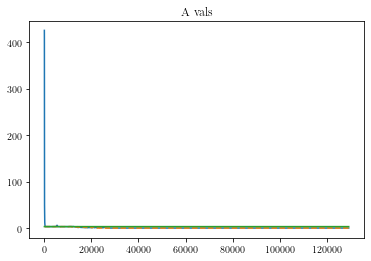

Plots for step  2790 of 4000 steps


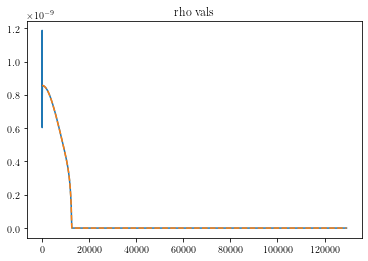

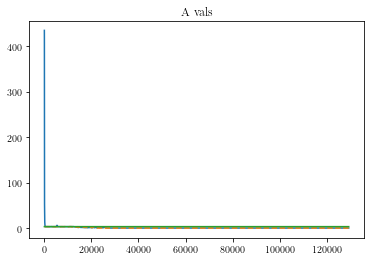

Plots for step  2800 of 4000 steps


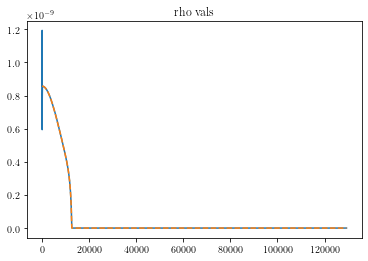

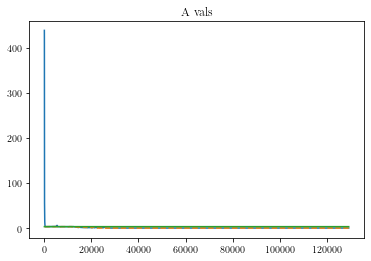

Plots for step  2810 of 4000 steps


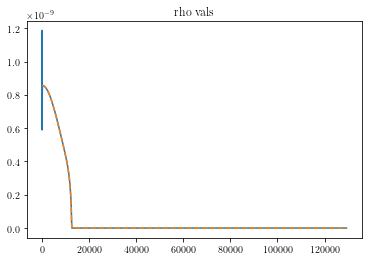

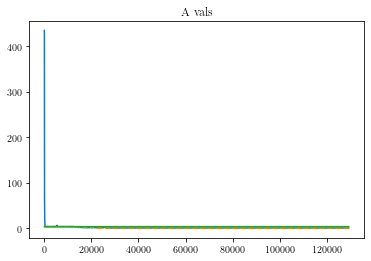

Plots for step  2820 of 4000 steps


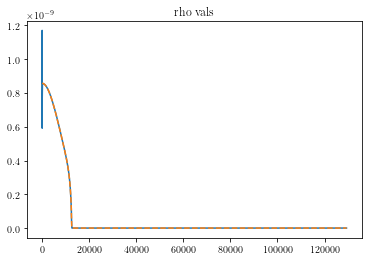

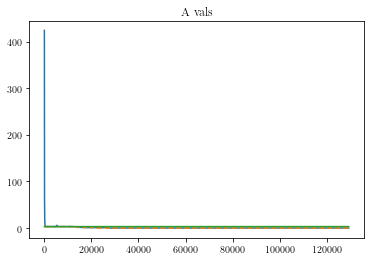

Plots for step  2830 of 4000 steps


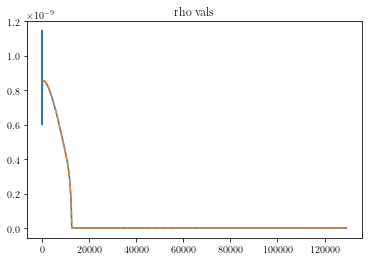

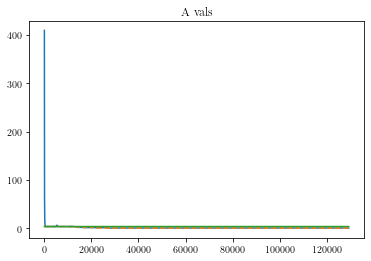

Plots for step  2840 of 4000 steps


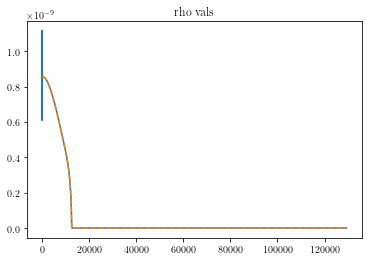

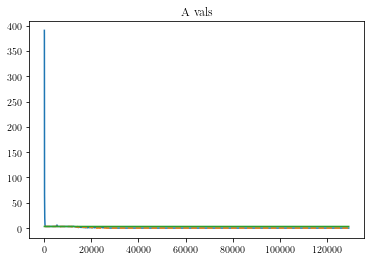

Plots for step  2850 of 4000 steps


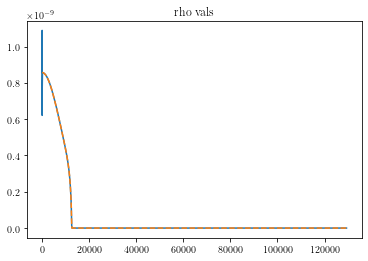

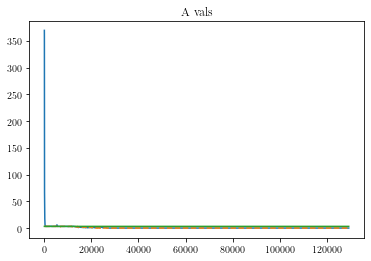

Plots for step  2860 of 4000 steps


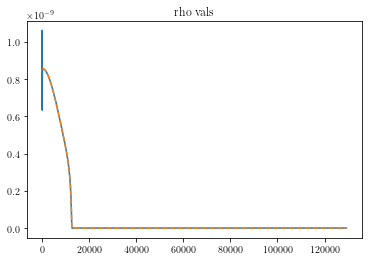

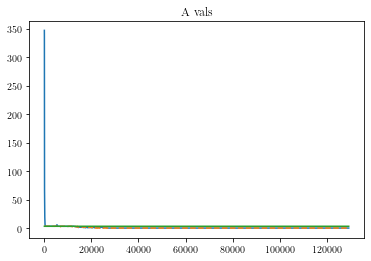

Plots for step  2870 of 4000 steps


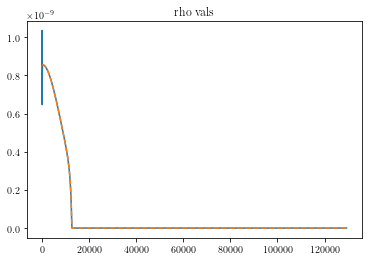

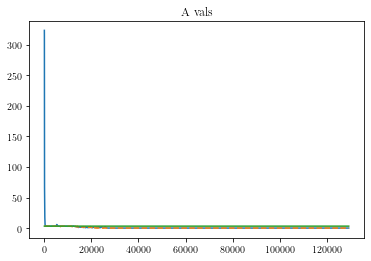

Plots for step  2880 of 4000 steps


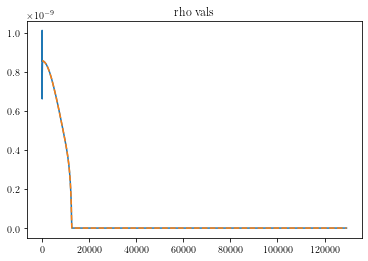

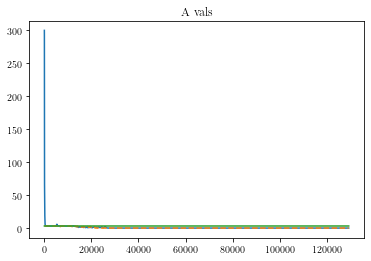

Plots for step  2890 of 4000 steps


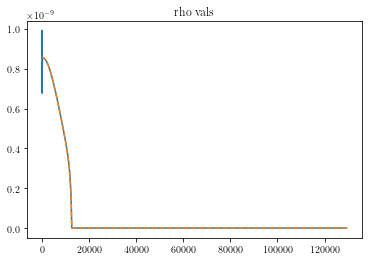

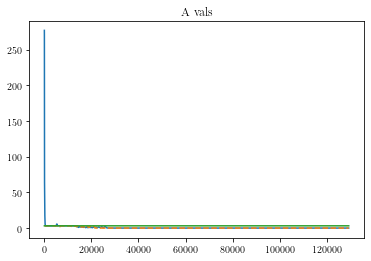

Plots for step  2900 of 4000 steps


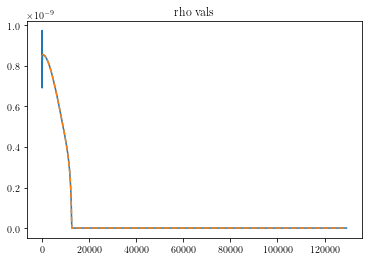

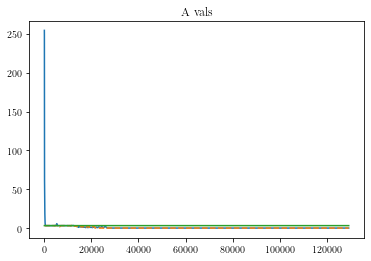

Plots for step  2910 of 4000 steps


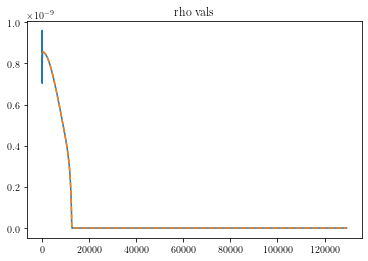

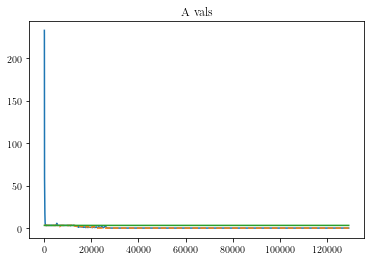

Plots for step  2920 of 4000 steps


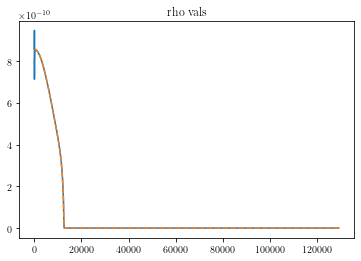

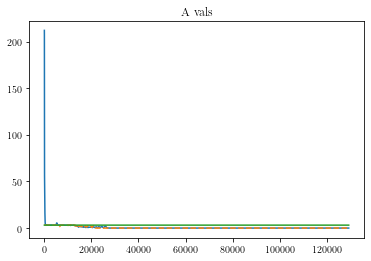

Plots for step  2930 of 4000 steps


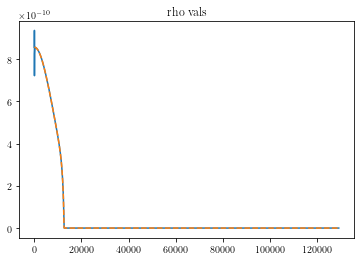

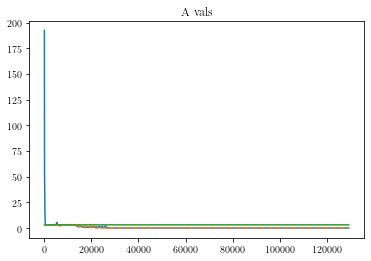

Plots for step  2940 of 4000 steps


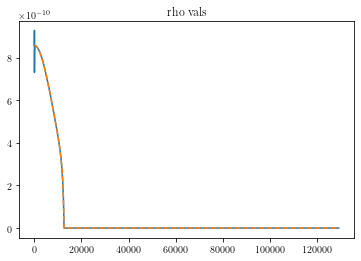

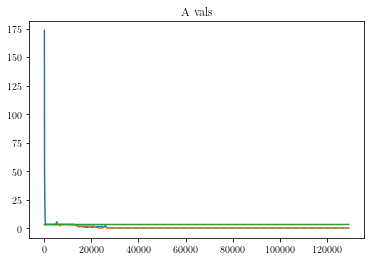

Plots for step  2950 of 4000 steps


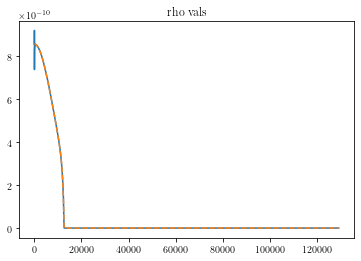

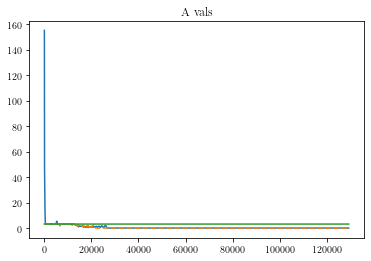

Plots for step  2960 of 4000 steps


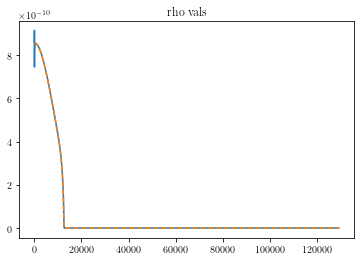

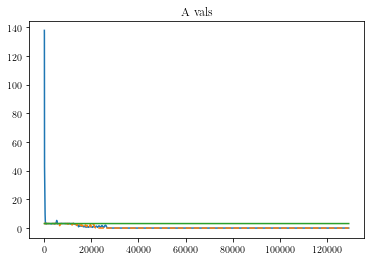

Plots for step  2970 of 4000 steps


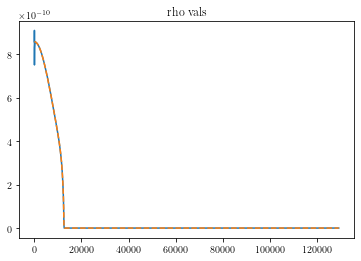

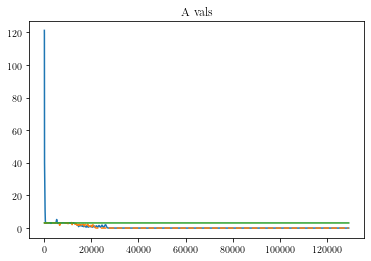

Plots for step  2980 of 4000 steps


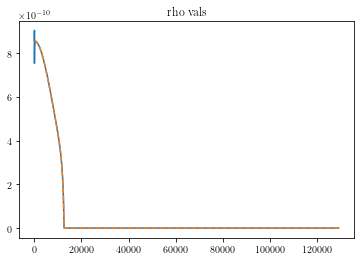

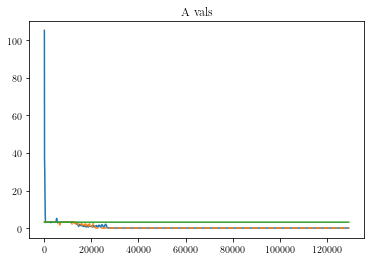

Plots for step  2990 of 4000 steps


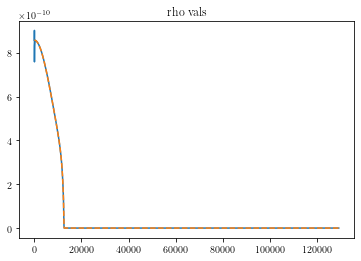

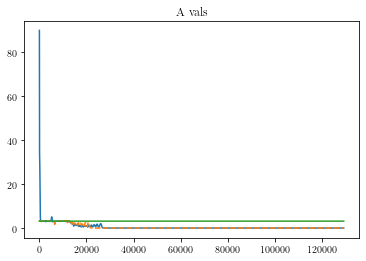

Plots for step  3000 of 4000 steps


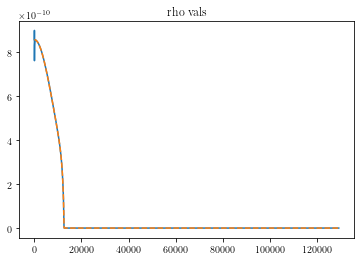

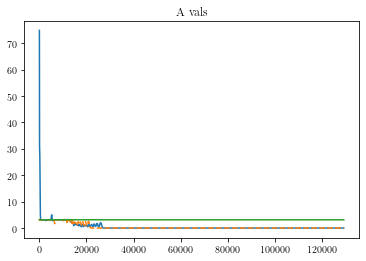

Plots for step  3010 of 4000 steps


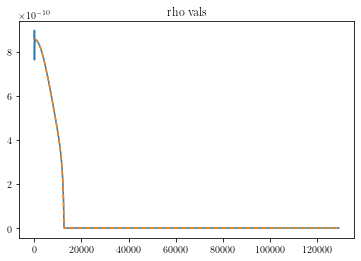

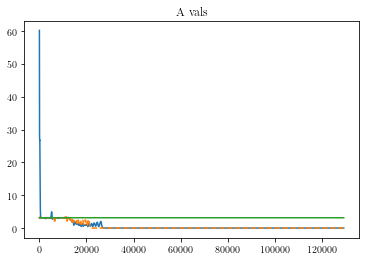

Plots for step  3020 of 4000 steps


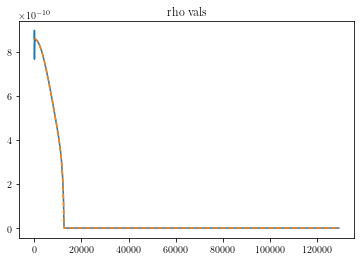

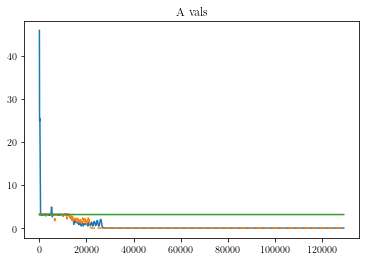

Plots for step  3030 of 4000 steps


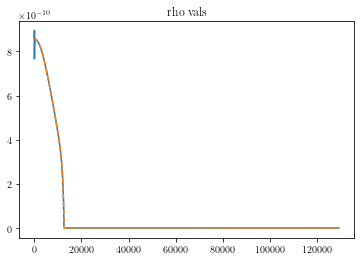

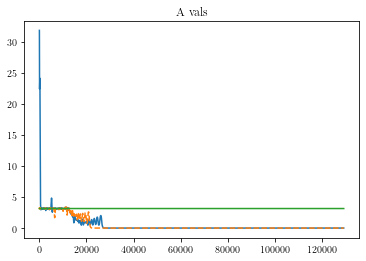

Plots for step  3040 of 4000 steps


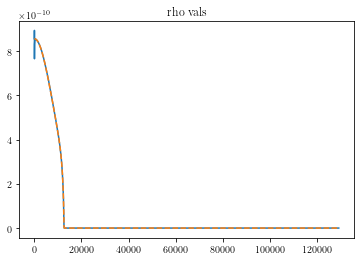

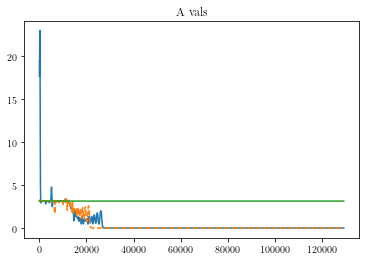

Plots for step  3050 of 4000 steps


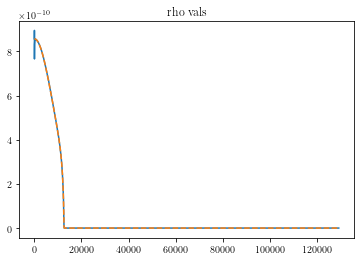

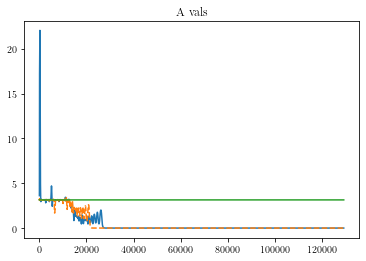

Plots for step  3060 of 4000 steps


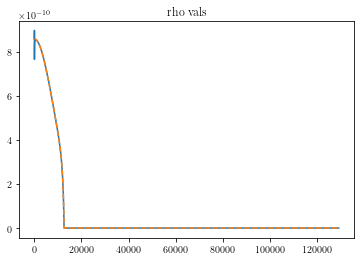

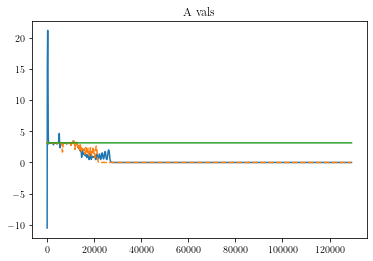

Plots for step  3070 of 4000 steps


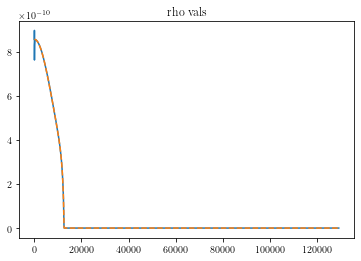

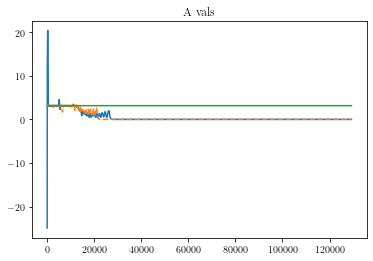

Plots for step  3080 of 4000 steps


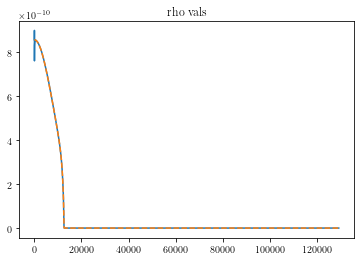

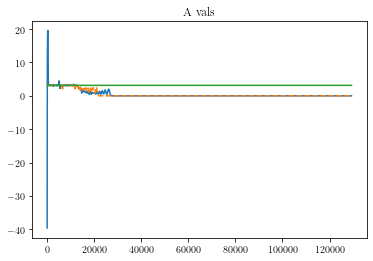

Plots for step  3090 of 4000 steps


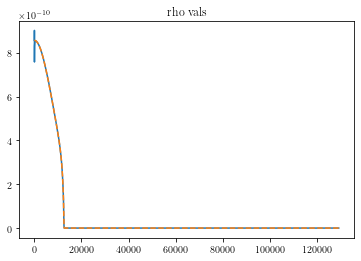

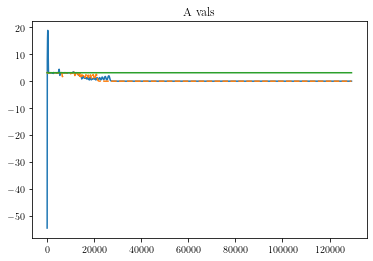

Plots for step  3100 of 4000 steps


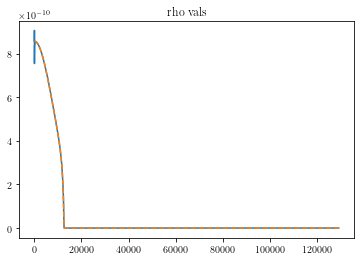

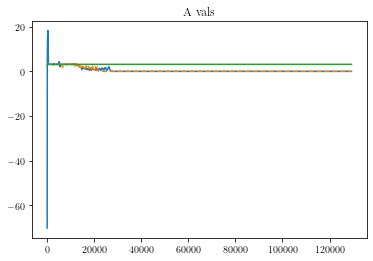

Plots for step  3110 of 4000 steps


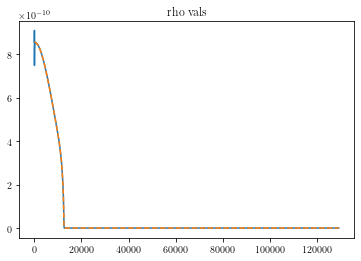

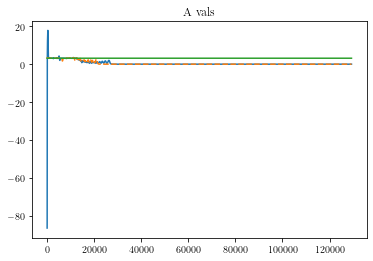

Plots for step  3120 of 4000 steps


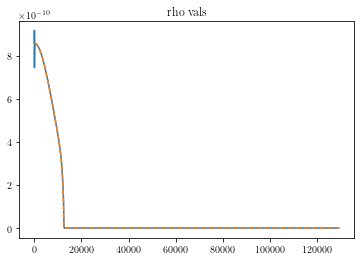

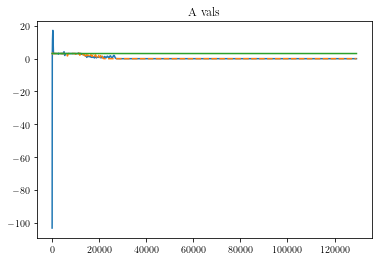

Plots for step  3130 of 4000 steps


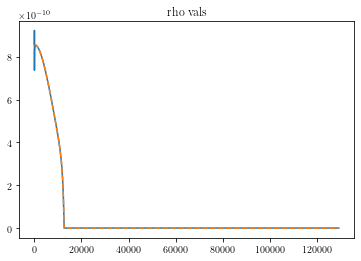

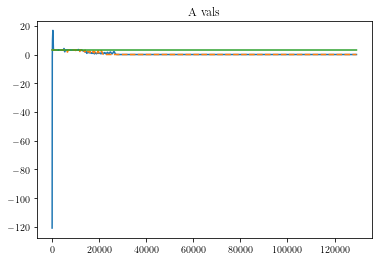

Plots for step  3140 of 4000 steps


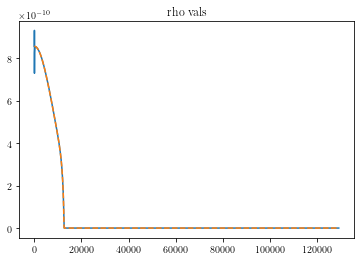

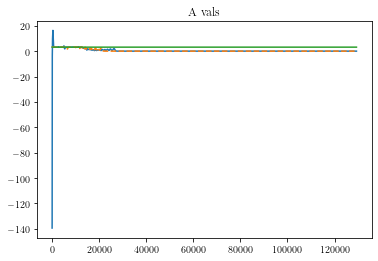

Plots for step  3150 of 4000 steps


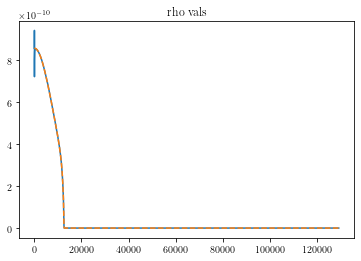

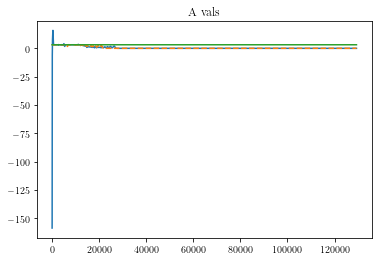

Plots for step  3160 of 4000 steps


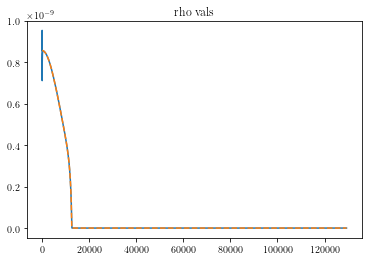

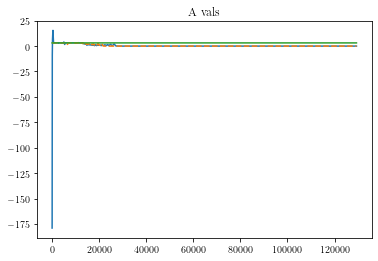

Plots for step  3170 of 4000 steps


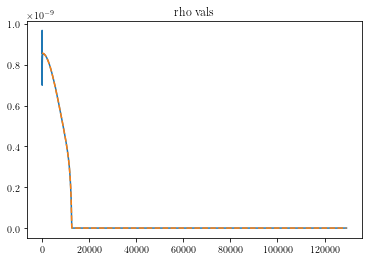

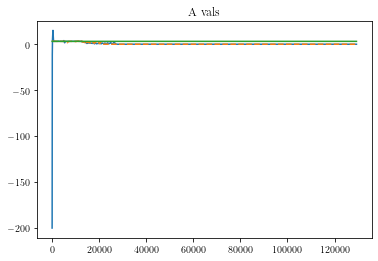

Plots for step  3180 of 4000 steps


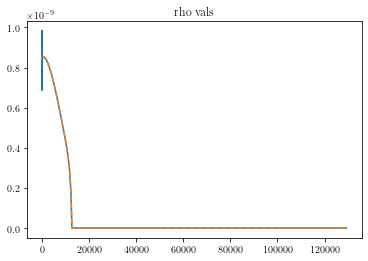

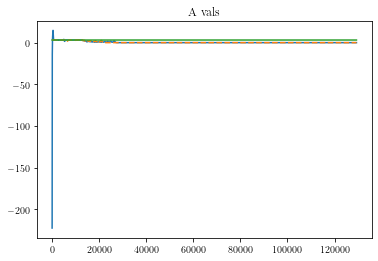

Plots for step  3190 of 4000 steps


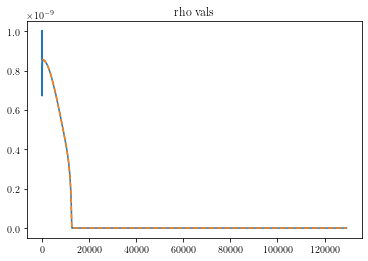

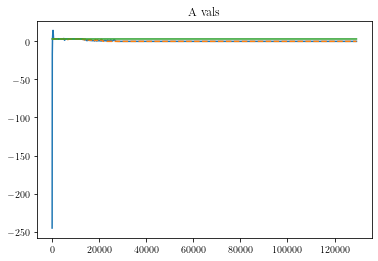

Plots for step  3200 of 4000 steps


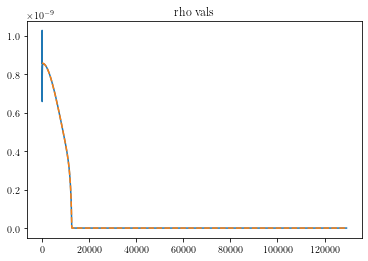

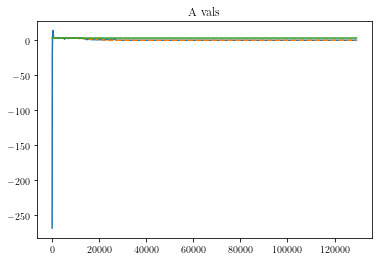

Plots for step  3210 of 4000 steps


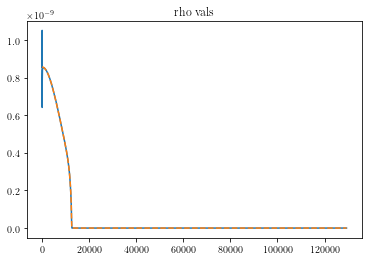

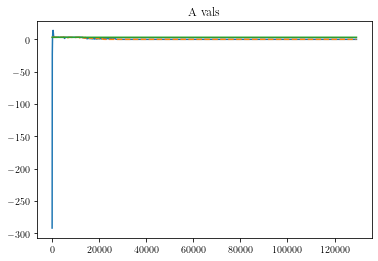

Plots for step  3220 of 4000 steps


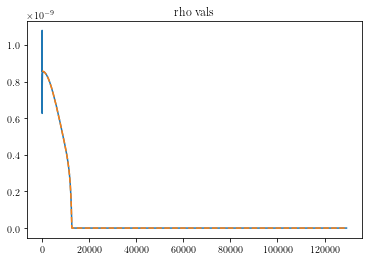

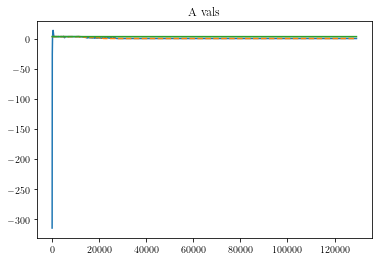

Plots for step  3230 of 4000 steps


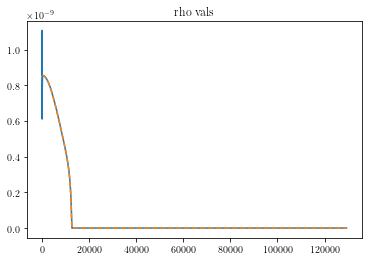

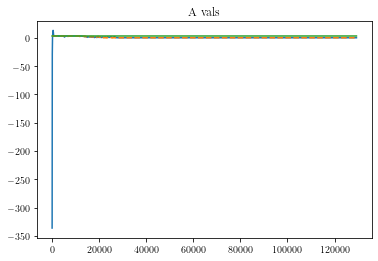

Plots for step  3240 of 4000 steps


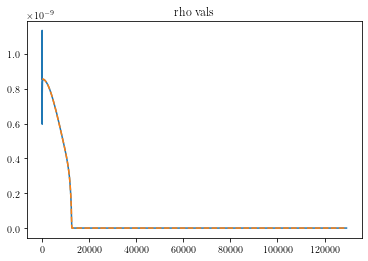

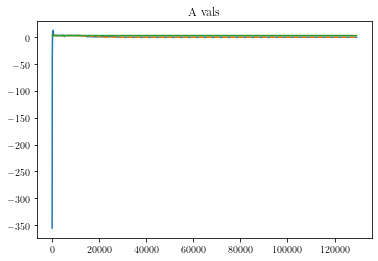

Plots for step  3250 of 4000 steps


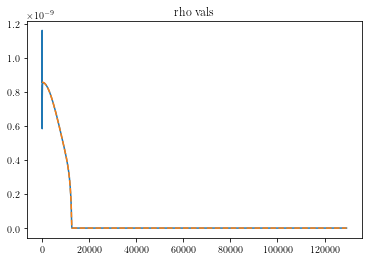

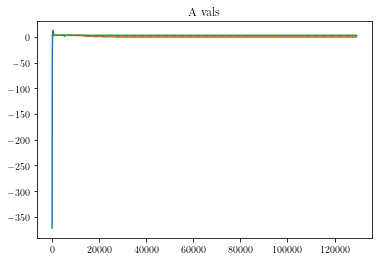

Plots for step  3260 of 4000 steps


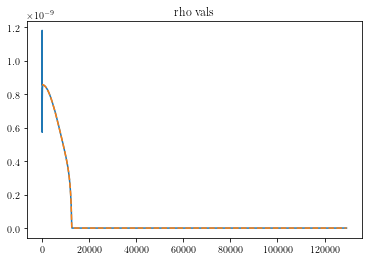

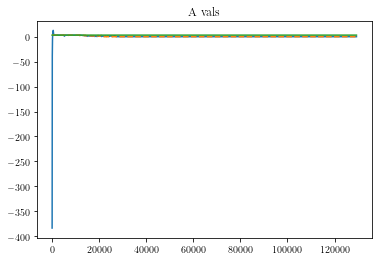

Plots for step  3270 of 4000 steps


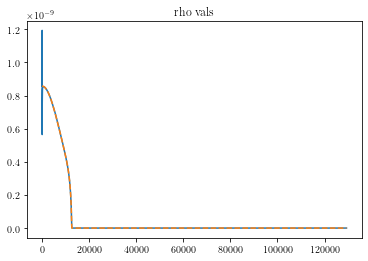

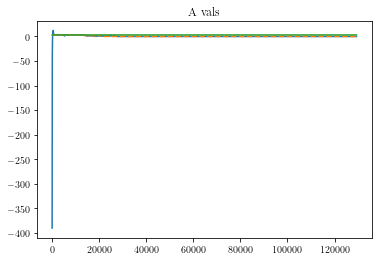

Plots for step  3280 of 4000 steps


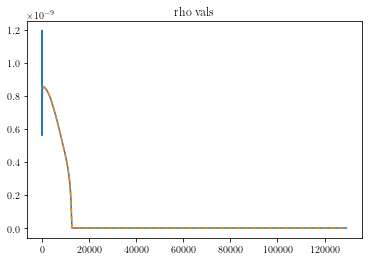

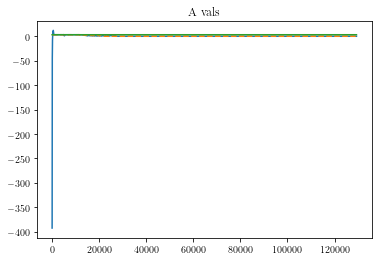

Plots for step  3290 of 4000 steps


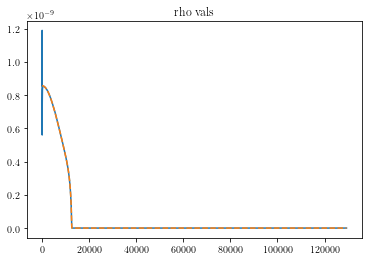

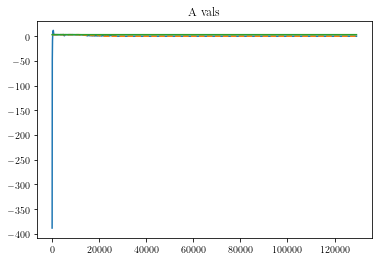

Plots for step  3300 of 4000 steps


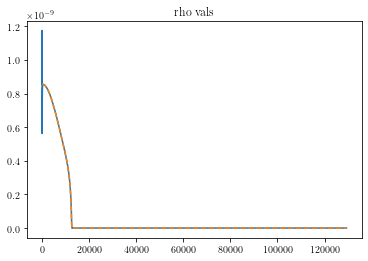

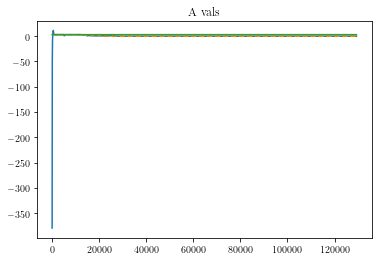

Plots for step  3310 of 4000 steps


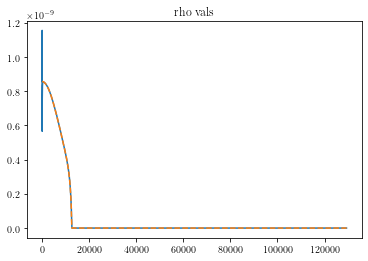

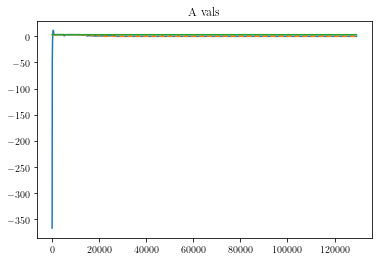

Plots for step  3320 of 4000 steps


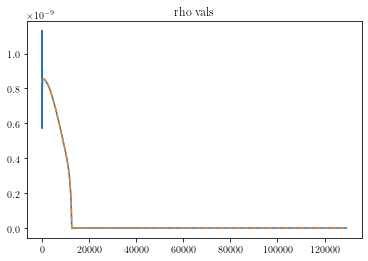

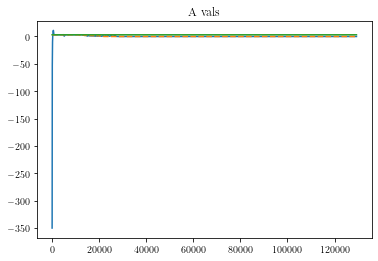

Plots for step  3330 of 4000 steps


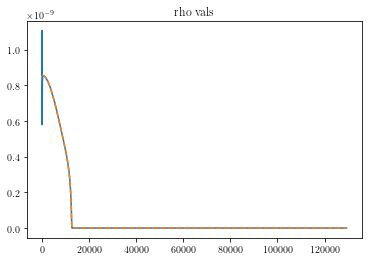

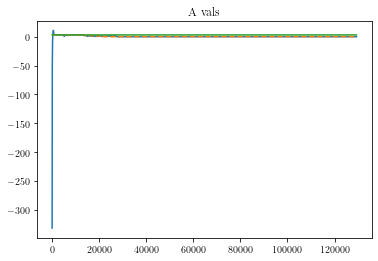

Plots for step  3340 of 4000 steps


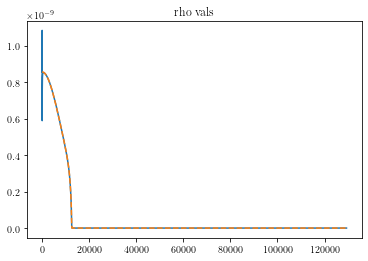

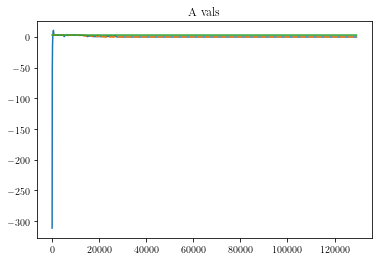

Plots for step  3350 of 4000 steps


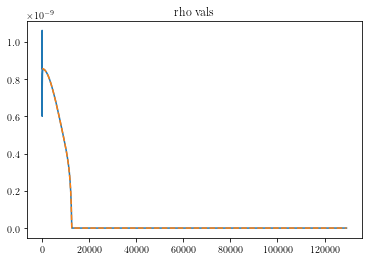

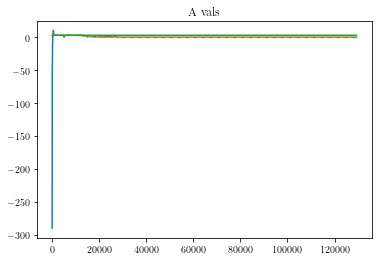

Plots for step  3360 of 4000 steps


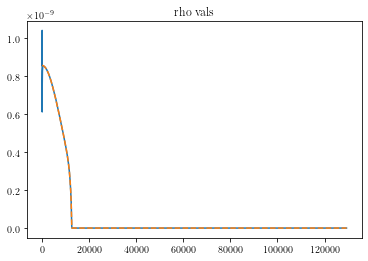

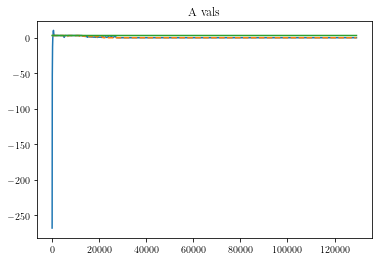

Plots for step  3370 of 4000 steps


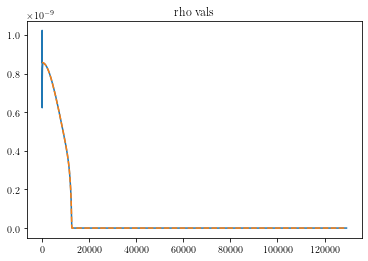

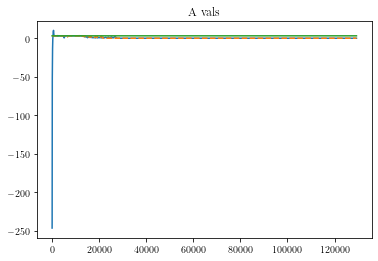

Plots for step  3380 of 4000 steps


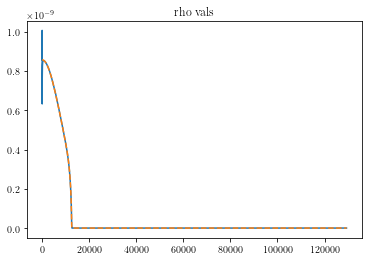

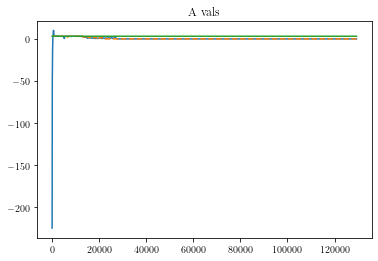

Plots for step  3390 of 4000 steps


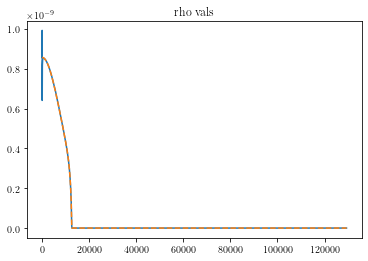

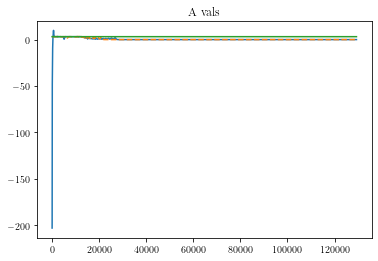

Plots for step  3400 of 4000 steps


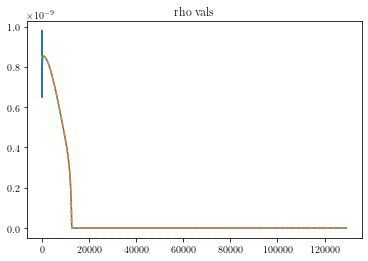

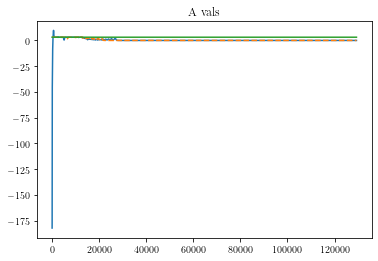

Plots for step  3410 of 4000 steps


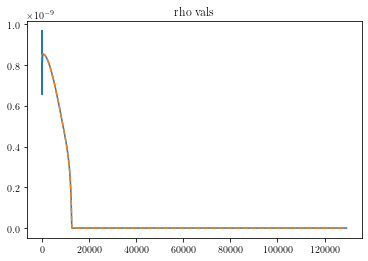

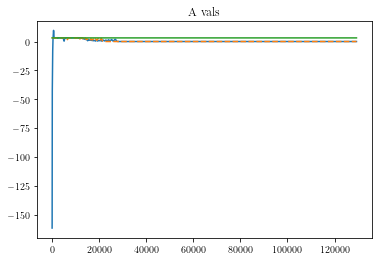

Plots for step  3420 of 4000 steps


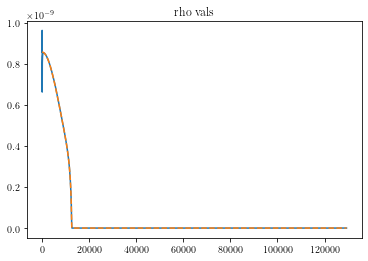

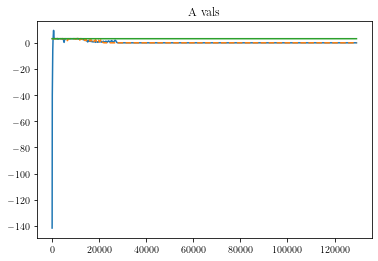

Plots for step  3430 of 4000 steps


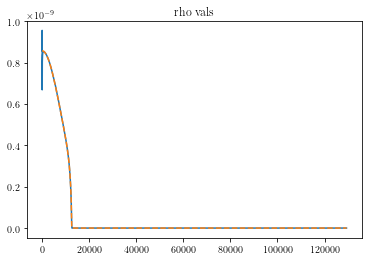

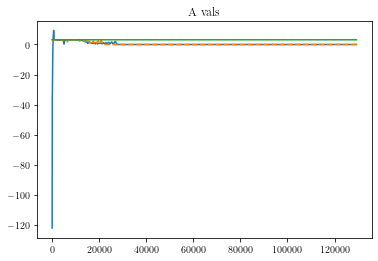

Plots for step  3440 of 4000 steps


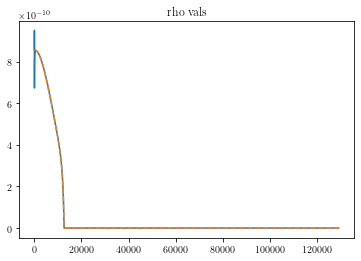

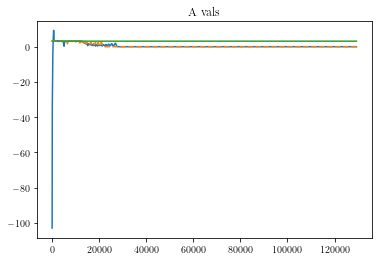

Plots for step  3450 of 4000 steps


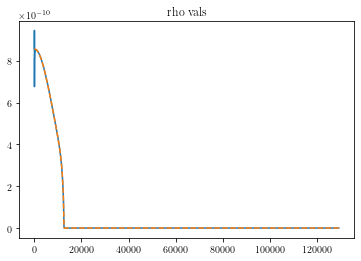

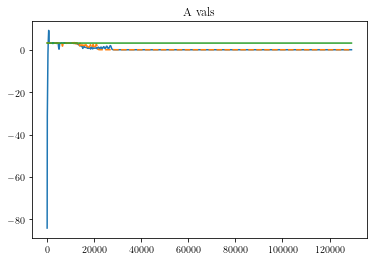

Plots for step  3460 of 4000 steps


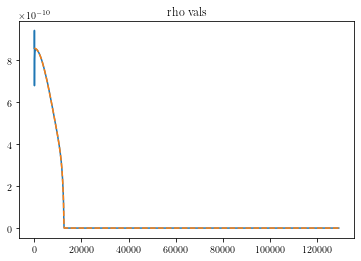

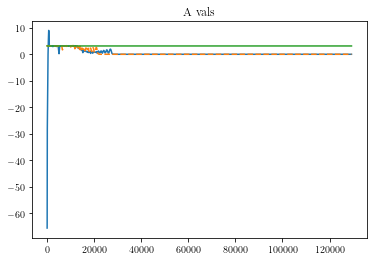

Plots for step  3470 of 4000 steps


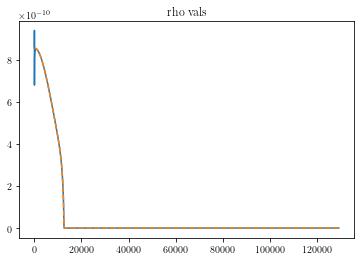

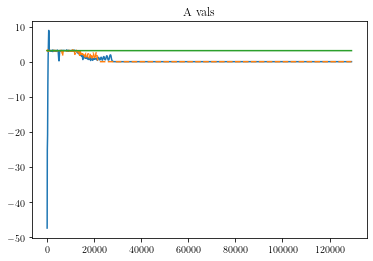

Plots for step  3480 of 4000 steps


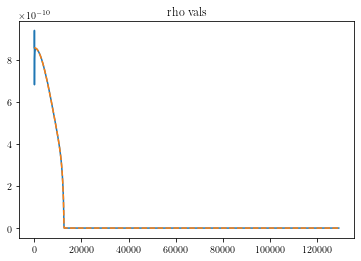

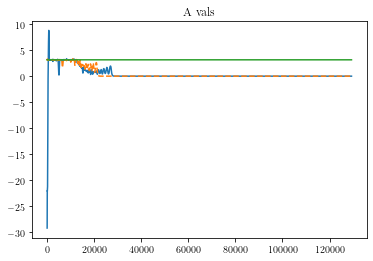

Plots for step  3490 of 4000 steps


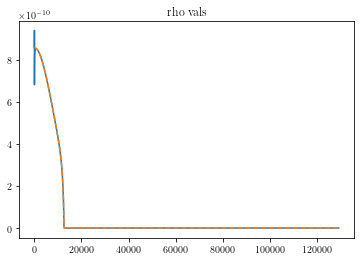

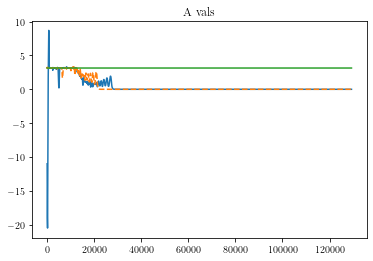

Plots for step  3500 of 4000 steps


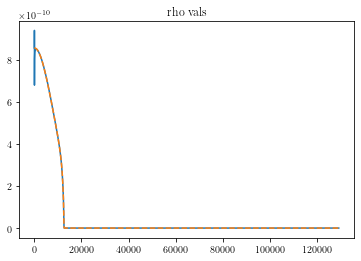

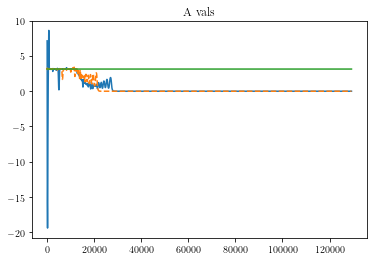

Plots for step  3510 of 4000 steps


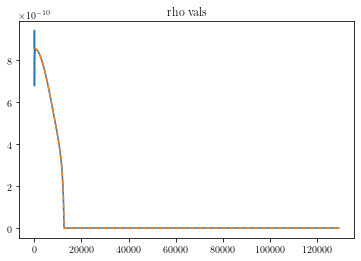

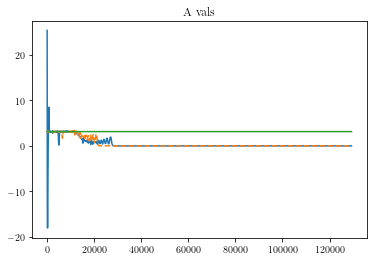

Plots for step  3520 of 4000 steps


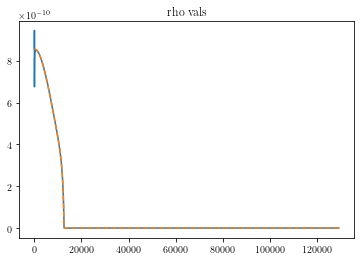

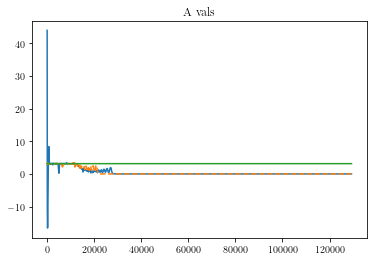

Plots for step  3530 of 4000 steps


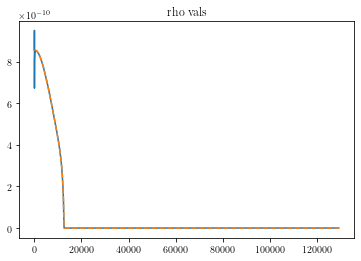

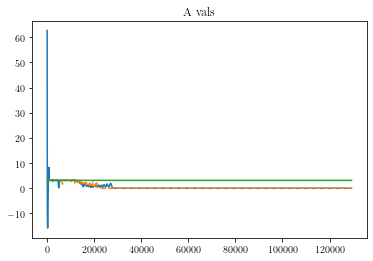

Plots for step  3540 of 4000 steps


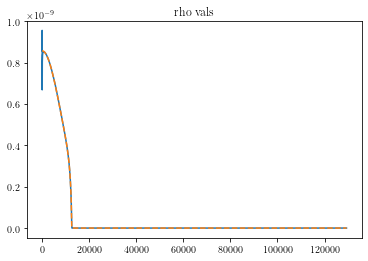

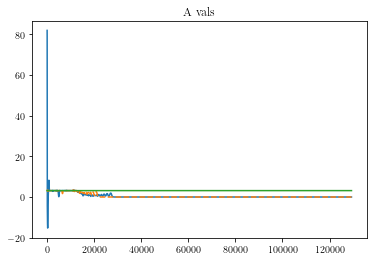

Plots for step  3550 of 4000 steps


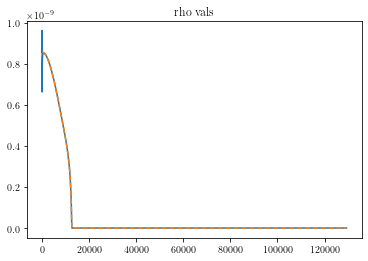

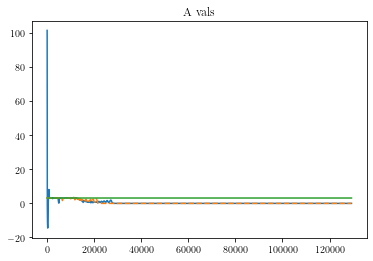

Plots for step  3560 of 4000 steps


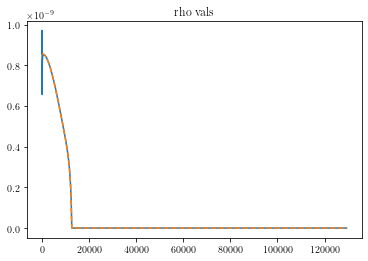

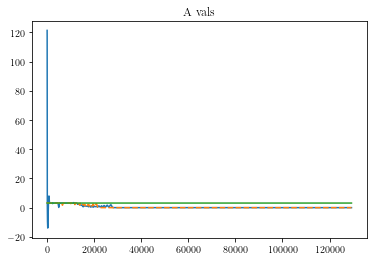

Plots for step  3570 of 4000 steps


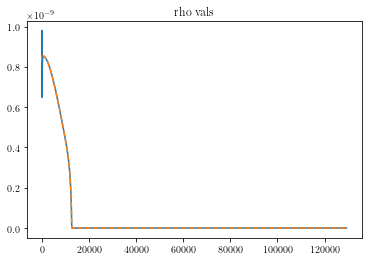

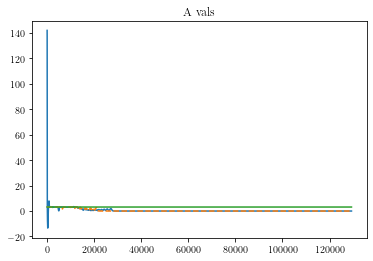

Plots for step  3580 of 4000 steps


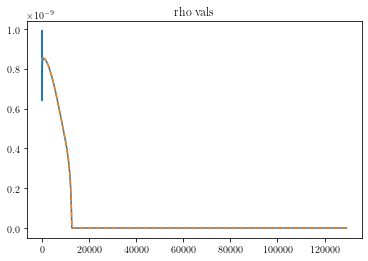

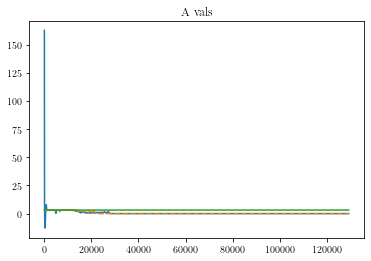

Plots for step  3590 of 4000 steps


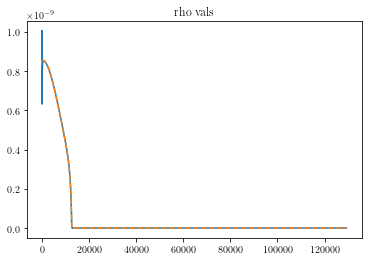

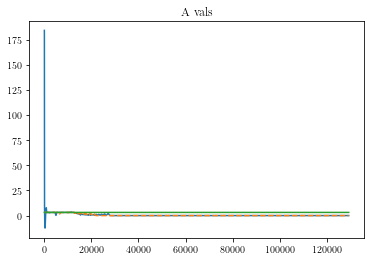

Plots for step  3600 of 4000 steps


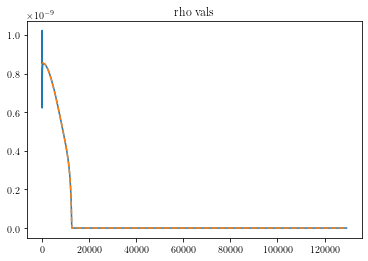

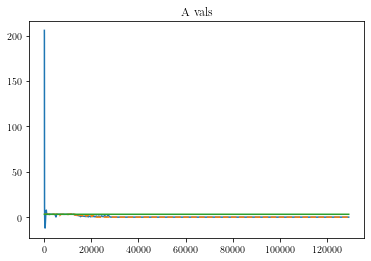

Plots for step  3610 of 4000 steps


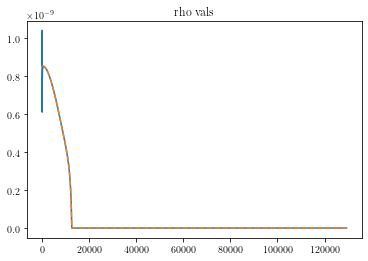

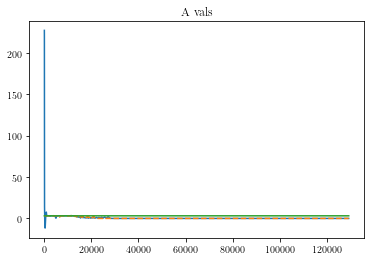

Plots for step  3620 of 4000 steps


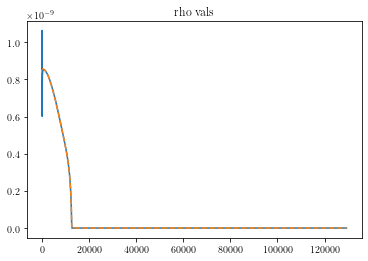

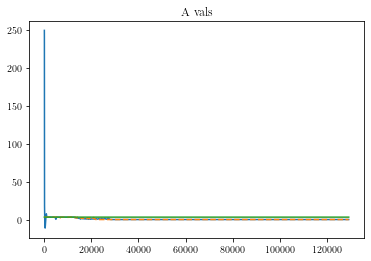

Plots for step  3630 of 4000 steps


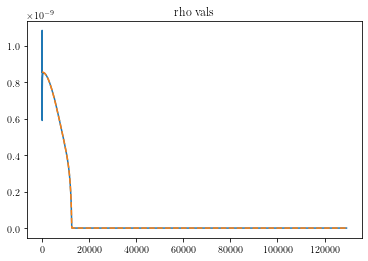

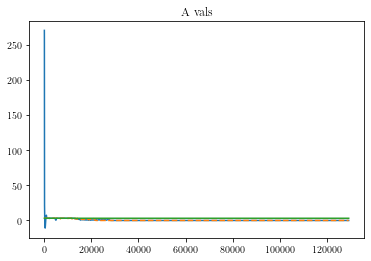

Plots for step  3640 of 4000 steps


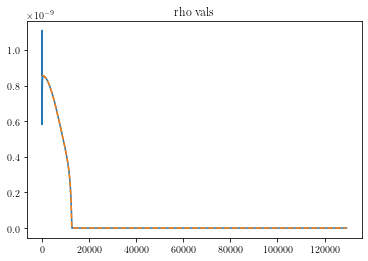

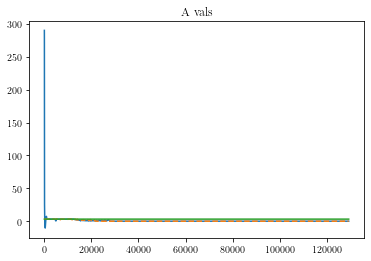

Plots for step  3650 of 4000 steps


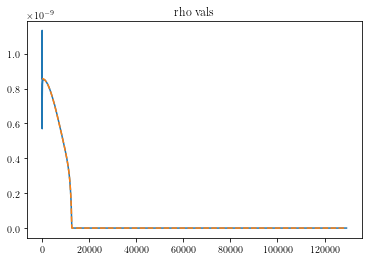

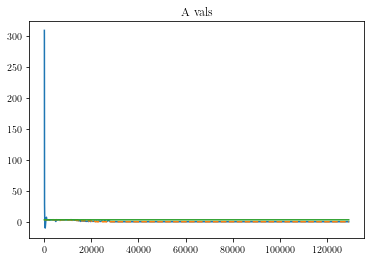

Plots for step  3660 of 4000 steps


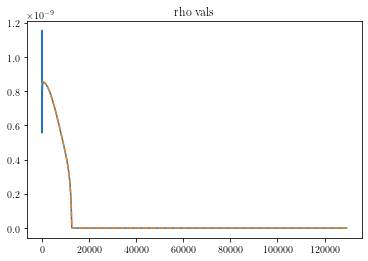

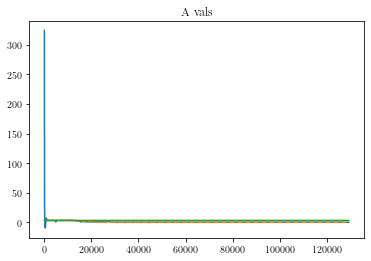

Plots for step  3670 of 4000 steps


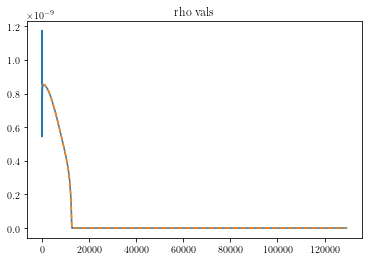

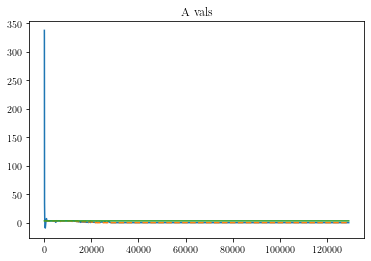

Plots for step  3680 of 4000 steps


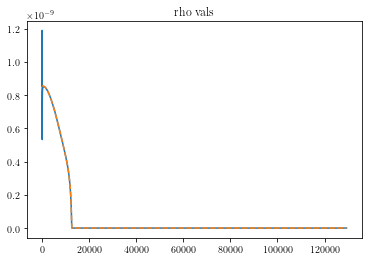

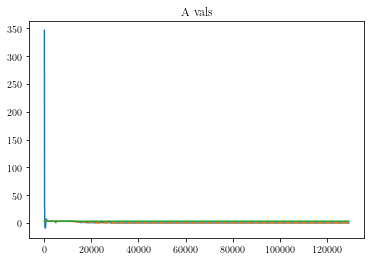

Plots for step  3690 of 4000 steps


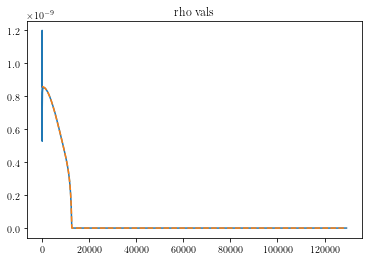

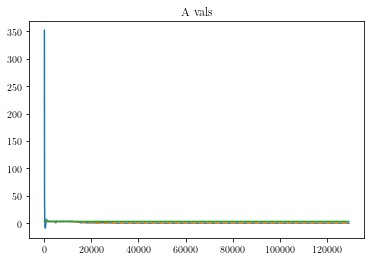

Plots for step  3700 of 4000 steps


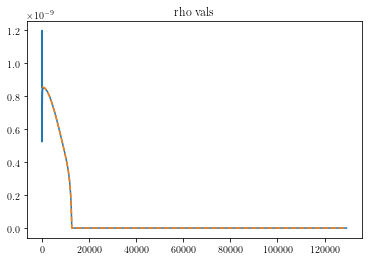

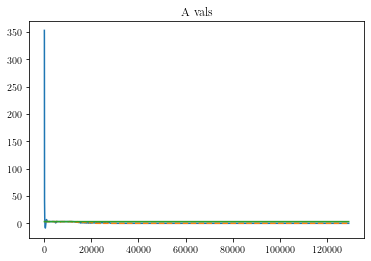

Plots for step  3710 of 4000 steps


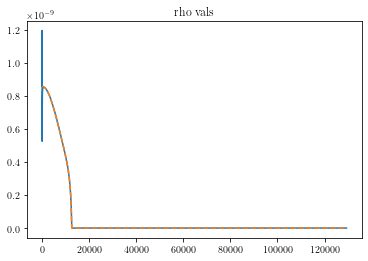

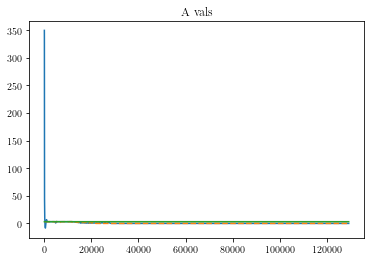

Plots for step  3720 of 4000 steps


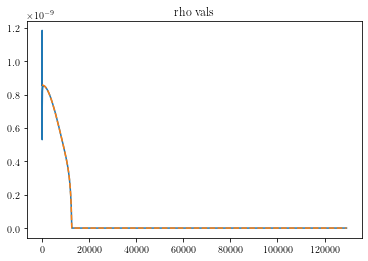

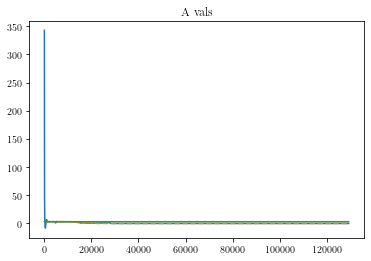

Plots for step  3730 of 4000 steps


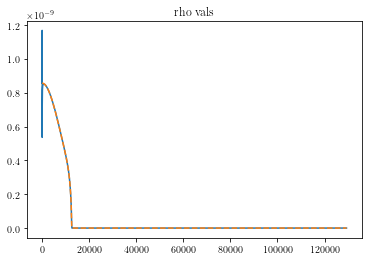

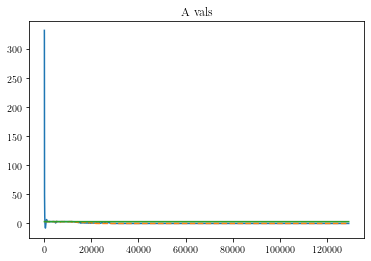

Plots for step  3740 of 4000 steps


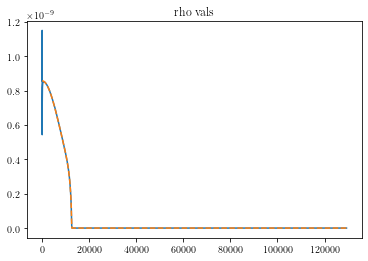

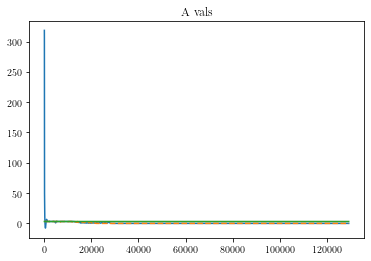

Plots for step  3750 of 4000 steps


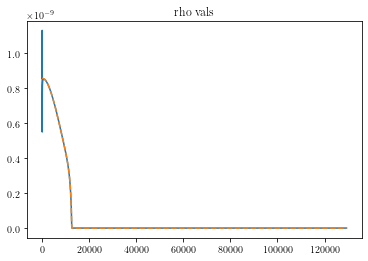

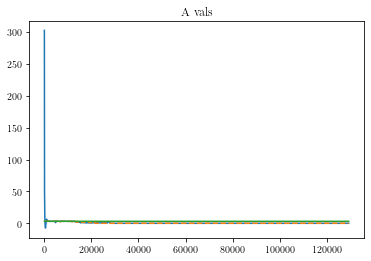

Plots for step  3760 of 4000 steps


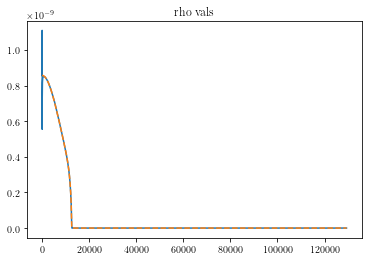

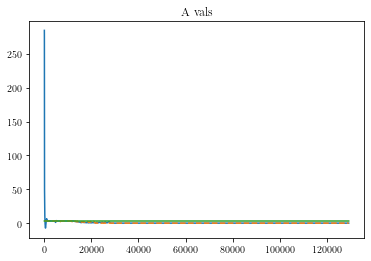

Plots for step  3770 of 4000 steps


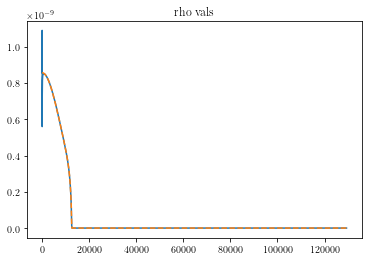

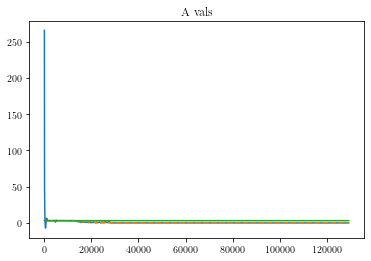

Plots for step  3780 of 4000 steps


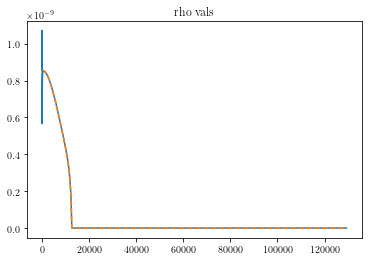

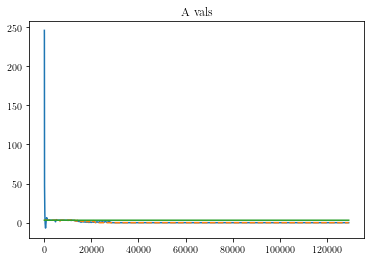

Plots for step  3790 of 4000 steps


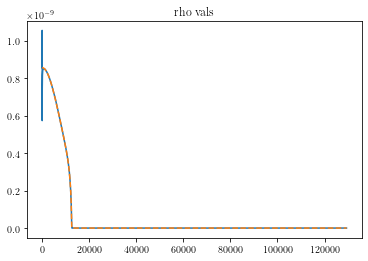

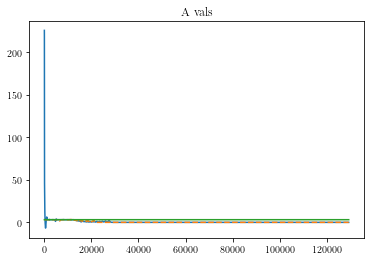

Plots for step  3800 of 4000 steps


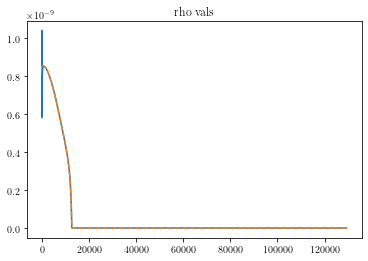

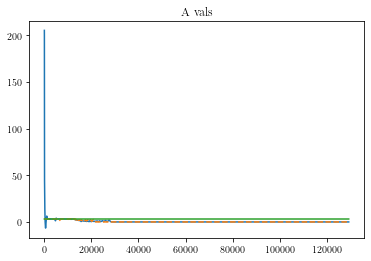

Plots for step  3810 of 4000 steps


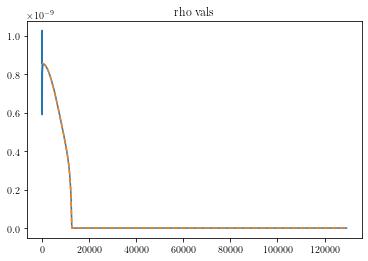

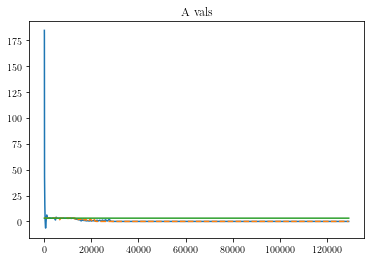

Plots for step  3820 of 4000 steps


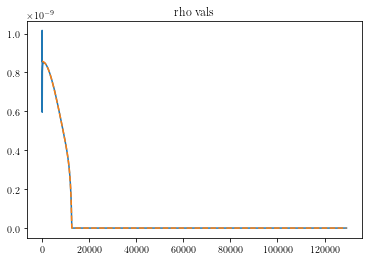

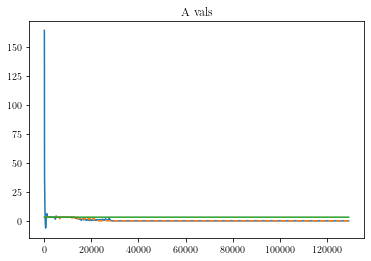

Plots for step  3830 of 4000 steps


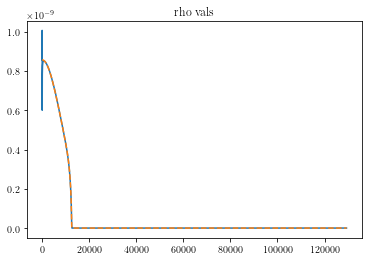

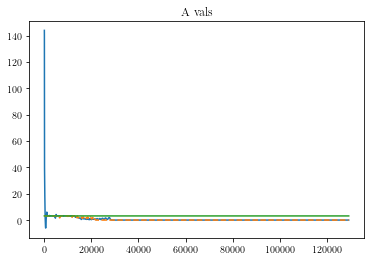

Plots for step  3840 of 4000 steps


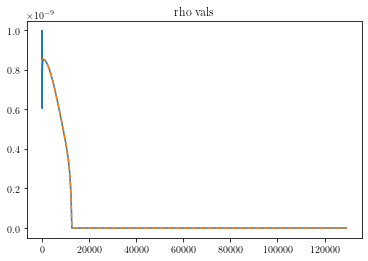

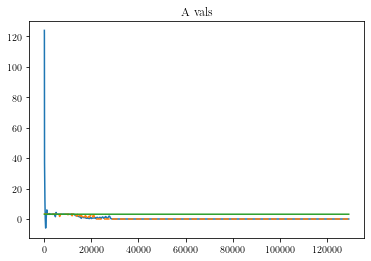

Plots for step  3850 of 4000 steps


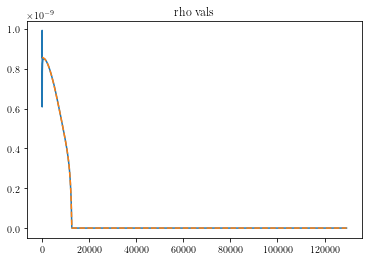

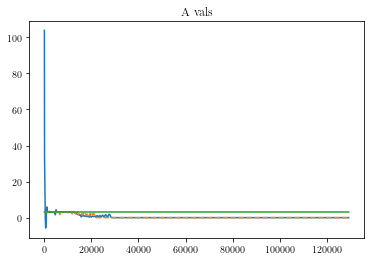

Plots for step  3860 of 4000 steps


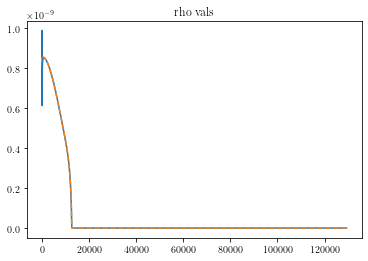

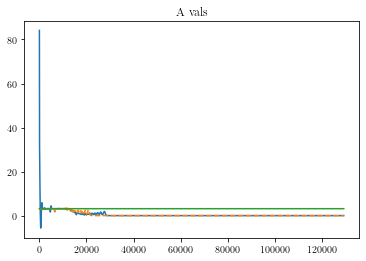

Plots for step  3870 of 4000 steps


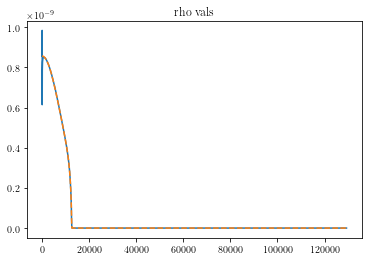

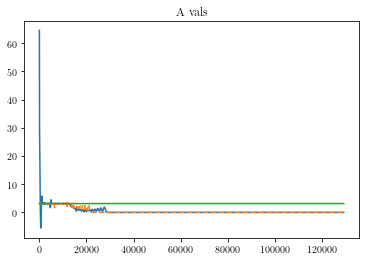

Plots for step  3880 of 4000 steps


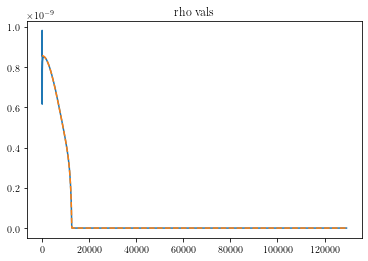

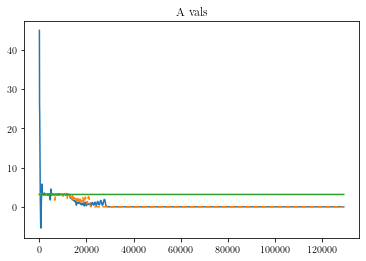

Plots for step  3890 of 4000 steps


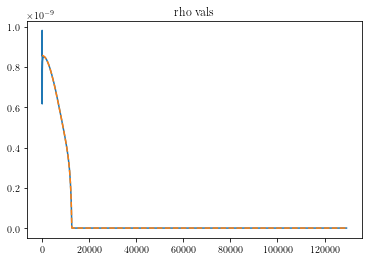

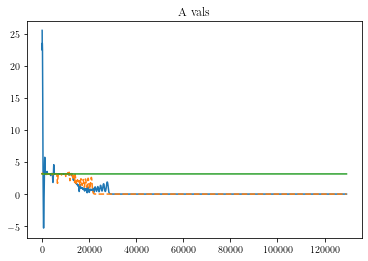

Plots for step  3900 of 4000 steps


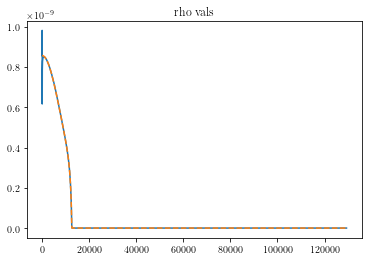

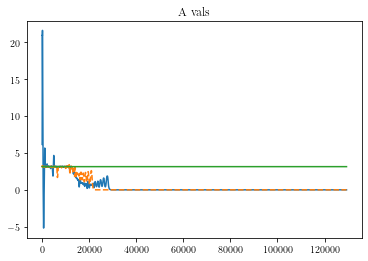

Plots for step  3910 of 4000 steps


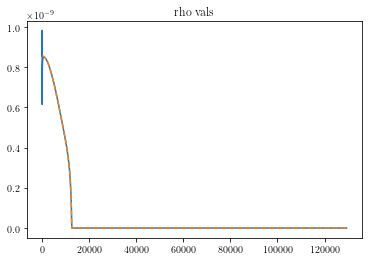

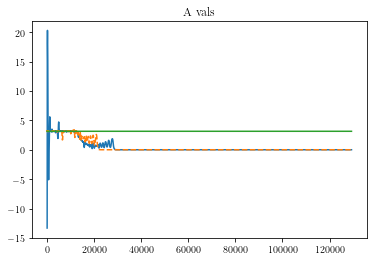

Plots for step  3920 of 4000 steps


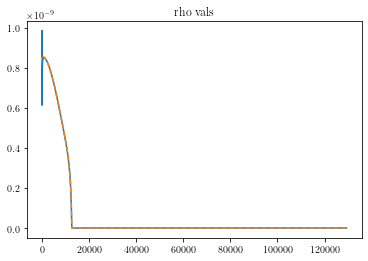

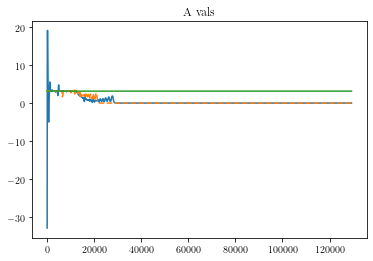

Plots for step  3930 of 4000 steps


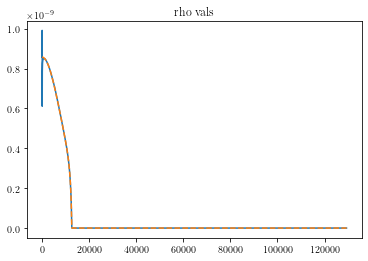

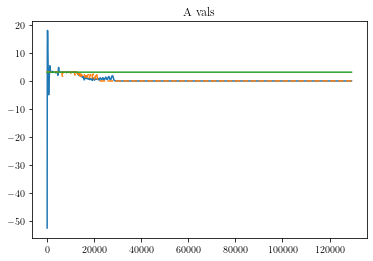

Plots for step  3940 of 4000 steps


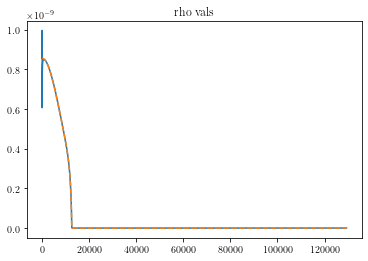

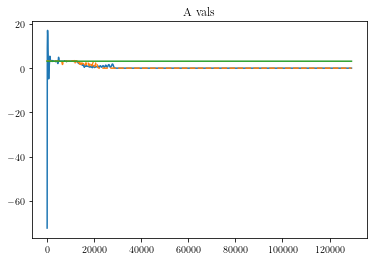

Plots for step  3950 of 4000 steps


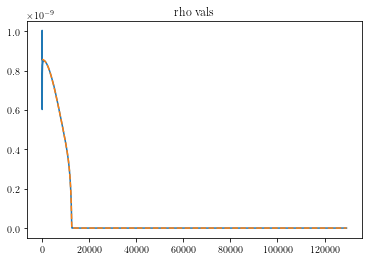

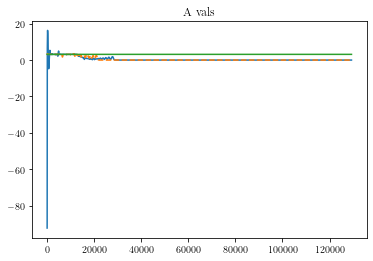

Plots for step  3960 of 4000 steps


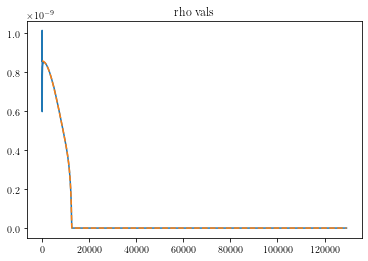

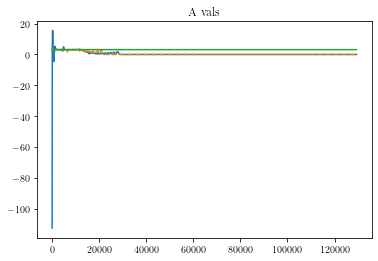

Plots for step  3970 of 4000 steps


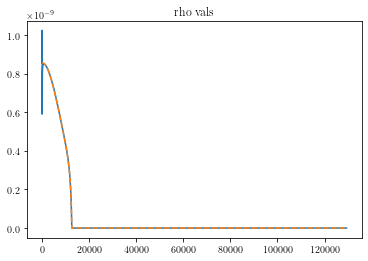

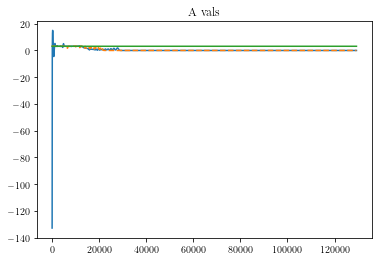

Plots for step  3980 of 4000 steps


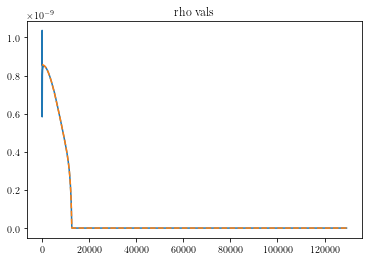

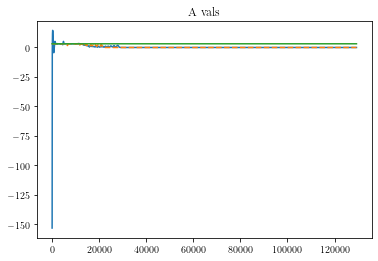

Plots for step  3990 of 4000 steps


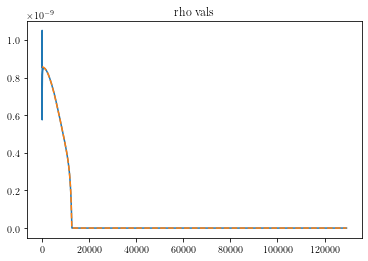

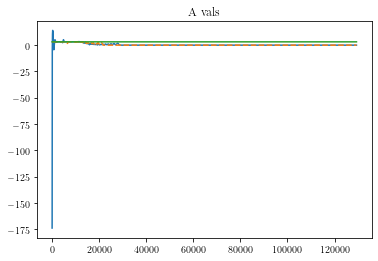

In [321]:
###################### Full Integrator ########################
# GLOBALS
tinit, tfin = 30000.0, 40000.0
rinit, rfin = density_vals[0, 0], density_vals[-1, 0]*1

Nt, Nr = 4000, 10000
dt, dr = (tfin - tinit) / Nt, (rfin - rinit) / Nr

rvals = np.linspace(rinit, rfin, Nr)
tvals = np.linspace(tinit, tfin, Nt)

NS_mass_radius = np.loadtxt(directory + "MR-vals.csv", delimiter=",")
#rNS = NS_mass_radius[myindex, 0]
#centraldensity = central_densities[myindex]



# specify initial energy distribution
U0vals = UTotalvals[-1, :]
R0vals = RTotalvals[-1, :]
A0vals = ATotalvals[-1, :]
P0vals = PTotalvals[-1, :]
F0vals = FTotalvals[-1, :]
G0vals = GTotalvals[-1, :]

# set up total arrays
FTotalvals, GTotalvals, UTotalvals, RTotalvals, ATotalvals, PTotalvals = np.zeros((Nt, Nr)), np.zeros((Nt, Nr)), np.zeros((Nt, Nr)), np.zeros((Nt, Nr)), np.zeros((Nt, Nr)), np.zeros((Nt, Nr))
FTotalvals[0, :] = F0vals
GTotalvals[0, :] = G0vals
UTotalvals[0, :] = U0vals
RTotalvals[0, :] = R0vals
ATotalvals[0, :] = A0vals
PTotalvals[0, :] = P0vals

# integrate
for i in range(1, Nt):
    #print(i)
    # integrate the matter sector
    matterandG1vals = matter_and_G_integrator(rvals, FTotalvals[i-1,:], GTotalvals[i-1,:], UTotalvals[i-1,:], RTotalvals[i-1,:], ATotalvals[i-1,:], PTotalvals[i-1,:])
    UTotalvals[i,:] = matterandG1vals[0:Nr]
    RTotalvals[i,:] = matterandG1vals[Nr:2*Nr]
    ATotalvals[i,:] = matterandG1vals[2*Nr:3*Nr]
    PTotalvals[i,:] = matterandG1vals[3*Nr:4*Nr]
    GTotalvals[i,:] = matterandG1vals[4*Nr:5*Nr]

    if int(i%10) == 0:
        print("Plots for step ", str(i) + " of " + str(Nt) + " steps")
        plt.plot(rvals, RTotalvals[i,:])
        plt.plot(rvals, R0vals, '--')
        plt.title("rho vals")
        plt.show()
        plt.plot(rvals, ATotalvals[i,:])
        plt.plot(rvals, A0vals, '--')
        plt.plot(rvals, np.ones(np.shape(rvals))*np.pi)
        plt.title("A vals")
        #plt.xlim(0, 30)
        plt.show()

    # integrate the metric sector
    FTotalvals[i,:] = solve_for_F_fast(GTotalvals[i,:], UTotalvals[i,:], RTotalvals[i,:], ATotalvals[i,:], PTotalvals[i,:], first_r_derivative(ATotalvals[i,:]))